<a href="https://colab.research.google.com/github/DineshKatravath/da6401_assignment1/blob/main/DA6401_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connecting to Wandb

In [ ]:
!pip install wandb

In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m018 (cs24m018-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import wandb

# Initialize a new WandB run
wandb.init(project="DA6401 Assignment1")

# Finish the run when you're done
wandb.finish()

# Question 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

# Load the Fashion-MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


wandb.init(project="DA6401 Assignment1")
runName = "Generating Images"
wandb.run.name = runName
wandb.run.save()

# Define class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axs = plt.subplots(2,5)
images = []

# Loop through each class
for i in range(10):
    # Find the first image of the current class in the training set
    idx = np.where(y_train == i)[0][0]

    # Plot the image
    x = i//5
    y = i%5

    wandb.log({"Image": wandb.Image(x_train[idx],caption=class_labels[i])})
    axs[x,y].imshow(x_train[idx], cmap='gray')
    axs[x,y].set_title(class_labels[i])
    axs[x,y].axis('off')  # Turn off axis for better visualization

wandb.finish()

plt.tight_layout()
plt.show()

# Question 2 and 3


In [2]:
# importing all libraries
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Activation Functions

def sigmoid(X):
  X = np.clip(X, -1000, 1000)  # Clipping x to avoid overflow
  return 1./(1+np.exp(-X))

def tanh(X):
  return np.tanh(X)

def relu(X):
  return np.maximum(0,X)

def identity(X):
  return X

def softMax(X):
  # subtracting maxVal for stability
  maxVal = np.max(X,axis=0,keepdims=True)
  X = X - maxVal
  return np.exp(X)/np.sum(np.exp(X),axis=0,keepdims=True)


# Gradient Activation Functions

def sigmoidGrad(X):
  S = sigmoid(X)
  return S * (1 - S)

def tanhGrad(X):
  return 1-tanh(X)**2

def reluGrad(X):
  return np.where(X>0,1,0)

def identityGrad(X):
  return np.ones_like(X)

def softMaxGrad(X):
  S = softMax(X)
  return np.diagflat(S) - np.outer(S, S) # for multiple classes

# Weight Initializations

def randomInit(shape):
  return np.random.randn(*shape)*0.01

def xavierInit(shape):
  inputCount,outputCount = shape
  std = np.sqrt(2/(inputCount+outputCount))
  return np.random.normal(0,std,shape)

In [6]:
class feedForwardNeuralNetwork:

  def __init__(self,inputSize,hiddenSize,hiddenLayerCount,outputSize,epochs,batchSize,optimiser,weightDecay,beta=0.9,lossFunc="crossEntropyLoss",activationFunc="tanh",learningRate=0.001,beta1=0.9,beta2=0.999,dataset="fashionMNIST",isWandb=False,initMode="xavier"):
    # declaring all parameters
    self.inputSize = inputSize
    self.hiddenSize = hiddenSize
    self.hiddenLayerCount = hiddenLayerCount
    self.outputSize = outputSize
    self.epochs = epochs
    self.batchSize = batchSize
    self.weightDecay = weightDecay
    self.beta = beta
    self.beta1 = beta1
    self.beta2 = beta2
    self.lossFunc = lossFunc
    self.activationFunc = activationFunc
    self.learningRate = learningRate
    self.optimiser = optimiser
    self.isWandb = isWandb
    self.initMode = initMode
    self.dataset = dataset


    self.weights = []
    self.biases = []
    self.activationLayer = []
    self.preActivationLayer = []

    # loading the data from dataset into X and y into train,test and val data
    if self.dataset == "fashionMNIST":
      (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
    elif self.dataset == "MNIST":
      (X_train, y_train), (X_test, y_test) = mnist.load_data()
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

    # normalizing and resizing images
    X_train = X_train.flatten().reshape(X_train.shape[0], -1) / 255.0
    X_val = X_val.flatten().reshape(X_val.shape[0], -1) / 255.0
    X_test = X_test.flatten().reshape(X_test.shape[0], -1) / 255.0

    X_train = X_train.T
    X_val = X_val.T
    X_test = X_test.T

    self.X_train = X_train
    self.y_train = y_train
    self.X_val = X_val
    self.y_val = y_val
    self.X_test = X_test
    self.y_test = y_test

  def initialize(self):

    weights = []
    biases = []
    activationLayer = []
    preActivationLayer = []

    #initializing inputWeights
    if self.initMode == 'xavier':
      weights.append(xavierInit((self.hiddenSize,self.inputSize)))
    else:
      weights.append(randomInit((self.hiddenSize,self.inputSize)))
    biases.append(np.zeros((self.hiddenSize,1))) # initializing biases to 0.

    for i in range(1,self.hiddenLayerCount):
      if self.initMode == 'xavier': # initializing random weights
        weights.append(xavierInit((self.hiddenSize,self.hiddenSize)))
      else:
        weights.append(randomInit((self.hiddenSize,self.hiddenSize)))
      biases.append(np.zeros((self.hiddenSize,1))) # initializing biases to 0.

    # Initializing weights from lastHidden layer to output layer
    if self.initMode == 'xavier': # initializing random weights
      weights.append(xavierInit((self.outputSize,self.hiddenSize)))
    else:
      weights.append(randomInit((self.outputSize,self.hiddenSize)))
    biases.append(np.zeros((self.outputSize,1))) # initializing biases to 0.

    # updating parameters
    self.weights = weights
    self.biases = biases
    self.activationLayer = activationLayer
    self.preActivationLayer = preActivationLayer

  # takes a vector and applies activation function on it.
  def activateLayer(self,X):

    type = self.activationFunc
    if type == 'sigmoid':
      activatedLayer = sigmoid(X)
    elif type == 'tanh':
      activatedLayer = tanh(X)
    elif type == 'relu':
      activatedLayer = relu(X)
    elif type == 'softmax':
      activatedLayer = softMax(X)
    elif type == 'identity':
      activatedLayer = identity(X)

    return activatedLayer

  # calculation g'(ai(x))
  def gradActivationLayer(self,X):

    type = self.activationFunc
    if type == 'sigmoid':
      gradActivatedLayer = sigmoidGrad(X)
    elif type == 'tanh':
      gradActivatedLayer = tanhGrad(X)
    elif type == 'relu':
      gradActivatedLayer = reluGrad(X)
    elif type == 'softmax':
      gradActivatedLayer = softMaxGrad(X)
    elif type == 'identity':
      gradActivatedLayer = identityGrad(X)

    return gradActivatedLayer

  # applying softmax on output layer
  def outputActivationLayer(self,X):
    return softMax(X)

  # getting a0 = W0X+B
  def inputLayer(self,X):
    return np.dot(self.weights[0],X)+self.biases[0]

  # getting preactivation layers of next layer from activated layer of curr level and weights
  def hiddenLayer(self,X,layerNo):
    activatedLayer = self.activateLayer(X)
    self.activationLayer.append(activatedLayer)
    return np.dot(self.weights[layerNo],activatedLayer)+self.biases[layerNo]

  # forward propogation
  def forward(self,X):
    self.activationLayer=[]
    self.preActivationLayer=[]
    self.activationLayer.append(X) # h0 is input
    self.preActivationLayer.append(self.inputLayer(X))

    #calculating preActivation layers and activation layers
    for num in range(1,self.hiddenLayerCount+1):
      self.preActivationLayer.append(self.hiddenLayer(self.preActivationLayer[num-1],num))

    # adding softmax to activation layer
    self.output = self.outputActivationLayer(self.preActivationLayer[self.hiddenLayerCount])

    return self.output

  #backpropogation
  def backPropagation(self,X,ypred,y,weights,ai_x,hi_x,loss="crossEntropyLoss",activationType="softmax"):

    m = X.shape[1]
    dw = []
    db = []
    grad_ai = 0
    grad_al = 0
    grad_Wi = 0
    grad_bi = 0

    # gradient of loss w.r.t pre-activation of output layer

    y_one_hot = np.eye(self.outputSize)[y].T

    if loss == "crossEntropyLoss":
      grad_al = -(y_one_hot-ypred)
    elif loss == "squaredLoss":
      grad_al = (ypred-y_one_hot)*ypred*(1-ypred)
      grad_al = grad_al/m

    grad_ai = grad_al

    for k in range(self.hiddenLayerCount,-1,-1):
      # Gradient of loss w.r.t weights of kth layer
      grad_Wi = np.dot(grad_ai, hi_x[k].T)
      dw.append(grad_Wi)

      # Gradient of loss w.r.t biases of kth layer
      grad_bi = np.sum(grad_ai, axis=1, keepdims=True)
      db.append(grad_bi)

      if(k>0):
        grad_h = np.dot(weights[k].T,grad_ai)
        grad_ai = grad_h * self.gradActivationLayer(ai_x[k-1])

    # reversing arrays as we stored from last layer to first
    dw.reverse()
    db.reverse()

    # weight decay (L2 regularization)
    for i in range(len(dw)):
      dw[i] += self.weightDecay*weights[i]

    return dw,db

  # calculating accuracy and loss
  def calcAccuracyandLoss(self,weights,biases,input,labels,activationFunc="softmax"):
    n = input.shape[1]
    loss = 0
    accuracy = 0
    labels_one_hot = np.eye(10)[labels].T

    # calculating output from given input (similar to forward above)
    yPred = input
    for i in range(self.hiddenLayerCount):
      yPred = np.dot(weights[i],yPred)+biases[i]
      yPred = self.activateLayer(yPred)

    yPred = np.dot(weights[self.hiddenLayerCount],yPred)+biases[self.hiddenLayerCount]
    yPred = self.outputActivationLayer(yPred)

    for i in range(self.hiddenLayerCount+1):
      loss+= self.weightDecay*np.linalg.norm(weights[i])

    # calculating accuracy using correct predictions
    # also loss with given lossType
    for i in range(n):
      y_pred = np.argmax(yPred[:,i])
      if labels[i]==y_pred:
        accuracy+=1

      if self.lossFunc == "crossEntropyLoss":
        loss += -np.log(yPred[:,i][labels[i]]+1e-15)
      else:
        loss += np.sum((yPred[:,i]-labels_one_hot[:,i])**2)

    return ((accuracy*100)/n),(loss/n)

  # predicting output probabilities for given input
  def predict(self,weights,biases,input,labels):
    n = input.shape[1]
    loss = 0
    accuracy = 0

    yPred = input
    for i in range(self.hiddenLayerCount):
      yPred = np.dot(weights[i],yPred)+biases[i]
      yPred = self.activateLayer(yPred)

    yPred = np.dot(weights[self.hiddenLayerCount],yPred)+biases[self.hiddenLayerCount]
    yPred = self.outputActivationLayer(yPred)

    predictions = []
    for i in range(n):
      y_pred = np.argmax(yPred[:,i])
      predictions.append(y_pred)
    return predictions

  # Stochastic Gradient Descent (sgd) optimiser
  def sgd(self):
    # initializing weights,biases,activation and preactivation lists
    self.initialize()

    it = 0
    while it < self.epochs:
      it += 1

      i = 0
      while i<self.X_train.shape[1]:
        batch_end = min(i + self.batchSize, self.X_train.shape[1])

        # forward and backward passes
        ypred = self.forward(self.X_train[:,i:batch_end])
        dw,db = self.backPropagation(self.X_train[:,i:batch_end],ypred,self.y_train[i:batch_end],self.weights,
                                     self.preActivationLayer,self.activationLayer,self.lossFunc,self.activationFunc)

        # updating parameters
        for k in range(len(dw)):
          self.weights[k] -= self.learningRate*dw[k]
          self.biases[k] -= self.learningRate*db[k]

        i += self.batchSize
      accuracy, loss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_train,self.y_train,self.activationFunc)
      validationAccuracy , validationLoss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_val,self.y_val,self.activationFunc)

      print("Validation Accuracy: ",validationAccuracy)
      print("Validation Loss: ",validationLoss)
      print("Training Accuracy: ",accuracy)
      print("Training Loss: ",loss)

      # logging specs to wandb
      if self.isWandb:
        wandb.log({"Training Accuracy": accuracy})
        wandb.log({"Training Loss": loss})
        wandb.log({"Validation Accuracy": validationAccuracy})
        wandb.log({"Validation Loss": validationLoss})
        wandb.log({"Epoch": it})
        wandb.log({"Learning Rate": self.learningRate})
        wandb.log({"Batch Size": self.batchSize})
        wandb.log({"Optimiser": self.optimiser})

  def momentumBasedGradientDescent(self):
    # initializing weights,biases,activation and preactivation lists
    self.initialize()

    # Properly initialize momentum
    uw = [np.zeros_like(w) for w in self.weights]
    ub = [np.zeros_like(b) for b in self.biases]

    it = 0
    while it < self.epochs:
      it += 1

      i = 0
      while i < self.X_train.shape[1]:
        batch_end = min(i + self.batchSize, self.X_train.shape[1])

        # forward and backward passes
        ypred = self.forward(self.X_train[:,i:batch_end])
        dw,db = self.backPropagation(self.X_train[:,i:batch_end],ypred,self.y_train[i:batch_end],self.weights,
                                     self.preActivationLayer,self.activationLayer,self.lossFunc,self.activationFunc)

        # Update momentum and weights for each layer
        for k in range(len(dw)):
          uw[k] = self.beta * uw[k] + dw[k]
          ub[k] = self.beta * ub[k] + db[k]

        # upadting weights and biases
        for k in range(len(dw)):
          self.weights[k] -= self.learningRate * uw[k]
          self.biases[k] -= self.learningRate * ub[k]

        i += self.batchSize
      accuracy, loss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_train,self.y_train,self.activationFunc)
      validationAccuracy , validationLoss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_val,self.y_val,self.activationFunc)

      print("Validation Accuracy: ",validationAccuracy)
      print("Validation Loss: ",validationLoss)
      print("Training Accuracy: ",accuracy)
      print("Training Loss: ",loss)

      # logging specs to wandb
      if self.isWandb:
        wandb.log({"Training Accuracy": accuracy})
        wandb.log({"Training Loss": loss})
        wandb.log({"Validation Accuracy": validationAccuracy})
        wandb.log({"Validation Loss": validationLoss})
        wandb.log({"Epoch": it})
        wandb.log({"Learning Rate": self.learningRate})
        wandb.log({"Batch Size": self.batchSize})
        wandb.log({"Optimiser": self.optimiser})

  def nesterovAcceleratedBasedGradientDescent(self):
    # initializing weights,biases,activation and preactivation lists
    self.initialize()

    # Properly initialize momentum
    uw = [np.zeros_like(w) for w in self.weights]
    ub = [np.zeros_like(b) for b in self.biases]

    it=0
    while it<self.epochs:
      it+=1

      i=0
      while i<self.X_train.shape[1]:
        batch_end = min(i + self.batchSize, self.X_train.shape[1])

        # forward and backward passes
        ypred = self.forward(self.X_train[:,i:batch_end])
        dw,db = self.backPropagation(self.X_train[:,i:batch_end],ypred,self.y_train[i:batch_end],self.weights,
                                     self.preActivationLayer,self.activationLayer,self.lossFunc,self.activationFunc)

        # updating momentum
        for k in range(len(dw)):
          uw[k] = self.beta*uw[k] + dw[k]
          ub[k] = self.beta*ub[k] + db[k]

        for k in range(len(dw)):
          self.weights[k] -= self.learningRate*(self.beta*uw[k] + dw[k])
          self.biases[k] -= self.learningRate*(self.beta*ub[k] + db[k])

        i += self.batchSize
      accuracy, loss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_train,self.y_train,self.activationFunc)
      validationAccuracy , validationLoss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_val,self.y_val,self.activationFunc)

      print("Validation Accuracy: ",validationAccuracy)
      print("Validation Loss: ",validationLoss)
      print("Training Accuracy: ",accuracy)
      print("Training Loss: ",loss)

      # logging specs to wandb
      if self.isWandb:
        wandb.log({"Training Accuracy": accuracy})
        wandb.log({"Training Loss": loss})
        wandb.log({"Validation Accuracy": validationAccuracy})
        wandb.log({"Validation Loss": validationLoss})
        wandb.log({"Epoch": it})
        wandb.log({"Learning Rate": self.learningRate})
        wandb.log({"Batch Size": self.batchSize})
        wandb.log({"Optimiser": self.optimiser})

  def rmsProp(self):
    # initializing weights,biases,activation and preactivation lists
    self.initialize()

    v_w = [np.zeros_like(w) for w in self.weights]
    v_b = [np.zeros_like(b) for b in self.biases]

    eps = 1e-8
    it = 0

    while it < self.epochs:
      it += 1

      i = 0
      while i < self.X_train.shape[1]:
          batch_end = min(i + self.batchSize, self.X_train.shape[1])
          X_batch = self.X_train[:, i:batch_end]
          y_batch = self.y_train[i:batch_end]

          # Forward pass
          ypred = self.forward(X_batch)

          # Backward pass
          dw, db = self.backPropagation(X_batch, ypred, y_batch, self.weights,
                                      self.preActivationLayer, self.activationLayer,self.lossFunc, self.activationFunc)

          # Update velocity and weights for each layer
          for k in range(len(dw)):
              v_w[k] = self.beta * v_w[k] + (1 - self.beta) * (dw[k]**2)
              v_b[k] = self.beta * v_b[k] + (1 - self.beta) * (db[k]**2)

              self.weights[k] -= (self.learningRate / (np.sqrt(v_w[k]) + eps)) * dw[k]
              self.biases[k] -= (self.learningRate / (np.sqrt(v_b[k]) + eps)) * db[k]
          i += self.batchSize
      accuracy, loss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_train,self.y_train,self.activationFunc)
      validationAccuracy , validationLoss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_val,self.y_val,self.activationFunc)

      print("Validation Accuracy: ",validationAccuracy)
      print("Validation Loss: ",validationLoss)
      print("Training Accuracy: ",accuracy)
      print("Training Loss: ",loss)

      # logging specs to wandb
      if self.isWandb:
        wandb.log({"Training Accuracy": accuracy})
        wandb.log({"Training Loss": loss})
        wandb.log({"Validation Accuracy": validationAccuracy})
        wandb.log({"Validation Loss": validationLoss})
        wandb.log({"Epoch": it})
        wandb.log({"Learning Rate": self.learningRate})
        wandb.log({"Batch Size": self.batchSize})
        wandb.log({"Optimiser": self.optimiser})

  def adam(self):
    # initializing weights,biases,activation and preactivation lists
    self.initialize()

    v_w = [np.zeros_like(w) for w in self.weights]
    v_b = [np.zeros_like(b) for b in self.biases]
    m_w = [np.zeros_like(w) for w in self.weights]
    m_b = [np.zeros_like(b) for b in self.biases]

    eps = 1e-8
    it = 0
    t = 0

    while it < self.epochs:
      it += 1
      i = 0

      while i < self.X_train.shape[1]:
        batch_end = min(i + self.batchSize, self.X_train.shape[1])
        X_batch = self.X_train[:, i:batch_end]
        y_batch = self.y_train[i:batch_end]

        # Forward pass
        ypred = self.forward(X_batch)

        # Backward pass
        dw, db = self.backPropagation(X_batch, ypred, y_batch, self.weights,
                                    self.preActivationLayer, self.activationLayer, self.lossFunc, self.activationFunc)

        t += 1

        # Update momentum for each layer
        for k in range(len(dw)):
          m_w[k] = self.beta1 * m_w[k] + (1 - self.beta1) * dw[k]
          m_b[k] = self.beta1 * m_b[k] + (1 - self.beta1) * db[k]

          v_w[k] = self.beta2 * v_w[k] + (1 - self.beta2) * (dw[k]**2)
          v_b[k] = self.beta2 * v_b[k] + (1 - self.beta2) * (db[k]**2)

          # Bias correction
          mhat_w = m_w[k] / (1 - self.beta1**t)
          mhat_b = m_b[k] / (1 - self.beta1**t)

          vhat_w = v_w[k] / (1 - self.beta2**t)
          vhat_b = v_b[k] / (1 - self.beta2**t)

          self.weights[k] -= (self.learningRate / (np.sqrt(vhat_w) + eps)) * mhat_w
          self.biases[k] -= (self.learningRate / (np.sqrt(vhat_b) + eps)) * mhat_b
        i += self.batchSize
      accuracy, loss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_train,self.y_train,self.activationFunc)
      validationAccuracy , validationLoss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_val,self.y_val,self.activationFunc)

      print("Validation Accuracy: ",validationAccuracy)
      print("Validation Loss: ",validationLoss)
      print("Training Accuracy: ",accuracy)
      print("Training Loss: ",loss)

      # logging specs to wandb
      if self.isWandb:
        wandb.log({"Training Accuracy": accuracy})
        wandb.log({"Training Loss": loss})
        wandb.log({"Validation Accuracy": validationAccuracy})
        wandb.log({"Validation Loss": validationLoss})
        wandb.log({"Epoch": it})
        wandb.log({"Learning Rate": self.learningRate})
        wandb.log({"Batch Size": self.batchSize})
        wandb.log({"Optimiser": self.optimiser})

  def nadam(self):
    # initializing weights,biases,activation and preactivation lists
    self.initialize()

    v_w = [np.zeros_like(w) for w in self.weights]
    v_b = [np.zeros_like(b) for b in self.biases]
    m_w = [np.zeros_like(w) for w in self.weights]
    m_b = [np.zeros_like(b) for b in self.biases]

    eps = 1e-8
    it = 0
    t = 0

    while it < self.epochs:
      it += 1
      i = 0

      while i < self.X_train.shape[1]:
        batch_end = min(i + self.batchSize, self.X_train.shape[1])
        X_batch = self.X_train[:, i:batch_end]
        y_batch = self.y_train[i:batch_end]

        # Forward pass
        ypred = self.forward(X_batch)

        # Backward pass
        dw, db = self.backPropagation(X_batch, ypred, y_batch, self.weights,
                                    self.preActivationLayer, self.activationLayer, self.lossFunc, self.activationFunc)

        t += 1

        # Update momentum for each layer
        for k in range(len(dw)):
          m_w[k] = self.beta1 * m_w[k] + (1 - self.beta1) * dw[k]
          m_b[k] = self.beta1 * m_b[k] + (1 - self.beta1) * db[k]

          v_w[k] = self.beta2 * v_w[k] + (1 - self.beta2) * (dw[k]**2)
          v_b[k] = self.beta2 * v_b[k] + (1 - self.beta2) * (db[k]**2)

          # Bias correction
          mhat_w = m_w[k] / (1 - self.beta1**t)
          mhat_b = m_b[k] / (1 - self.beta1**t)

          vhat_w = v_w[k] / (1 - self.beta2**t)
          vhat_b = v_b[k] / (1 - self.beta2**t)

          self.weights[k] -= (self.learningRate / (np.sqrt(vhat_w) + eps)) * (self.beta1 * mhat_w + (1 - self.beta1) * dw[k] / (1 - self.beta1**t))
          self.biases[k] -= (self.learningRate / (np.sqrt(vhat_b) + eps)) * (self.beta1 * mhat_b + (1 - self.beta1) * db[k] / (1 - self.beta1**t))
        i += self.batchSize
      accuracy, loss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_train,self.y_train,self.activationFunc)
      validationAccuracy , validationLoss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_val,self.y_val,self.activationFunc)

      print("Validation Accuracy: ",validationAccuracy)
      print("Validation Loss: ",validationLoss)
      print("Training Accuracy: ",accuracy)
      print("Training Loss: ",loss)

      # logging specs to wandb
      if self.isWandb:
        wandb.log({"Training Accuracy": accuracy})
        wandb.log({"Training Loss": loss})
        wandb.log({"Validation Accuracy": validationAccuracy})
        wandb.log({"Validation Loss": validationLoss})
        wandb.log({"Epoch": it})
        wandb.log({"Learning Rate": self.learningRate})
        wandb.log({"Batch Size": self.batchSize})
        wandb.log({"Optimiser": self.optimiser})

  def fit(self):
    if self.optimiser == "sgd":
      self.sgd()
    elif self.optimiser == "momentumBasedGradientDescent":
      self.momentumBasedGradientDescent()
    elif self.optimiser == "nesterovAcceleratedBasedGradientDescent":
      self.nesterovAcceleratedBasedGradientDescent()
    elif self.optimiser == "rmsProp":
      self.rmsProp()
    elif self.optimiser == "adam":
      self.adam()
    elif self.optimiser == "nadam":
      self.nadam()

  def confusionMatrix(self):
    predictions = self.predict(self.weights,self.biases,self.X_test,self.y_test)

    testAccuracy , testLoss = self.calcAccuracyandLoss(self.weights,self.biases,self.X_test,self.y_test,self.activationFunc)
    print("\n")
    print("Test Accuracy: ",testAccuracy)
    print("Test Loss: ",testLoss)

    if self.dataset == "fashion_mnist":
      classLabels = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
    else:
      classLabels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

    confusionMatrix = confusion_matrix(self.y_test, predictions)
    plt.figure(figsize=(15,10))
    # plotting confusion matrix
    sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Blues', xticklabels= classLabels, yticklabels= classLabels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')

    # Save the plot to an image file
    heatmapFile = "confusionMatrix_heatmap.png"
    plt.savefig(heatmapFile,bbox_inches='tight')

    plt.show()

    if self.isWandb == True:
      # Logging image to Wandb
      wandb.log({"confusionMatrix": wandb.Image(heatmapFile)})


In [7]:
model = feedForwardNeuralNetwork(inputSize=784,hiddenSize=64,hiddenLayerCount=4,outputSize=10,batchSize=32,learningRate=1e-4,initMode = "xavier", optimiser = "sgd", activationFunc="tanh",weightDecay = 0.0005,lossFunc = "crossEntropyLoss", epochs = 5,dataset="fashionMNIST")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.fit()

Validation Accuracy:  77.05
Validation Loss:  0.6963054757061496
Training Accuracy:  77.5037037037037
Training Loss:  0.6883848860675421
Validation Accuracy:  80.8
Validation Loss:  0.5589766191994373
Training Accuracy:  81.1537037037037
Training Loss:  0.5498648016282701
Validation Accuracy:  81.96666666666667
Validation Loss:  0.5063943680007955
Training Accuracy:  82.73333333333333
Training Loss:  0.495624181455223
Validation Accuracy:  82.95
Validation Loss:  0.47703409246927647
Training Accuracy:  83.58888888888889
Training Loss:  0.46522074405741154
Validation Accuracy:  83.65
Validation Loss:  0.4569789823605732
Training Accuracy:  84.27222222222223
Training Loss:  0.44423394060394017


# Question 4

In [ ]:
# sweep using bayes methode where wandb tries to find best config based on past data.
import wandb

sweep_config = {
    'method': 'bayes',  # Bayesian optimization for efficient hyperparameter search
    'name': 'Cross Entropy Sweep',
    'metric': {
        'name': 'Validation Accuracy',  # Metric to optimize on the validation set
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hiddenLayerCount': {'values': [3, 4, 5]},
        'hiddenSize': {'values': [32, 64, 128]},
        'weightDecay': {'values': [0, 0.0005, 0.5]},
        'learningRate': {'values': [1e-2, 1e-3, 1e-4]},
        'optimiser': {'values': [
            'sgd',
            'momentumBasedGradientDescent',
            'nesterovAcceleratedBasedGradientDescent',
            'rmsProp',
            'adam',
            'nadam'
        ]},
        'batchSize': {'values': [16, 32, 64]},
        'initMode': {'values': ['random', 'xavier']},
        'activationFunc': {'values': ['sigmoid', 'tanh', 'relu']},
    }
}

def main():
    # Initialize a new run for each agent trial
    run = wandb.init()
    config = run.config

    # Set a descriptive run name based on the configuration
    run_name = f"hS{config.hiddenSize}_lr{config.learningRate}_{config.optimiser}_bs{config.batchSize}_af{config.activationFunc}"
    run.name = run_name
    run.save()

    model = feedForwardNeuralNetwork(
        inputSize=784,
        hiddenSize=config.hiddenSize,
        hiddenLayerCount=config.hiddenLayerCount,
        outputSize=10,
        batchSize=config.batchSize,
        learningRate=config.learningRate,
        initMode=config.initMode,
        optimiser=config.optimiser,
        activationFunc=config.activationFunc,
        weightDecay=config.weightDecay,
        epochs=config.epochs,
        isWandb=True,
        lossFunc='crossEntropyLoss'
    )
    model.fit()
    run.finish()

if __name__ == "__main__":
    # Create the sweep and then start the agent within the main guard
    sweepId = wandb.sweep(sweep_config, project="DA6401 Assignment1")
    wandb.agent(sweepId, main, count=100)


Sweep ID: l21aak2z


wandb: Agent Starting Run: 5v1is5od with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.9
Validation Loss:  2.324459032233888
Training Accuracy:  10.011111111111111
Training Loss:  2.3217592796118174
Validation Accuracy:  9.9
Validation Loss:  2.322150018944782
Training Accuracy:  10.011111111111111
Training Loss:  2.319567957579632
Validation Accuracy:  9.9
Validation Loss:  2.32018742582228
Training Accuracy:  10.011111111111111
Training Loss:  2.3177042707222975
Validation Accuracy:  9.9
Validation Loss:  2.31831692860898
Training Accuracy:  10.011111111111111
Training Loss:  2.3159431171536924
Validation Accuracy:  9.9
Validation Loss:  2.3165276878645984
Training Accuracy:  10.011111111111111
Training Loss:  2.314276344794586
Validation Accuracy:  9.9
Validation Loss:  2.3148327962914963
Training Accuracy:  10.011111111111111
Training Loss:  2.3127179452711
Validation Accuracy:  9.9
Validation Loss:  2.3132547476723695
Training Accuracy:  10.011111111111111
Training Loss:  2.311289098749354
Validation Accuracy:  9.9
Validation Loss:  2.3118154

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▇▆▅▄▃▃▂▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▆▅▄▄▃▂▂▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: sr8mra0z with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  82.68333333333334
Validation Loss:  0.5120016065968553
Training Accuracy:  82.72407407407407
Training Loss:  0.5084135614186388
Validation Accuracy:  85.23333333333333
Validation Loss:  0.44361157894354436
Training Accuracy:  84.94259259259259
Training Loss:  0.43350051044225474
Validation Accuracy:  86.06666666666666
Validation Loss:  0.4138308463025598
Training Accuracy:  85.9888888888889
Training Loss:  0.39865480266142217
Validation Accuracy:  86.78333333333333
Validation Loss:  0.39489626008256773
Training Accuracy:  86.7462962962963
Training Loss:  0.37605483892310154
Validation Accuracy:  87.28333333333333
Validation Loss:  0.3818098546988259
Training Accuracy:  87.34814814814816
Training Loss:  0.3596379148804041
Validation Accuracy:  87.63333333333334
Validation Loss:  0.37168909154132707
Training Accuracy:  87.76851851851852
Training Loss:  0.34605248898425145
Validation Accuracy:  87.73333333333333
Validation Loss:  0.3638449214217989
Training Accuracy:

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▇▇▇███
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: jdfjtdb0 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  83.95
Validation Loss:  0.46313246036650524
Training Accuracy:  83.53888888888889
Training Loss:  0.46037889059900544
Validation Accuracy:  85.51666666666667
Validation Loss:  0.4126229929069231
Training Accuracy:  85.46111111111111
Training Loss:  0.4014947425109911
Validation Accuracy:  86.21666666666667
Validation Loss:  0.3900020320812474
Training Accuracy:  86.45
Training Loss:  0.37353415719266114
Validation Accuracy:  86.7
Validation Loss:  0.37546006098558965
Training Accuracy:  87.15555555555555
Training Loss:  0.35494215693091247
Validation Accuracy:  87.05
Validation Loss:  0.3649614165382152
Training Accuracy:  87.63148148148149
Training Loss:  0.3408126914220552
Validation Accuracy:  87.31666666666666
Validation Loss:  0.3568289447839348
Training Accuracy:  88.02777777777777
Training Loss:  0.32922986016241335
Validation Accuracy:  87.61666666666666
Validation Loss:  0.3502061296203656
Training Accuracy:  88.37777777777778
Training Loss:  0.3192688225

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▆▇▇██
Training Loss,█▆▄▄▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▆▇▇███
Validation Loss,█▅▄▃▃▂▂▂▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q63neg5j with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  83.55
Validation Loss:  0.47082185860408027
Training Accuracy:  83.35
Training Loss:  0.4777846219019147
Validation Accuracy:  85.3
Validation Loss:  0.41428784461428336
Training Accuracy:  85.39444444444445
Training Loss:  0.4161058378712231
Validation Accuracy:  86.3
Validation Loss:  0.3853337602777063
Training Accuracy:  86.4574074074074
Training Loss:  0.3830713840467408
Validation Accuracy:  86.95
Validation Loss:  0.36749133214623064
Training Accuracy:  87.29074074074074
Training Loss:  0.3608453852590738
Validation Accuracy:  87.53333333333333
Validation Loss:  0.35475159566941783
Training Accuracy:  87.77962962962962
Training Loss:  0.34404827843617575
Validation Accuracy:  87.95
Validation Loss:  0.34446317023814793
Training Accuracy:  88.28333333333333
Training Loss:  0.32982115464556333
Validation Accuracy:  88.18333333333334
Validation Loss:  0.33714492032235105
Training Accuracy:  88.60740740740741
Training Loss:  0.3189566362233953
Validation Accura

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▇▇▇██
Training Loss,█▆▄▄▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▇▇████
Validation Loss,█▅▄▃▃▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: duqiv29g with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  82.83333333333333
Validation Loss:  0.4737631462037651
Training Accuracy:  83.07222222222222
Training Loss:  0.47399240542219384
Validation Accuracy:  84.21666666666667
Validation Loss:  0.4263710825367156
Training Accuracy:  85.01851851851852
Training Loss:  0.4180727684372895
Validation Accuracy:  84.91666666666667
Validation Loss:  0.40693130949749706
Training Accuracy:  85.98148148148148
Training Loss:  0.39186839285784414
Validation Accuracy:  85.35
Validation Loss:  0.39452786752867913
Training Accuracy:  86.5962962962963
Training Loss:  0.3741502567442935
Validation Accuracy:  85.61666666666666
Validation Loss:  0.38498771517939023
Training Accuracy:  87.02037037037037
Training Loss:  0.36033945840825576
Validation Accuracy:  86.06666666666666
Validation Loss:  0.3769847734116225
Training Accuracy:  87.44074074074074
Training Loss:  0.3488055189845252
Validation Accuracy:  86.33333333333333
Validation Loss:  0.36999321861346957
Training Accuracy:  87.812962

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▆▇▇██
Training Loss,█▆▄▄▃▂▂▂▁▁
Validation Accuracy,▁▃▄▅▆▆▇▇██
Validation Loss,█▅▄▃▃▂▂▂▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: 7g4u0ycf with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  74.85
Validation Loss:  0.6264390908095379
Training Accuracy:  74.75740740740741
Training Loss:  0.6273955223941908
Validation Accuracy:  81.95
Validation Loss:  0.512460751640602
Training Accuracy:  81.88703703703703
Training Loss:  0.5051314241441284
Validation Accuracy:  84.88333333333334
Validation Loss:  0.43150086460689896
Training Accuracy:  85.16851851851852
Training Loss:  0.4251145134279517
Validation Accuracy:  83.58333333333333
Validation Loss:  0.4456576530807326
Training Accuracy:  83.68518518518519
Training Loss:  0.44002078548847356
Validation Accuracy:  86.2
Validation Loss:  0.3888405955023638
Training Accuracy:  86.60555555555555
Training Loss:  0.37686219252983205
Validation Accuracy:  85.35
Validation Loss:  0.4265972425674508
Training Accuracy:  85.65
Training Loss:  0.414107975019132
Validation Accuracy:  86.1
Validation Loss:  0.3973164961520212
Training Accuracy:  86.45555555555555
Training Loss:  0.3861521397870203
Validation Accuracy:  8

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▇▆█▇████
Training Loss,█▅▂▃▁▂▁▁▁▁
Validation Accuracy,▁▅▇▆█▇████
Validation Loss,█▅▂▃▁▂▁▁▂▂
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,rmsProp


wandb: Agent Starting Run: 3jfvdkru with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  80.63333333333334
Validation Loss:  0.57656651870494
Training Accuracy:  80.61111111111111
Training Loss:  0.5737772969979706
Validation Accuracy:  79.1
Validation Loss:  0.636719915967245
Training Accuracy:  79.3037037037037
Training Loss:  0.6343717644149535
Validation Accuracy:  81.0
Validation Loss:  0.5825018179545571
Training Accuracy:  80.20925925925926
Training Loss:  0.583583057254178
Validation Accuracy:  78.35
Validation Loss:  0.6583805283463009
Training Accuracy:  78.10740740740741
Training Loss:  0.661800419628364
Validation Accuracy:  76.8
Validation Loss:  0.6643798095799041
Training Accuracy:  76.23518518518519
Training Loss:  0.6678978550749952
Validation Accuracy:  70.68333333333334
Validation Loss:  0.79923601011618
Training Accuracy:  70.91296296296296
Training Loss:  0.8000638746955546
Validation Accuracy:  68.96666666666667
Validation Loss:  0.8381678682404444
Training Accuracy:  68.89444444444445
Training Loss:  0.8601326173327207
Validatio

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,█▇█▇▆▄▃▄▂▁
Training Loss,▁▂▁▃▃▅▇▄▆█
Validation Accuracy,█▇█▇▆▄▃▄▃▁
Validation Loss,▁▂▁▃▃▅▆▄▆█
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: 0ktgcfrz with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  21.916666666666668
Validation Loss:  1.7059015896496919
Training Accuracy:  20.885185185185186
Training Loss:  1.7123734075394381
Validation Accuracy:  41.28333333333333
Validation Loss:  1.415386454503527
Training Accuracy:  39.54259259259259
Training Loss:  1.4240979566014371
Validation Accuracy:  52.333333333333336
Validation Loss:  1.1958490902049184
Training Accuracy:  50.62222222222222
Training Loss:  1.2080520114999636
Validation Accuracy:  60.333333333333336
Validation Loss:  1.0486702211877508
Training Accuracy:  60.06111111111111
Training Loss:  1.0603012944320576
Validation Accuracy:  65.36666666666666
Validation Loss:  0.9296454566075822
Training Accuracy:  65.14259259259259
Training Loss:  0.94201408699551
Validation Accuracy:  71.45
Validation Loss:  0.8427996153043548
Training Accuracy:  71.0111111111111
Training Loss:  0.8550679834892707
Validation Accuracy:  74.31666666666666
Validation Loss:  0.7752262162392981
Training Accuracy:  73.909259259259

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▇████
Training Loss,█▆▅▄▃▂▂▂▁▁
Validation Accuracy,▁▃▅▆▆▇████
Validation Loss,█▆▅▄▃▂▂▂▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 5amju552 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  79.4
Validation Loss:  0.5716035580305646
Training Accuracy:  79.52777777777777
Training Loss:  0.573736542777206
Validation Accuracy:  83.28333333333333
Validation Loss:  0.4831760346542707
Training Accuracy:  82.95555555555555
Training Loss:  0.48541262691042375
Validation Accuracy:  84.8
Validation Loss:  0.44442538701378087
Training Accuracy:  84.43888888888888
Training Loss:  0.4452489015113259
Validation Accuracy:  85.46666666666667
Validation Loss:  0.42117391397657666
Training Accuracy:  85.21666666666667
Training Loss:  0.42031130006859735
Validation Accuracy:  85.86666666666666
Validation Loss:  0.4055023108640603
Training Accuracy:  85.76296296296296
Training Loss:  0.4029347066643772


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: njjzz89g with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  82.78333333333333
Validation Loss:  0.47388273940002046
Training Accuracy:  83.20925925925926
Training Loss:  0.4678596450627412
Validation Accuracy:  84.28333333333333
Validation Loss:  0.42574418457820645
Training Accuracy:  85.03148148148148
Training Loss:  0.41564558146320896
Validation Accuracy:  85.26666666666667
Validation Loss:  0.40146471025122576
Training Accuracy:  86.0425925925926
Training Loss:  0.3865884234263556
Validation Accuracy:  86.11666666666666
Validation Loss:  0.38463820150691325
Training Accuracy:  86.79444444444445
Training Loss:  0.3641550440183722
Validation Accuracy:  86.35
Validation Loss:  0.3745083218085
Training Accuracy:  87.23518518518519
Training Loss:  0.3487098953535154


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆██
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 92uyyard with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  9.866666666666667
Validation Loss:  2.3400385896083336
Training Accuracy:  10.014814814814814
Training Loss:  2.33938303790244
Validation Accuracy:  9.866666666666667
Validation Loss:  2.3400385872443166
Training Accuracy:  10.014814814814814
Training Loss:  2.3393830355208696
Validation Accuracy:  9.866666666666667
Validation Loss:  2.340038584848667
Training Accuracy:  10.014814814814814
Training Loss:  2.3393830331085232
Validation Accuracy:  9.866666666666667
Validation Loss:  2.3400385824193273
Training Accuracy:  10.014814814814814
Training Loss:  2.3393830306633125
Validation Accuracy:  9.866666666666667
Validation Loss:  2.340038579954042
Training Accuracy:  10.014814814814814
Training Loss:  2.3393830281830126
Validation Accuracy:  9.866666666666667
Validation Loss:  2.3400385774505064
Training Accuracy:  10.014814814814814
Training Loss:  2.3393830256653554
Validation Accuracy:  9.866666666666667
Validation Loss:  2.3400385749062624
Training Accuracy:  1

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 2owlfm44 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.21666666666667
Validation Loss:  0.5207419402720912
Training Accuracy:  82.08518518518518
Training Loss:  0.5205905040531649
Validation Accuracy:  83.76666666666667
Validation Loss:  0.4602263868883631
Training Accuracy:  83.92037037037036
Training Loss:  0.45698770066358135
Validation Accuracy:  84.68333333333334
Validation Loss:  0.4316635538900237
Training Accuracy:  84.7537037037037
Training Loss:  0.42635398305215744
Validation Accuracy:  85.33333333333333
Validation Loss:  0.4109372692151915
Training Accuracy:  85.5
Training Loss:  0.40348770365430675
Validation Accuracy:  85.75
Validation Loss:  0.3973012873225732
Training Accuracy:  86.05
Training Loss:  0.3869123771175764
Validation Accuracy:  85.9
Validation Loss:  0.3874212942586945
Training Accuracy:  86.49259259259259
Training Loss:  0.37361943025936706
Validation Accuracy:  86.21666666666667
Validation Loss:  0.3782659171022026
Training Accuracy:  86.9037037037037
Training Loss:  0.360682232510809

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▆▇▇██
Training Loss,█▆▅▄▃▃▂▂▁▁
Validation Accuracy,▁▃▅▆▆▇▇▇██
Validation Loss,█▅▄▃▃▂▂▂▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: e0d6ha52 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  81.98333333333333
Validation Loss:  0.49927025056079993
Training Accuracy:  82.82592592592593
Training Loss:  0.49035001868232025
Validation Accuracy:  83.98333333333333
Validation Loss:  0.4428042969452354
Training Accuracy:  84.77777777777777
Training Loss:  0.43201752656743414
Validation Accuracy:  84.96666666666667
Validation Loss:  0.4140624169716723
Training Accuracy:  85.83703703703704
Training Loss:  0.40130703141575996
Validation Accuracy:  85.83333333333333
Validation Loss:  0.3956616992548759
Training Accuracy:  86.59444444444445
Training Loss:  0.3801154885736981
Validation Accuracy:  86.25
Validation Loss:  0.38064529189403623
Training Accuracy:  87.22037037037038
Training Loss:  0.3616377138468627


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: xq696trq with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  82.1
Validation Loss:  0.5428829287279081
Training Accuracy:  82.21666666666667
Training Loss:  0.539213759623499
Validation Accuracy:  84.13333333333334
Validation Loss:  0.4777662872432953
Training Accuracy:  84.2537037037037
Training Loss:  0.47422458015435365
Validation Accuracy:  84.95
Validation Loss:  0.4533358696517608
Training Accuracy:  84.96851851851852
Training Loss:  0.4494091589998254
Validation Accuracy:  85.36666666666666
Validation Loss:  0.4400481295971968
Training Accuracy:  85.38333333333334
Training Loss:  0.4354280713600053
Validation Accuracy:  85.58333333333333
Validation Loss:  0.43178668802600867
Training Accuracy:  85.68518518518519
Training Loss:  0.42643241560877193


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: w6p50lhr with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.45
Validation Loss:  0.4278084142394144
Training Accuracy:  85.80555555555556
Training Loss:  0.3889288760169072
Validation Accuracy:  86.05
Validation Loss:  0.38090833311252514
Training Accuracy:  87.96296296296296
Training Loss:  0.33233261670879316
Validation Accuracy:  87.1
Validation Loss:  0.3570459942084583
Training Accuracy:  89.02962962962962
Training Loss:  0.29682849163360503
Validation Accuracy:  86.51666666666667
Validation Loss:  0.37627743551416043
Training Accuracy:  88.7925925925926
Training Loss:  0.3016134794258994
Validation Accuracy:  87.05
Validation Loss:  0.36182164001545364
Training Accuracy:  89.39074074074074
Training Loss:  0.2805897634577027
Validation Accuracy:  87.13333333333334
Validation Loss:  0.3515464499217808
Training Accuracy:  89.79074074074074
Training Loss:  0.26646312644843984
Validation Accuracy:  87.06666666666666
Validation Loss:  0.34802873353208974
Training Accuracy:  90.42037037037036
Training Loss:  0.2498841597

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▅▆▆▇▇██
Training Loss,█▅▄▄▃▂▂▂▁▁
Validation Accuracy,▁▅▇▆▇▇▇███
Validation Loss,█▄▂▃▂▁▁▁▂▂
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: p18tcslj with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.01666666666667
Validation Loss:  0.5038373306181587
Training Accuracy:  83.42222222222222
Training Loss:  0.48219566794710134
Validation Accuracy:  84.33333333333333
Validation Loss:  0.44962374495483787
Training Accuracy:  85.4462962962963
Training Loss:  0.42034056027310945
Validation Accuracy:  85.45
Validation Loss:  0.42123821560309255
Training Accuracy:  86.54074074074074
Training Loss:  0.3887967045222964
Validation Accuracy:  85.8
Validation Loss:  0.40300120328552513
Training Accuracy:  87.24444444444444
Training Loss:  0.36704924013575135
Validation Accuracy:  86.13333333333334
Validation Loss:  0.38896265280226094
Training Accuracy:  87.75740740740741
Training Loss:  0.3502342000038591


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▅▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 4j3n7r4s with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  82.15
Validation Loss:  0.5089971726031381
Training Accuracy:  82.79444444444445
Training Loss:  0.499287689670855
Validation Accuracy:  83.93333333333334
Validation Loss:  0.4533308155591475
Training Accuracy:  84.73518518518519
Training Loss:  0.4376748904897819
Validation Accuracy:  84.95
Validation Loss:  0.4247022638283588
Training Accuracy:  85.79444444444445
Training Loss:  0.4042572887757449
Validation Accuracy:  85.66666666666667
Validation Loss:  0.4055340873104134
Training Accuracy:  86.55
Training Loss:  0.38070206837884435
Validation Accuracy:  86.06666666666666
Validation Loss:  0.38998296535224736
Training Accuracy:  87.19259259259259
Training Loss:  0.36175019462665275


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: ktlygqym with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.63333333333334
Validation Loss:  0.5031153240163073
Training Accuracy:  83.41666666666667
Training Loss:  0.4869845482960339
Validation Accuracy:  84.9
Validation Loss:  0.4428024743638477
Training Accuracy:  85.45185185185186
Training Loss:  0.4201958307143668
Validation Accuracy:  85.91666666666667
Validation Loss:  0.4164929821607073
Training Accuracy:  86.4
Training Loss:  0.3904321833785693
Validation Accuracy:  86.6
Validation Loss:  0.3983277668347082
Training Accuracy:  87.0425925925926
Training Loss:  0.3698024125719122
Validation Accuracy:  86.85
Validation Loss:  0.386016313765748
Training Accuracy:  87.56851851851852
Training Loss:  0.35357432096703545
Validation Accuracy:  87.03333333333333
Validation Loss:  0.376328879663625
Training Accuracy:  88.02407407407408
Training Loss:  0.3403296144639853
Validation Accuracy:  87.46666666666667
Validation Loss:  0.3684711803345288
Training Accuracy:  88.39259259259259
Training Loss:  0.32869165543863027
Va

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▇▇▇██
Training Loss,█▅▄▄▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▆▆▇▇██
Validation Loss,█▅▄▃▃▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 2f3vem3s with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  83.45
Validation Loss:  0.4710516023360426
Training Accuracy:  83.17592592592592
Training Loss:  0.4842945128078692
Validation Accuracy:  85.61666666666666
Validation Loss:  0.4093183146117922
Training Accuracy:  85.15925925925926
Training Loss:  0.42132481998618165
Validation Accuracy:  86.55
Validation Loss:  0.38385878013255526
Training Accuracy:  86.11481481481482
Training Loss:  0.39180261602218
Validation Accuracy:  87.13333333333334
Validation Loss:  0.3687431415564753
Training Accuracy:  86.78148148148148
Training Loss:  0.371836901501449
Validation Accuracy:  87.45
Validation Loss:  0.3580133448065771
Training Accuracy:  87.24259259259259
Training Loss:  0.3572062657270363
Validation Accuracy:  87.71666666666667
Validation Loss:  0.3494182743550351
Training Accuracy:  87.65555555555555
Training Loss:  0.34459925447011386
Validation Accuracy:  87.9
Validation Loss:  0.34406842722139325
Training Accuracy:  88.01666666666667
Training Loss:  0.335058044104714

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▆▇▇██
Training Loss,█▅▄▄▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▇▇▇███
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 0ajfbv91 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  82.61666666666666
Validation Loss:  0.4960054854551433
Training Accuracy:  83.14814814814815
Training Loss:  0.4748260036972273
Validation Accuracy:  84.81666666666666
Validation Loss:  0.44281143467582196
Training Accuracy:  85.12777777777778
Training Loss:  0.41560498480755526
Validation Accuracy:  85.6
Validation Loss:  0.41677838714241733
Training Accuracy:  86.15555555555555
Training Loss:  0.38658487360459526
Validation Accuracy:  86.13333333333334
Validation Loss:  0.3990406383382233
Training Accuracy:  86.82777777777778
Training Loss:  0.36661396377125754
Validation Accuracy:  86.4
Validation Loss:  0.38759525502419495
Training Accuracy:  87.37777777777778
Training Loss:  0.3517101984619713


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▅▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: chn3krnr with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.13333333333334
Validation Loss:  0.47031843707678966
Training Accuracy:  84.2074074074074
Training Loss:  0.45679569341646803
Validation Accuracy:  85.13333333333334
Validation Loss:  0.4186592545840211
Training Accuracy:  85.87222222222222
Training Loss:  0.40004377541447905
Validation Accuracy:  86.3
Validation Loss:  0.3970586546781451
Training Accuracy:  86.6574074074074
Training Loss:  0.37351602980035775
Validation Accuracy:  86.58333333333333
Validation Loss:  0.3842125114445943
Training Accuracy:  87.27222222222223
Training Loss:  0.3558721321944748
Validation Accuracy:  86.73333333333333
Validation Loss:  0.3762110328388495
Training Accuracy:  87.6962962962963
Training Loss:  0.3423642216112148
Validation Accuracy:  86.91666666666667
Validation Loss:  0.36980079087270185
Training Accuracy:  88.01296296296296
Training Loss:  0.3308201861709074
Validation Accuracy:  87.0
Validation Loss:  0.3638455103204003
Training Accuracy:  88.3
Training Loss:  0.3210

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▆▇▇██
Training Loss,█▆▄▄▃▃▂▂▁▁
Validation Accuracy,▁▄▆▆▇▇▇███
Validation Loss,█▅▄▃▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: zu7opayq with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  85.25
Validation Loss:  0.4022223956533882
Training Accuracy:  85.5537037037037
Training Loss:  0.3906403408280881
Validation Accuracy:  87.03333333333333
Validation Loss:  0.3566153818389919
Training Accuracy:  87.51296296296296
Training Loss:  0.3356596330918041
Validation Accuracy:  87.48333333333333
Validation Loss:  0.3426780519698644
Training Accuracy:  88.28148148148148
Training Loss:  0.3134292888134623
Validation Accuracy:  87.38333333333334
Validation Loss:  0.3431646881600215
Training Accuracy:  88.62037037037037
Training Loss:  0.30424218327649283
Validation Accuracy:  88.23333333333333
Validation Loss:  0.32536179428921785
Training Accuracy:  89.36666666666666
Training Loss:  0.2798473503691726


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▅▃▃▁
Validation Accuracy,▁▅▆▆█
Validation Loss,█▄▃▃▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: p3ioriex with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  83.26666666666667
Validation Loss:  0.48432564137915773
Training Accuracy:  82.82037037037037
Training Loss:  0.48633729413564336
Validation Accuracy:  85.43333333333334
Validation Loss:  0.4230496146199941
Training Accuracy:  85.11481481481482
Training Loss:  0.42058815278661915
Validation Accuracy:  86.41666666666667
Validation Loss:  0.39512942811934915
Training Accuracy:  86.4037037037037
Training Loss:  0.38877982903581587
Validation Accuracy:  86.73333333333333
Validation Loss:  0.3784995348409969
Training Accuracy:  87.0
Training Loss:  0.36902629256288527
Validation Accuracy:  87.11666666666666
Validation Loss:  0.3662997295060749
Training Accuracy:  87.51481481481481
Training Loss:  0.3536967407381966
Validation Accuracy:  87.48333333333333
Validation Loss:  0.3564367608532882
Training Accuracy:  87.87407407407407
Training Loss:  0.3409169798942458
Validation Accuracy:  87.6
Validation Loss:  0.3495426749203905
Training Accuracy:  88.19074074074074
Traini

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▆▇▇▇██
Training Loss,█▅▄▄▃▂▂▂▁▁
Validation Accuracy,▁▄▆▆▇▇▇███
Validation Loss,█▅▄▃▃▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: gkq7v29d with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.7
Validation Loss:  0.4741621810665731
Training Accuracy:  82.96481481481482
Training Loss:  0.47765270526902603
Validation Accuracy:  84.33333333333333
Validation Loss:  0.4183853351821413
Training Accuracy:  84.56481481481481
Training Loss:  0.41868971443889447
Validation Accuracy:  85.73333333333333
Validation Loss:  0.3813713329618852
Training Accuracy:  86.12962962962963
Training Loss:  0.37924372497501585
Validation Accuracy:  86.41666666666667
Validation Loss:  0.36248096444309746
Training Accuracy:  86.68148148148148
Training Loss:  0.3570789072582693
Validation Accuracy:  86.85
Validation Loss:  0.35241479497002576
Training Accuracy:  87.16481481481482
Training Loss:  0.3432069689695379


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: 211d7q44 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  82.48333333333333
Validation Loss:  0.5056362459781658
Training Accuracy:  83.05925925925926
Training Loss:  0.4864450428217275
Validation Accuracy:  84.61666666666666
Validation Loss:  0.4433606303192548
Training Accuracy:  85.22407407407407
Training Loss:  0.42036523320651986
Validation Accuracy:  85.31666666666666
Validation Loss:  0.41682575989429504
Training Accuracy:  86.17222222222222
Training Loss:  0.3909321644011742
Validation Accuracy:  85.85
Validation Loss:  0.40074583212925463
Training Accuracy:  86.7925925925926
Training Loss:  0.3719781360544266
Validation Accuracy:  86.26666666666667
Validation Loss:  0.38892032417013617
Training Accuracy:  87.28333333333333
Training Loss:  0.35746388277085006


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: ti7irw8p with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  83.41666666666667
Validation Loss:  0.4667231147880361
Training Accuracy:  84.66111111111111
Training Loss:  0.4417147577701465
Validation Accuracy:  85.66666666666667
Validation Loss:  0.40446020067924676
Training Accuracy:  86.86111111111111
Training Loss:  0.3780916852590179
Validation Accuracy:  86.36666666666666
Validation Loss:  0.37724483529840935
Training Accuracy:  87.78518518518518
Training Loss:  0.3475039844085307
Validation Accuracy:  86.96666666666667
Validation Loss:  0.3585681737944553
Training Accuracy:  88.39814814814815
Training Loss:  0.3253993012975086
Validation Accuracy:  87.4
Validation Loss:  0.34898429313633283
Training Accuracy:  88.75185185185185
Training Loss:  0.31116093998925287


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: j8wrjwjl with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  83.55
Validation Loss:  0.47361943034073445
Training Accuracy:  84.48703703703704
Training Loss:  0.44403492254261456
Validation Accuracy:  85.21666666666667
Validation Loss:  0.4284617400133997
Training Accuracy:  86.08888888888889
Training Loss:  0.3895298332189479
Validation Accuracy:  86.15
Validation Loss:  0.3959148065123095
Training Accuracy:  87.28333333333333
Training Loss:  0.35219465067815414
Validation Accuracy:  86.53333333333333
Validation Loss:  0.38254693528859035
Training Accuracy:  87.87037037037037
Training Loss:  0.33159880892054994
Validation Accuracy:  86.93333333333334
Validation Loss:  0.37109615221830866
Training Accuracy:  88.41296296296296
Training Loss:  0.31691413993665485
Validation Accuracy:  86.86666666666666
Validation Loss:  0.3652100697966798
Training Accuracy:  88.71111111111111
Training Loss:  0.30816131953114373
Validation Accuracy:  86.96666666666667
Validation Loss:  0.36298224273715146
Training Accuracy:  89.0111111111111
T

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▇▇███
Training Loss,█▆▄▃▃▂▂▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇███
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: 6m3x7ig7 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  84.05
Validation Loss:  0.4837549136841341
Training Accuracy:  83.79074074074074
Training Loss:  0.46842863129358736
Validation Accuracy:  85.5
Validation Loss:  0.42862618695918847
Training Accuracy:  85.92592592592592
Training Loss:  0.4050254193247619
Validation Accuracy:  86.13333333333334
Validation Loss:  0.39982005540194804
Training Accuracy:  86.95370370370371
Training Loss:  0.37151528396735956
Validation Accuracy:  86.63333333333334
Validation Loss:  0.3837389082593727
Training Accuracy:  87.62777777777778
Training Loss:  0.34977095792860247
Validation Accuracy:  86.88333333333334
Validation Loss:  0.36960695023205087
Training Accuracy:  88.11666666666666
Training Loss:  0.3327419779825296


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: ums7bkrt with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.95
Validation Loss:  0.4360185745683063
Training Accuracy:  84.56481481481481
Training Loss:  0.4383724948526036
Validation Accuracy:  86.25
Validation Loss:  0.3903329638446337
Training Accuracy:  86.46481481481482
Training Loss:  0.384949901699004
Validation Accuracy:  86.8
Validation Loss:  0.3695264305542009
Training Accuracy:  87.33333333333333
Training Loss:  0.35812623813972944
Validation Accuracy:  87.31666666666666
Validation Loss:  0.3568458402913416
Training Accuracy:  87.90555555555555
Training Loss:  0.3401397691830479
Validation Accuracy:  87.58333333333333
Validation Loss:  0.34786388549166297
Training Accuracy:  88.41851851851852
Training Loss:  0.32629537755764143
Validation Accuracy:  87.88333333333334
Validation Loss:  0.3407941659623234
Training Accuracy:  88.78888888888889
Training Loss:  0.3147104862700786
Validation Accuracy:  88.1
Validation Loss:  0.3348883085003786
Training Accuracy:  89.13333333333334
Training Loss:  0.304541419529131

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▇▇▇██
Training Loss,█▆▄▄▃▃▂▂▁▁
Validation Accuracy,▁▃▅▅▆▇▇▇██
Validation Loss,█▅▄▃▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: hmequ09y with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  80.31666666666666
Validation Loss:  0.5731856260714802
Training Accuracy:  80.53703703703704
Training Loss:  0.5794323780871806
Validation Accuracy:  82.85
Validation Loss:  0.4809005507085966
Training Accuracy:  83.27222222222223
Training Loss:  0.48453487135197437
Validation Accuracy:  83.91666666666667
Validation Loss:  0.44178940737716776
Training Accuracy:  84.61666666666666
Training Loss:  0.4422287197449352
Validation Accuracy:  84.83333333333333
Validation Loss:  0.4190973333423366
Training Accuracy:  85.55
Training Loss:  0.4164643298960859
Validation Accuracy:  85.5
Validation Loss:  0.40361552091993236
Training Accuracy:  86.0962962962963
Training Loss:  0.39841128632202777
Validation Accuracy:  85.81666666666666
Validation Loss:  0.3915781659428758
Training Accuracy:  86.58148148148148
Training Loss:  0.38417748082702924
Validation Accuracy:  86.16666666666667
Validation Loss:  0.3822838075740264
Training Accuracy:  86.97592592592592
Training Loss:  0.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▁▁▁
Validation Accuracy,▁▄▅▆▇▇████
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: t4ybl94k with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  84.46666666666667
Validation Loss:  0.44217581385984217
Training Accuracy:  84.1462962962963
Training Loss:  0.44715701489065945
Validation Accuracy:  85.88333333333334
Validation Loss:  0.3954392205807378
Training Accuracy:  86.06481481481481
Training Loss:  0.39020959141897205
Validation Accuracy:  86.96666666666667
Validation Loss:  0.3675234107809769
Training Accuracy:  87.24444444444444
Training Loss:  0.35280801030009235
Validation Accuracy:  87.36666666666666
Validation Loss:  0.3505547941738085
Training Accuracy:  88.0537037037037
Training Loss:  0.3274919962301929
Validation Accuracy:  87.51666666666667
Validation Loss:  0.3441212368875284
Training Accuracy:  88.58518518518518
Training Loss:  0.3138558800891998
Validation Accuracy:  87.81666666666666
Validation Loss:  0.33856954347030016
Training Accuracy:  88.97592592592592
Training Loss:  0.3022234049736131
Validation Accuracy:  87.91666666666667
Validation Loss:  0.33708298777384704
Training Accuracy: 

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▇▇▇██
Training Loss,█▆▄▃▃▂▂▂▁▁
Validation Accuracy,▁▄▆▆▇▇▇▇██
Validation Loss,█▅▃▂▂▁▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: phkpsvvu with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  81.45
Validation Loss:  0.5660532678389145
Training Accuracy:  81.02592592592593
Training Loss:  0.5680354397533751
Validation Accuracy:  83.98333333333333
Validation Loss:  0.47341458695861105
Training Accuracy:  83.62037037037037
Training Loss:  0.4772502564689858
Validation Accuracy:  84.9
Validation Loss:  0.43491075189983563
Training Accuracy:  84.67777777777778
Training Loss:  0.43788919202498794
Validation Accuracy:  85.38333333333334
Validation Loss:  0.4128501457272025
Training Accuracy:  85.5037037037037
Training Loss:  0.4137362269132453
Validation Accuracy:  85.83333333333333
Validation Loss:  0.39770218949284497
Training Accuracy:  86.02962962962962
Training Loss:  0.39635614808006736
Validation Accuracy:  86.28333333333333
Validation Loss:  0.3867289084574615
Training Accuracy:  86.42962962962963
Training Loss:  0.38280838227497616
Validation Accuracy:  86.58333333333333
Validation Loss:  0.37781763560679776
Training Accuracy:  86.78148148148148
Trai

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: tzlseq60 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  81.2
Validation Loss:  0.5714001487571213
Training Accuracy:  81.43518518518519
Training Loss:  0.5580315644704491
Validation Accuracy:  83.66666666666667
Validation Loss:  0.4838673481032342
Training Accuracy:  83.79444444444445
Training Loss:  0.4703299479489291
Validation Accuracy:  84.6
Validation Loss:  0.4457946522170768
Training Accuracy:  85.07037037037037
Training Loss:  0.4315543093475792
Validation Accuracy:  85.26666666666667
Validation Loss:  0.4223677667566345
Training Accuracy:  85.77037037037037
Training Loss:  0.4069467741478147
Validation Accuracy:  85.86666666666666
Validation Loss:  0.4067980855699725
Training Accuracy:  86.34444444444445
Training Loss:  0.38937423618501044
Validation Accuracy:  86.25
Validation Loss:  0.3951473547485176
Training Accuracy:  86.83703703703704
Training Loss:  0.37566014855408053
Validation Accuracy:  86.76666666666667
Validation Loss:  0.3862508723035367
Training Accuracy:  87.18888888888888
Training Loss:  0.364

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: aghsp7ah with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  82.36666666666666
Validation Loss:  0.515824533220645
Training Accuracy:  83.49444444444444
Training Loss:  0.4866256969980013
Validation Accuracy:  84.63333333333334
Validation Loss:  0.44661975552838423
Training Accuracy:  85.62222222222222
Training Loss:  0.41916655860344926
Validation Accuracy:  85.5
Validation Loss:  0.4140853089948048
Training Accuracy:  86.50555555555556
Training Loss:  0.3863300064294927
Validation Accuracy:  86.06666666666666
Validation Loss:  0.39284114379587426
Training Accuracy:  87.30555555555556
Training Loss:  0.363910352937761
Validation Accuracy:  86.46666666666667
Validation Loss:  0.37670305889243155
Training Accuracy:  87.80740740740741
Training Loss:  0.3468382637649582
Validation Accuracy:  86.78333333333333
Validation Loss:  0.36477659609165064
Training Accuracy:  88.26666666666667
Training Loss:  0.33277858033637486
Validation Accuracy:  87.23333333333333
Validation Loss:  0.3553157195964216
Training Accuracy:  88.631481481

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▆▇▇██
Training Loss,█▆▄▄▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▅▄▃▃▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: spzdxob8 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  83.41666666666667
Validation Loss:  0.49107245115679576
Training Accuracy:  83.61296296296297
Training Loss:  0.4821929549961491
Validation Accuracy:  85.13333333333334
Validation Loss:  0.4350660676754279
Training Accuracy:  85.42037037037036
Training Loss:  0.4182974219954461
Validation Accuracy:  85.81666666666666
Validation Loss:  0.41054743232267926
Training Accuracy:  86.41481481481482
Training Loss:  0.38877344709282874
Validation Accuracy:  86.28333333333333
Validation Loss:  0.3946312329885528
Training Accuracy:  86.97407407407407
Training Loss:  0.36918075531038663
Validation Accuracy:  86.75
Validation Loss:  0.3834015342822899
Training Accuracy:  87.49259259259259
Training Loss:  0.35431103325034546


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: s06qnht0 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  84.36666666666666
Validation Loss:  0.45239369480029246
Training Accuracy:  84.49074074074075
Training Loss:  0.45102859066010037
Validation Accuracy:  86.03333333333333
Validation Loss:  0.39634941182257655
Training Accuracy:  86.23703703703704
Training Loss:  0.3908219454484551
Validation Accuracy:  86.73333333333333
Validation Loss:  0.3693635989886196
Training Accuracy:  87.39074074074074
Training Loss:  0.35875240370611255
Validation Accuracy:  87.28333333333333
Validation Loss:  0.351650778765175
Training Accuracy:  88.0925925925926
Training Loss:  0.3365698696611882
Validation Accuracy:  87.71666666666667
Validation Loss:  0.3398024177380406
Training Accuracy:  88.70370370370371
Training Loss:  0.32006038982636886


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: w9i6gd0b with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.2
Validation Loss:  0.46411851152327177
Training Accuracy:  84.41481481481482
Training Loss:  0.4435300750296248
Validation Accuracy:  85.3
Validation Loss:  0.41870101396612336
Training Accuracy:  86.08888888888889
Training Loss:  0.3928635342789753
Validation Accuracy:  85.73333333333333
Validation Loss:  0.39481047145098425
Training Accuracy:  86.98703703703704
Training Loss:  0.3656973319311441
Validation Accuracy:  86.28333333333333
Validation Loss:  0.37920810306006314
Training Accuracy:  87.57037037037037
Training Loss:  0.34686641801616425
Validation Accuracy:  86.63333333333334
Validation Loss:  0.3680819902239128
Training Accuracy:  88.1
Training Loss:  0.33236975117073025


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: e8fgfwuq with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  83.96666666666667
Validation Loss:  0.4593426662655989
Training Accuracy:  84.27407407407408
Training Loss:  0.45954570555653973
Validation Accuracy:  85.83333333333333
Validation Loss:  0.4109344314158579
Training Accuracy:  85.9962962962963
Training Loss:  0.40334723226909897
Validation Accuracy:  86.45
Validation Loss:  0.3892891677611332
Training Accuracy:  86.83703703703704
Training Loss:  0.3745132241764882
Validation Accuracy:  86.96666666666667
Validation Loss:  0.3749002593379645
Training Accuracy:  87.44259259259259
Training Loss:  0.3544977287693288
Validation Accuracy:  87.26666666666667
Validation Loss:  0.3623723051553669
Training Accuracy:  88.03703703703704
Training Loss:  0.3362150946047339


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: ktr4qo2t with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  80.38333333333334
Validation Loss:  0.5598395917383643
Training Accuracy:  81.45
Training Loss:  0.5442824681121999
Validation Accuracy:  82.31666666666666
Validation Loss:  0.49809756102069597
Training Accuracy:  83.57407407407408
Training Loss:  0.48099624911913347
Validation Accuracy:  83.2
Validation Loss:  0.4740762394022606
Training Accuracy:  84.47222222222223
Training Loss:  0.4558787294391018
Validation Accuracy:  83.58333333333333
Validation Loss:  0.4618571869979933
Training Accuracy:  84.97962962962963
Training Loss:  0.44240006711776647
Validation Accuracy:  83.78333333333333
Validation Loss:  0.45390108318953915
Training Accuracy:  85.31666666666666
Training Loss:  0.433482842526311


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: xjcdkjal with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  85.36666666666666
Validation Loss:  0.4063649973698206
Training Accuracy:  85.83518518518518
Training Loss:  0.38123241481774245
Validation Accuracy:  85.6
Validation Loss:  0.38854993195584536
Training Accuracy:  86.64259259259259
Training Loss:  0.3515568007091992
Validation Accuracy:  86.26666666666667
Validation Loss:  0.3691731461354081
Training Accuracy:  87.73333333333333
Training Loss:  0.3211908627003471
Validation Accuracy:  87.5
Validation Loss:  0.3552779448804689
Training Accuracy:  88.82222222222222
Training Loss:  0.2960529486822672
Validation Accuracy:  87.56666666666666
Validation Loss:  0.35240423526205616
Training Accuracy:  89.13148148148149
Training Loss:  0.2855616528487252


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅▇█
Training Loss,█▆▄▂▁
Validation Accuracy,▁▂▄██
Validation Loss,█▆▃▁▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: xauxytrf with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  82.36666666666666
Validation Loss:  0.5261790266717367
Training Accuracy:  81.31666666666666
Training Loss:  0.5391841720184256
Validation Accuracy:  84.38333333333334
Validation Loss:  0.4526021339098511
Training Accuracy:  83.64074074074074
Training Loss:  0.4634740703896301
Validation Accuracy:  85.26666666666667
Validation Loss:  0.41989206818315683
Training Accuracy:  84.85
Training Loss:  0.4278422506288646
Validation Accuracy:  85.78333333333333
Validation Loss:  0.40072573104990244
Training Accuracy:  85.53703703703704
Training Loss:  0.4061752273391018
Validation Accuracy:  86.4
Validation Loss:  0.3859417916575748
Training Accuracy:  86.13518518518518
Training Loss:  0.3899413870438959
Validation Accuracy:  86.61666666666666
Validation Loss:  0.3750305999968962
Training Accuracy:  86.5537037037037
Training Loss:  0.37701422113971517
Validation Accuracy:  86.95
Validation Loss:  0.36649614351069676
Training Accuracy:  86.87777777777778
Training Loss:  0.3

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▄▅▅▆▆▇▇██
Validation Loss,█▅▄▃▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: 3bi21vps with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  81.78333333333333
Validation Loss:  0.5556668791644626
Training Accuracy:  81.27037037037037
Training Loss:  0.5628791260676163
Validation Accuracy:  84.66666666666667
Validation Loss:  0.4525625346788049
Training Accuracy:  84.07592592592593
Training Loss:  0.45870700965310857
Validation Accuracy:  85.7
Validation Loss:  0.41463652815186325
Training Accuracy:  85.33703703703704
Training Loss:  0.4167074555870242
Validation Accuracy:  86.36666666666666
Validation Loss:  0.3928680941342112
Training Accuracy:  86.09814814814816
Training Loss:  0.3915414478464858
Validation Accuracy:  86.66666666666667
Validation Loss:  0.3782066679666401
Training Accuracy:  86.74814814814815
Training Loss:  0.3738958986762772
Validation Accuracy:  86.93333333333334
Validation Loss:  0.3675575882173052
Training Accuracy:  87.25740740740741
Training Loss:  0.3604135627482759
Validation Accuracy:  87.23333333333333
Validation Loss:  0.3594383206739864
Training Accuracy:  87.69629629629

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▆▇▇▇██
Training Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇███
Validation Loss,█▅▃▃▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: twzjo8yo with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  82.88333333333334
Validation Loss:  0.4764689313339222
Training Accuracy:  83.17407407407407
Training Loss:  0.4637645714962996
Validation Accuracy:  84.36666666666666
Validation Loss:  0.4274382529165648
Training Accuracy:  85.06481481481481
Training Loss:  0.4048499619571594
Validation Accuracy:  85.48333333333333
Validation Loss:  0.3998558886134906
Training Accuracy:  86.31296296296296
Training Loss:  0.3711455818090415
Validation Accuracy:  85.78333333333333
Validation Loss:  0.3904371479048907
Training Accuracy:  86.90185185185184
Training Loss:  0.35329528038262625
Validation Accuracy:  86.16666666666667
Validation Loss:  0.38098578283617396
Training Accuracy:  87.41296296296296
Training Loss:  0.33850082918951346
Validation Accuracy:  86.48333333333333
Validation Loss:  0.3758523263099061
Training Accuracy:  87.74814814814815
Training Loss:  0.32771857275965877
Validation Accuracy:  86.75
Validation Loss:  0.36947665202034813
Training Accuracy:  88.1370370

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▇▇██▇█
Training Loss,█▅▄▃▃▂▂▂▂▁
Validation Accuracy,▁▄▆▆▇███▇█
Validation Loss,█▅▃▂▂▁▁▁▂▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: pz5aj9r5 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.75
Validation Loss:  0.4468048949413366
Training Accuracy:  84.7925925925926
Training Loss:  0.434328655448268
Validation Accuracy:  85.95
Validation Loss:  0.4023733271324653
Training Accuracy:  86.41111111111111
Training Loss:  0.38311445080091466
Validation Accuracy:  86.36666666666666
Validation Loss:  0.3795108518027279
Training Accuracy:  87.24074074074075
Training Loss:  0.35512163644736894
Validation Accuracy:  87.0
Validation Loss:  0.36091859427090767
Training Accuracy:  87.97592592592592
Training Loss:  0.3319520730831585
Validation Accuracy:  87.43333333333334
Validation Loss:  0.34761954168401543
Training Accuracy:  88.51296296296296
Training Loss:  0.3142308964986057


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▅▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 43lth0ed with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  80.56666666666666
Validation Loss:  0.5673633451951499
Training Accuracy:  80.77962962962962
Training Loss:  0.5557503343244699
Validation Accuracy:  83.38333333333334
Validation Loss:  0.483723558694436
Training Accuracy:  83.86666666666666
Training Loss:  0.4742255708713798
Validation Accuracy:  84.58333333333333
Validation Loss:  0.4476968109400139
Training Accuracy:  84.92037037037036
Training Loss:  0.4365591148264608
Validation Accuracy:  85.31666666666666
Validation Loss:  0.4269115511614676
Training Accuracy:  85.6574074074074
Training Loss:  0.413525325091057
Validation Accuracy:  85.81666666666666
Validation Loss:  0.4144405777244533
Training Accuracy:  86.06296296296296
Training Loss:  0.39838504071122616


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: hs9ewcjm with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  78.06666666666666
Validation Loss:  0.6199585026786326
Training Accuracy:  78.29629629629629
Training Loss:  0.6144243330244648
Validation Accuracy:  82.05
Validation Loss:  0.5131212222713326
Training Accuracy:  82.45555555555555
Training Loss:  0.5063560686636663
Validation Accuracy:  83.51666666666667
Validation Loss:  0.4699775120685509
Training Accuracy:  83.91666666666667
Training Loss:  0.45974689748081693
Validation Accuracy:  84.18333333333334
Validation Loss:  0.4470521699824998
Training Accuracy:  84.81666666666666
Training Loss:  0.43353166637630297
Validation Accuracy:  84.68333333333334
Validation Loss:  0.4319870133252804
Training Accuracy:  85.34444444444445
Training Loss:  0.4159143483569764


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 066w3xho with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  81.25
Validation Loss:  0.5023111967071434
Training Accuracy:  81.74074074074075
Training Loss:  0.49417624638832214
Validation Accuracy:  83.83333333333333
Validation Loss:  0.43627900651844675
Training Accuracy:  84.35185185185185
Training Loss:  0.4237324331677829
Validation Accuracy:  84.66666666666667
Validation Loss:  0.4160912223670576
Training Accuracy:  85.31851851851852
Training Loss:  0.39730655395634945
Validation Accuracy:  84.93333333333334
Validation Loss:  0.4085681791314579
Training Accuracy:  85.63518518518518
Training Loss:  0.38214672448253956
Validation Accuracy:  84.88333333333334
Validation Loss:  0.40036505629773367
Training Accuracy:  86.07962962962964
Training Loss:  0.36966893864300576
Validation Accuracy:  85.16666666666667
Validation Loss:  0.39295002910206833
Training Accuracy:  86.51666666666667
Training Loss:  0.3565651356648693
Validation Accuracy:  85.65
Validation Loss:  0.38475404312031614
Training Accuracy:  86.93333333333334
T

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▅▆▇▇▇█▇██
Validation Loss,█▄▃▃▂▂▁▂▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: h6p5gxo5 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  81.1
Validation Loss:  0.5602825265242968
Training Accuracy:  82.01666666666667
Training Loss:  0.5337049750775208
Validation Accuracy:  82.83333333333333
Validation Loss:  0.5017957354238888
Training Accuracy:  83.7074074074074
Training Loss:  0.4771949473688122
Validation Accuracy:  83.38333333333334
Validation Loss:  0.478805851392848
Training Accuracy:  84.41296296296296
Training Loss:  0.4542264673264066
Validation Accuracy:  83.88333333333334
Validation Loss:  0.4652793521178101
Training Accuracy:  84.96296296296296
Training Loss:  0.44042007940085237
Validation Accuracy:  84.18333333333334
Validation Loss:  0.455818048037387
Training Accuracy:  85.33888888888889
Training Loss:  0.430754470310965


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: vi2idxmz with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  83.55
Validation Loss:  0.48100532452575484
Training Accuracy:  83.45
Training Loss:  0.47663081226679815
Validation Accuracy:  85.31666666666666
Validation Loss:  0.4196657158844682
Training Accuracy:  85.3425925925926
Training Loss:  0.41363796960282584
Validation Accuracy:  86.15
Validation Loss:  0.39238629182920304
Training Accuracy:  86.30555555555556
Training Loss:  0.3836251235290765
Validation Accuracy:  86.86666666666666
Validation Loss:  0.37554321235075344
Training Accuracy:  86.96851851851852
Training Loss:  0.36361393935073966
Validation Accuracy:  87.25
Validation Loss:  0.3636707226592022
Training Accuracy:  87.43888888888888
Training Loss:  0.34854677519948923
Validation Accuracy:  87.46666666666667
Validation Loss:  0.3546315264686016
Training Accuracy:  87.81296296296296
Training Loss:  0.336429657295064
Validation Accuracy:  87.86666666666666
Validation Loss:  0.34738589869099307
Training Accuracy:  88.1962962962963
Training Loss:  0.3262389771

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▆▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: e932kvkx with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  82.88333333333334
Validation Loss:  0.4821472810260728
Training Accuracy:  83.52962962962962
Training Loss:  0.46790845659908686
Validation Accuracy:  84.41666666666667
Validation Loss:  0.4360081281550514
Training Accuracy:  85.35
Training Loss:  0.41378392899208294
Validation Accuracy:  85.25
Validation Loss:  0.4122427681526505
Training Accuracy:  86.45555555555555
Training Loss:  0.3840725713604282
Validation Accuracy:  85.93333333333334
Validation Loss:  0.39591630671142947
Training Accuracy:  87.15555555555555
Training Loss:  0.36245417208461395
Validation Accuracy:  86.15
Validation Loss:  0.3836877612910206
Training Accuracy:  87.68703703703704
Training Loss:  0.34663540450876407
Validation Accuracy:  86.73333333333333
Validation Loss:  0.37310773004983183
Training Accuracy:  88.11851851851851
Training Loss:  0.3330473130788669
Validation Accuracy:  87.0
Validation Loss:  0.3633803145771861
Training Accuracy:  88.52222222222223
Training Loss:  0.3209140261

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▇▇▇██
Training Loss,█▆▅▄▃▃▂▂▁▁
Validation Accuracy,▁▃▄▅▆▇▇▇██
Validation Loss,█▆▄▄▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: sbpk4668 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  78.3
Validation Loss:  0.6347048189994524
Training Accuracy:  78.67777777777778
Training Loss:  0.6287927219915209
Validation Accuracy:  82.61666666666666
Validation Loss:  0.5188683950020816
Training Accuracy:  82.60740740740741
Training Loss:  0.5126736338567955
Validation Accuracy:  83.98333333333333
Validation Loss:  0.47264212573765707
Training Accuracy:  84.13148148148149
Training Loss:  0.4657112829827212
Validation Accuracy:  84.51666666666667
Validation Loss:  0.44708299473994895
Training Accuracy:  84.90555555555555
Training Loss:  0.43858074304643174
Validation Accuracy:  85.15
Validation Loss:  0.43150728744097644
Training Accuracy:  85.54814814814814
Training Loss:  0.420732487964096


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: o82ul4pr with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  81.75
Validation Loss:  0.5420810118871247
Training Accuracy:  82.1574074074074
Training Loss:  0.5383897622000289
Validation Accuracy:  84.11666666666666
Validation Loss:  0.4826968947399702
Training Accuracy:  84.22037037037038
Training Loss:  0.47273334568712994
Validation Accuracy:  84.73333333333333
Validation Loss:  0.4598228181324074
Training Accuracy:  85.0425925925926
Training Loss:  0.4471861026199771
Validation Accuracy:  85.35
Validation Loss:  0.44673916254067586
Training Accuracy:  85.55925925925926
Training Loss:  0.4327606706647678
Validation Accuracy:  85.46666666666667
Validation Loss:  0.43811379543524465
Training Accuracy:  85.87407407407407
Training Loss:  0.42326938806692205


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7rqmbnud with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  83.93333333333334
Validation Loss:  0.4575413236662096
Training Accuracy:  84.08888888888889
Training Loss:  0.4611448755676489
Validation Accuracy:  85.21666666666667
Validation Loss:  0.40810437067062433
Training Accuracy:  85.73333333333333
Training Loss:  0.4055099683980328
Validation Accuracy:  86.3
Validation Loss:  0.380317970479375
Training Accuracy:  86.77777777777777
Training Loss:  0.3729757211074942
Validation Accuracy:  86.91666666666667
Validation Loss:  0.3625253024419331
Training Accuracy:  87.58148148148148
Training Loss:  0.3505130141099207
Validation Accuracy:  87.38333333333334
Validation Loss:  0.34870161375404374
Training Accuracy:  88.15
Training Loss:  0.33153016451271966


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 1nbq61l8 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  85.3
Validation Loss:  0.40347468116681456
Training Accuracy:  85.69259259259259
Training Loss:  0.3888716636736499
Validation Accuracy:  86.73333333333333
Validation Loss:  0.3619902526135417
Training Accuracy:  87.46481481481482
Training Loss:  0.33842234833673585
Validation Accuracy:  87.63333333333334
Validation Loss:  0.33986866482473493
Training Accuracy:  88.46666666666667
Training Loss:  0.30551407142139686
Validation Accuracy:  88.08333333333333
Validation Loss:  0.33022378815345255
Training Accuracy:  89.08148148148148
Training Loss:  0.28598741418303186
Validation Accuracy:  87.61666666666666
Validation Loss:  0.3439766858226961
Training Accuracy:  89.0962962962963
Training Loss:  0.28716397144011874


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇██
Training Loss,█▅▂▁▁
Validation Accuracy,▁▅▇█▇
Validation Loss,█▄▂▁▂
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: umvfkj0m with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  83.4
Validation Loss:  0.4550484067064031
Training Accuracy:  84.38148148148149
Training Loss:  0.4446717303802997
Validation Accuracy:  84.86666666666666
Validation Loss:  0.40927507457877116
Training Accuracy:  85.9
Training Loss:  0.3925683784959832
Validation Accuracy:  85.6
Validation Loss:  0.3883005330010764
Training Accuracy:  86.82037037037037
Training Loss:  0.3671919190404764
Validation Accuracy:  85.98333333333333
Validation Loss:  0.3752263253243729
Training Accuracy:  87.40185185185184
Training Loss:  0.35041550335222676
Validation Accuracy:  86.36666666666666
Validation Loss:  0.3656158883089661
Training Accuracy:  87.88333333333334
Training Loss:  0.3374275441966202


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: ser077ig with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  83.58333333333333
Validation Loss:  0.46396192939082403
Training Accuracy:  84.46296296296296
Training Loss:  0.4386883269278627
Validation Accuracy:  84.95
Validation Loss:  0.4185221442949946
Training Accuracy:  86.15
Training Loss:  0.38597474591350106
Validation Accuracy:  85.33333333333333
Validation Loss:  0.3959877847297827
Training Accuracy:  86.98703703703704
Training Loss:  0.35781605013549117
Validation Accuracy:  86.03333333333333
Validation Loss:  0.3801742131186496
Training Accuracy:  87.77222222222223
Training Loss:  0.337134638241035
Validation Accuracy:  86.38333333333334
Validation Loss:  0.37067964682350774
Training Accuracy:  88.25925925925925
Training Loss:  0.3217773531621526


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▅▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: iwlpiow7 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.91666666666667
Validation Loss:  0.4352520452952862
Training Accuracy:  84.28333333333333
Training Loss:  0.44999197744121006
Validation Accuracy:  86.05
Validation Loss:  0.3890422403538077
Training Accuracy:  86.17407407407407
Training Loss:  0.39509408522762446
Validation Accuracy:  86.88333333333334
Validation Loss:  0.36587444064171465
Training Accuracy:  87.07407407407408
Training Loss:  0.3659451598724472
Validation Accuracy:  87.38333333333334
Validation Loss:  0.35167669074392643
Training Accuracy:  87.71851851851852
Training Loss:  0.34487322762045636
Validation Accuracy:  87.81666666666666
Validation Loss:  0.34053275922222737
Training Accuracy:  88.2611111111111
Training Loss:  0.32871992475714623


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: o0vackxm with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.95
Validation Loss:  0.464408033384341
Training Accuracy:  84.06111111111112
Training Loss:  0.4585521226283896
Validation Accuracy:  85.28333333333333
Validation Loss:  0.4167047786978304
Training Accuracy:  85.82222222222222
Training Loss:  0.4020923724631857
Validation Accuracy:  86.2
Validation Loss:  0.3901647353739083
Training Accuracy:  86.79444444444445
Training Loss:  0.3681202456571025
Validation Accuracy:  86.93333333333334
Validation Loss:  0.3725509594708194
Training Accuracy:  87.57407407407408
Training Loss:  0.34452815723979646
Validation Accuracy:  87.2
Validation Loss:  0.35800022693450206
Training Accuracy:  88.28888888888889
Training Loss:  0.32469691581159416


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: inuqmzli with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  79.61666666666666
Validation Loss:  0.598755879074362
Training Accuracy:  78.67037037037036
Training Loss:  0.5944345245580813
Validation Accuracy:  79.0
Validation Loss:  0.6014814215569723
Training Accuracy:  78.29629629629629
Training Loss:  0.5968787576053097
Validation Accuracy:  80.33333333333333
Validation Loss:  0.5674204239258867
Training Accuracy:  79.53888888888889
Training Loss:  0.5650376333516246
Validation Accuracy:  80.7
Validation Loss:  0.5501457633316765
Training Accuracy:  80.19259259259259
Training Loss:  0.5491604916528663
Validation Accuracy:  80.93333333333334
Validation Loss:  0.540892232035117
Training Accuracy:  80.58333333333333
Training Loss:  0.540209216007019


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▂▁▅▇█
Training Loss,██▄▂▁
Validation Accuracy,▃▁▆▇█
Validation Loss,██▄▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bjkc14mo with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  78.75
Validation Loss:  0.6074807830825449
Training Accuracy:  80.06481481481481
Training Loss:  0.5895141442023584
Validation Accuracy:  81.78333333333333
Validation Loss:  0.5137095877535589
Training Accuracy:  82.99444444444444
Training Loss:  0.4923427355076593
Validation Accuracy:  83.26666666666667
Validation Loss:  0.476776024548266
Training Accuracy:  84.12407407407407
Training Loss:  0.4534296485947461
Validation Accuracy:  83.98333333333333
Validation Loss:  0.4540641614557755
Training Accuracy:  84.82962962962964
Training Loss:  0.4289950321849839
Validation Accuracy:  84.55
Validation Loss:  0.43798040015202416
Training Accuracy:  85.39444444444445
Training Loss:  0.4111155131129546


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: diwyaojf with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  84.5
Validation Loss:  0.43254788958205664
Training Accuracy:  85.58148148148148
Training Loss:  0.4022743849679029
Validation Accuracy:  86.53333333333333
Validation Loss:  0.3837582174080524
Training Accuracy:  87.4962962962963
Training Loss:  0.3460901063528358
Validation Accuracy:  87.05
Validation Loss:  0.3665039481824655
Training Accuracy:  88.17777777777778
Training Loss:  0.3249374782749042
Validation Accuracy:  87.08333333333333
Validation Loss:  0.3627466753434276
Training Accuracy:  88.33148148148148
Training Loss:  0.31346402449158023
Validation Accuracy:  86.98333333333333
Validation Loss:  0.38292552421947423
Training Accuracy:  88.04629629629629
Training Loss:  0.32589666684238977


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▆██▇
Training Loss,█▄▂▁▂
Validation Accuracy,▁▇███
Validation Loss,█▃▁▁▃
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5714ukfb with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  84.05
Validation Loss:  0.4780395157740131
Training Accuracy:  84.36666666666666
Training Loss:  0.4570532443944877
Validation Accuracy:  85.5
Validation Loss:  0.42053562117823784
Training Accuracy:  86.18703703703704
Training Loss:  0.39620719232328555
Validation Accuracy:  86.23333333333333
Validation Loss:  0.3927505974483908
Training Accuracy:  87.07592592592593
Training Loss:  0.3642531547122389
Validation Accuracy:  86.7
Validation Loss:  0.3735978176259222
Training Accuracy:  87.83333333333333
Training Loss:  0.34207313279337637
Validation Accuracy:  87.26666666666667
Validation Loss:  0.3593821039615405
Training Accuracy:  88.42962962962963
Training Loss:  0.3251068769092778


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: pgq3jxbk with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  80.55
Validation Loss:  0.5591456691027318
Training Accuracy:  81.09074074074074
Training Loss:  0.5403582818603989
Validation Accuracy:  80.91666666666667
Validation Loss:  0.5548825349987143
Training Accuracy:  81.29444444444445
Training Loss:  0.5352084063873227
Validation Accuracy:  80.88333333333334
Validation Loss:  0.5403718920083017
Training Accuracy:  81.67222222222222
Training Loss:  0.5218972270235042
Validation Accuracy:  80.61666666666666
Validation Loss:  0.5487792103716713
Training Accuracy:  81.24259259259259
Training Loss:  0.5328761929245014
Validation Accuracy:  80.36666666666666
Validation Loss:  0.5563600827026546
Training Accuracy:  80.99444444444444
Training Loss:  0.5382336014297318


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▂▄█▄▁
Training Loss,█▆▁▅▇
Validation Accuracy,▃██▄▁
Validation Loss,█▆▁▄▇
Batch Size,64
Epoch,5
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: g5meet7y with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  79.35
Validation Loss:  0.5402381025008097
Training Accuracy:  80.22222222222223
Training Loss:  0.5211306587413691
Validation Accuracy:  81.66666666666667
Validation Loss:  0.5127486191810038
Training Accuracy:  82.36481481481482
Training Loss:  0.5007636892300776
Validation Accuracy:  78.21666666666667
Validation Loss:  0.6064262442475993
Training Accuracy:  78.80925925925926
Training Loss:  0.5910931524392175
Validation Accuracy:  80.83333333333333
Validation Loss:  0.5486738324401329
Training Accuracy:  81.62962962962963
Training Loss:  0.5282162130232497
Validation Accuracy:  83.76666666666667
Validation Loss:  0.47076212152085
Training Accuracy:  84.42962962962963
Training Loss:  0.4482326287115538


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▃▅▁▅█
Training Loss,▅▄█▅▁
Validation Accuracy,▂▅▁▄█
Validation Loss,▅▃█▅▁
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,nadam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mwfotcgk with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  80.31666666666666
Validation Loss:  0.6385750933645964
Training Accuracy:  80.21111111111111
Training Loss:  0.6413347058782332
Validation Accuracy:  80.01666666666667
Validation Loss:  0.6277241012721315
Training Accuracy:  80.02037037037037
Training Loss:  0.6311595820702912
Validation Accuracy:  79.96666666666667
Validation Loss:  0.6216363843786291
Training Accuracy:  80.04814814814814
Training Loss:  0.6250166493544216
Validation Accuracy:  80.13333333333334
Validation Loss:  0.6216625393259783
Training Accuracy:  79.9888888888889
Training Loss:  0.6250714903539172
Validation Accuracy:  80.11666666666666
Validation Loss:  0.6206097632271863
Training Accuracy:  79.81666666666666
Training Loss:  0.6241945388399854


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,█▅▅▄▁
Training Loss,█▄▁▁▁
Validation Accuracy,█▂▁▄▄
Validation Loss,█▄▁▁▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 93bno54z with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.4
Validation Loss:  0.49148195900071284
Training Accuracy:  83.62962962962963
Training Loss:  0.47195695989079567
Validation Accuracy:  84.35
Validation Loss:  0.43785274942453384
Training Accuracy:  85.37037037037037
Training Loss:  0.4137704892999189
Validation Accuracy:  85.03333333333333
Validation Loss:  0.4127639702363448
Training Accuracy:  86.25740740740741
Training Loss:  0.38484818853302744
Validation Accuracy:  85.31666666666666
Validation Loss:  0.3990029187190399
Training Accuracy:  86.78148148148148
Training Loss:  0.36721405087656395
Validation Accuracy:  85.73333333333333
Validation Loss:  0.38707142797016
Training Accuracy:  87.23703703703704
Training Loss:  0.3519631397820167


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: xzi3nbcq with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.4
Validation Loss:  0.44423106617106595
Training Accuracy:  84.9574074074074
Training Loss:  0.43213232007433755
Validation Accuracy:  85.68333333333334
Validation Loss:  0.4010130510593178
Training Accuracy:  86.55
Training Loss:  0.3813980985544679
Validation Accuracy:  86.35
Validation Loss:  0.3802540113056284
Training Accuracy:  87.43518518518519
Training Loss:  0.3527237635495198
Validation Accuracy:  86.71666666666667
Validation Loss:  0.36570664476865744
Training Accuracy:  88.10740740740741
Training Loss:  0.3304768172355465
Validation Accuracy:  87.01666666666667
Validation Loss:  0.35481201975958665
Training Accuracy:  88.68518518518519
Training Loss:  0.3139546837751753


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: szzlexu8 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  83.3
Validation Loss:  0.48267501689847364
Training Accuracy:  83.53518518518518
Training Loss:  0.47417088444303057
Validation Accuracy:  84.95
Validation Loss:  0.43224480235802487
Training Accuracy:  85.1537037037037
Training Loss:  0.42009163463760185
Validation Accuracy:  85.98333333333333
Validation Loss:  0.40667043637493006
Training Accuracy:  86.21111111111111
Training Loss:  0.39108588776347597
Validation Accuracy:  86.48333333333333
Validation Loss:  0.3897085253336259
Training Accuracy:  86.82222222222222
Training Loss:  0.37071761801696934
Validation Accuracy:  86.61666666666666
Validation Loss:  0.3761301584390323
Training Accuracy:  87.41296296296296
Training Loss:  0.3537620492195995


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▇██
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: f9ydkp8f with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  83.43333333333334
Validation Loss:  0.47232737528223995
Training Accuracy:  83.82037037037037
Training Loss:  0.4619989354826534
Validation Accuracy:  84.91666666666667
Validation Loss:  0.41956221447500686
Training Accuracy:  85.51851851851852
Training Loss:  0.4036428706235409
Validation Accuracy:  85.63333333333334
Validation Loss:  0.39584565422505325
Training Accuracy:  86.49259259259259
Training Loss:  0.37524816318284565
Validation Accuracy:  86.11666666666666
Validation Loss:  0.38106168187020245
Training Accuracy:  87.23148148148148
Training Loss:  0.3560987833268654
Validation Accuracy:  86.61666666666666
Validation Loss:  0.3706579997284549
Training Accuracy:  87.73518518518519
Training Loss:  0.3414605502399939


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 723hd1r0 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  83.85
Validation Loss:  0.46428397393962656
Training Accuracy:  83.83518518518518
Training Loss:  0.4676552087703187
Validation Accuracy:  85.36666666666666
Validation Loss:  0.4104835646409928
Training Accuracy:  85.69444444444444
Training Loss:  0.40983678056767725
Validation Accuracy:  86.15
Validation Loss:  0.3859269379915903
Training Accuracy:  86.7388888888889
Training Loss:  0.3802463410954507
Validation Accuracy:  86.66666666666667
Validation Loss:  0.3694924557438413
Training Accuracy:  87.42962962962963
Training Loss:  0.359308743856207
Validation Accuracy:  87.13333333333334
Validation Loss:  0.35744854688616784
Training Accuracy:  87.90185185185184
Training Loss:  0.3433520921283223


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 236sbo2x with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  78.8
Validation Loss:  0.6666984299592229
Training Accuracy:  78.83703703703704
Training Loss:  0.637793962374506
Validation Accuracy:  80.5
Validation Loss:  0.5382059355180022
Training Accuracy:  80.62962962962963
Training Loss:  0.540638944843056
Validation Accuracy:  83.05
Validation Loss:  0.4760077973014326
Training Accuracy:  83.15925925925926
Training Loss:  0.47468527699974267
Validation Accuracy:  81.03333333333333
Validation Loss:  0.5361445545671184
Training Accuracy:  81.92592592592592
Training Loss:  0.5234825429699168
Validation Accuracy:  81.28333333333333
Validation Loss:  0.520675556019594
Training Accuracy:  81.60740740740741
Training Loss:  0.5236717944658719


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄█▆▅
Training Loss,█▄▁▃▃
Validation Accuracy,▁▄█▅▅
Validation Loss,█▃▁▃▃
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: mvnkssbj with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  84.75
Validation Loss:  0.43383569631034674
Training Accuracy:  85.02962962962962
Training Loss:  0.4264118709032304
Validation Accuracy:  86.03333333333333
Validation Loss:  0.39031022690972667
Training Accuracy:  86.48148148148148
Training Loss:  0.3739148768565249
Validation Accuracy:  87.18333333333334
Validation Loss:  0.36220521381237253
Training Accuracy:  87.57592592592593
Training Loss:  0.34040481677965123
Validation Accuracy:  87.6
Validation Loss:  0.3464743741316562
Training Accuracy:  88.3462962962963
Training Loss:  0.31821473497641617
Validation Accuracy:  87.9
Validation Loss:  0.3399986467798317
Training Accuracy:  88.86851851851851
Training Loss:  0.30437490182288374


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▁▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: lfzt8efy with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  79.13333333333334
Validation Loss:  0.5574504221327913
Training Accuracy:  79.57777777777778
Training Loss:  0.548846565137628
Validation Accuracy:  84.7
Validation Loss:  0.43805872208087204
Training Accuracy:  85.5037037037037
Training Loss:  0.4170319023915939
Validation Accuracy:  85.83333333333333
Validation Loss:  0.4015605293123769
Training Accuracy:  86.8037037037037
Training Loss:  0.37448387324158244
Validation Accuracy:  86.53333333333333
Validation Loss:  0.3832471714675135
Training Accuracy:  87.56666666666666
Training Loss:  0.3506760206765167
Validation Accuracy:  86.75
Validation Loss:  0.3733626993929382
Training Accuracy:  88.04814814814814
Training Loss:  0.33454978202169705


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▆▇██
Training Loss,█▄▂▂▁
Validation Accuracy,▁▆▇██
Validation Loss,█▃▂▁▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: 05wcfyyr with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.8
Validation Loss:  0.5103752565554249
Training Accuracy:  82.02037037037037
Training Loss:  0.5215800362453107
Validation Accuracy:  84.48333333333333
Validation Loss:  0.44106570857286775
Training Accuracy:  84.34814814814816
Training Loss:  0.4466008542129761
Validation Accuracy:  85.73333333333333
Validation Loss:  0.41186678154593476
Training Accuracy:  85.46296296296296
Training Loss:  0.41336467094938606
Validation Accuracy:  86.43333333333334
Validation Loss:  0.3932534167397893
Training Accuracy:  86.22962962962963
Training Loss:  0.3912913992164814
Validation Accuracy:  86.8
Validation Loss:  0.3789499369074979
Training Accuracy:  86.79444444444445
Training Loss:  0.3740667394677722


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: pxlu336j with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.95
Validation Loss:  0.4651684461434773
Training Accuracy:  83.28703703703704
Training Loss:  0.46962637622427006
Validation Accuracy:  85.91666666666667
Validation Loss:  0.4085544327197537
Training Accuracy:  85.46296296296296
Training Loss:  0.41029422833047885
Validation Accuracy:  87.1
Validation Loss:  0.380777599191831
Training Accuracy:  86.55
Training Loss:  0.37856998118651497
Validation Accuracy:  87.61666666666666
Validation Loss:  0.36293755749181006
Training Accuracy:  87.10185185185185
Training Loss:  0.35707773768399287
Validation Accuracy:  87.93333333333334
Validation Loss:  0.350711690432661
Training Accuracy:  87.61481481481482
Training Loss:  0.34111562069484


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▇▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c3sz5pgi with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.3
Validation Loss:  0.46013066994933305
Training Accuracy:  83.89074074074074
Training Loss:  0.4570481559389042
Validation Accuracy:  86.05
Validation Loss:  0.40941891255389185
Training Accuracy:  85.72592592592592
Training Loss:  0.40513891698562937
Validation Accuracy:  86.85
Validation Loss:  0.38273074595756734
Training Accuracy:  86.67962962962963
Training Loss:  0.37467389307083837
Validation Accuracy:  87.35
Validation Loss:  0.363831776877295
Training Accuracy:  87.44814814814815
Training Loss:  0.35210992459719853
Validation Accuracy:  87.93333333333334
Validation Loss:  0.35164772688911344
Training Accuracy:  88.02222222222223
Training Loss:  0.33539851631735856
Validation Accuracy:  88.36666666666666
Validation Loss:  0.3400606463336386
Training Accuracy:  88.59074074074074
Training Loss:  0.3193578315839492
Validation Accuracy:  88.48333333333333
Validation Loss:  0.33240783220163284
Training Accuracy:  88.92037037037036
Training Loss:  0.30723509

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▇▇▇██
Training Loss,█▆▅▄▃▃▂▂▁▁
Validation Accuracy,▁▄▅▅▆▇▇▇██
Validation Loss,█▆▄▃▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: z26pimwa with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.23333333333333
Validation Loss:  0.4336140969436766
Training Accuracy:  84.57222222222222
Training Loss:  0.4243996205332918
Validation Accuracy:  84.43333333333334
Validation Loss:  0.4266560584799265
Training Accuracy:  85.37592592592593
Training Loss:  0.40433004294223696
Validation Accuracy:  84.88333333333334
Validation Loss:  0.4212799043655697
Training Accuracy:  85.91851851851852
Training Loss:  0.3888952513223673
Validation Accuracy:  85.73333333333333
Validation Loss:  0.40675466060388127
Training Accuracy:  86.82777777777778
Training Loss:  0.36656146537637996
Validation Accuracy:  85.21666666666667
Validation Loss:  0.4102177875950998
Training Accuracy:  86.95185185185186
Training Loss:  0.36356023619513833


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅██
Training Loss,█▆▄▁▁
Validation Accuracy,▁▂▄█▆
Validation Loss,█▆▅▁▂
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,rmsProp


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p037sf25 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  85.9
Validation Loss:  0.3804819590834543
Training Accuracy:  86.28518518518518
Training Loss:  0.36910142757553815
Validation Accuracy:  87.15
Validation Loss:  0.34704589146391507
Training Accuracy:  87.67407407407407
Training Loss:  0.3273078291062952
Validation Accuracy:  87.38333333333334
Validation Loss:  0.33659471567347576
Training Accuracy:  88.16666666666667
Training Loss:  0.3151768917798887
Validation Accuracy:  87.9
Validation Loss:  0.3310218073506344
Training Accuracy:  88.7611111111111
Training Loss:  0.30059966921205167
Validation Accuracy:  88.51666666666667
Validation Loss:  0.3185732798761361
Training Accuracy:  89.22222222222223
Training Loss:  0.28085742169557987


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▅▇█
Training Loss,█▅▄▃▁
Validation Accuracy,▁▄▅▆█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: pk73j4bp with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  80.36666666666666
Validation Loss:  0.5413816552637682
Training Accuracy:  81.31666666666666
Training Loss:  0.5145016778322027
Validation Accuracy:  79.78333333333333
Validation Loss:  0.5342774412666019
Training Accuracy:  80.88148148148149
Training Loss:  0.5077786660713475
Validation Accuracy:  82.28333333333333
Validation Loss:  0.5018478391728948
Training Accuracy:  83.49444444444444
Training Loss:  0.4537428242839536
Validation Accuracy:  82.16666666666667
Validation Loss:  0.509141575987807
Training Accuracy:  83.48148148148148
Training Loss:  0.4680644277615144
Validation Accuracy:  80.88333333333334
Validation Loss:  0.5426490486854724
Training Accuracy:  82.00925925925925
Training Loss:  0.5053867568736725


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▂▁██▄
Training Loss,█▇▁▃▇
Validation Accuracy,▃▁██▄
Validation Loss,█▇▁▂█
Batch Size,32
Epoch,5
Learning Rate,0.01
Optimiser,adam


wandb: Agent Starting Run: 7v4huvq5 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  84.08333333333333
Validation Loss:  0.4460420539990796
Training Accuracy:  85.50555555555556
Training Loss:  0.4049751308024511
Validation Accuracy:  85.56666666666666
Validation Loss:  0.4148612841315494
Training Accuracy:  86.91666666666667
Training Loss:  0.36377525610692846
Validation Accuracy:  85.96666666666667
Validation Loss:  0.3968286591462075
Training Accuracy:  87.69814814814815
Training Loss:  0.3392908961483673
Validation Accuracy:  86.43333333333334
Validation Loss:  0.39498384372401096
Training Accuracy:  87.96111111111111
Training Loss:  0.3317691362582557
Validation Accuracy:  86.0
Validation Loss:  0.37997950787444734
Training Accuracy:  88.09074074074074
Training Loss:  0.31583435857058995


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇██
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▇█▇
Validation Loss,█▅▃▃▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: ojwi3316 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.75
Validation Loss:  0.4204200042608524
Training Accuracy:  85.23518518518519
Training Loss:  0.40229830403518285
Validation Accuracy:  85.65
Validation Loss:  0.3964895013248904
Training Accuracy:  86.40185185185184
Training Loss:  0.36954365960785335
Validation Accuracy:  86.2
Validation Loss:  0.36905924467890205
Training Accuracy:  87.5925925925926
Training Loss:  0.3301548714515672
Validation Accuracy:  87.81666666666666
Validation Loss:  0.34049389632045896
Training Accuracy:  88.96111111111111
Training Loss:  0.296356435150468
Validation Accuracy:  87.88333333333334
Validation Loss:  0.3365014883866471
Training Accuracy:  89.6462962962963
Training Loss:  0.2777360621988655


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅▇█
Training Loss,█▆▄▂▁
Validation Accuracy,▁▃▄██
Validation Loss,█▆▄▁▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: dih6o31c with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  84.26666666666667
Validation Loss:  0.4698349858272293
Training Accuracy:  83.47037037037038
Training Loss:  0.4809364310905527
Validation Accuracy:  85.8
Validation Loss:  0.416806518815626
Training Accuracy:  85.08333333333333
Training Loss:  0.42103115620576675
Validation Accuracy:  86.28333333333333
Validation Loss:  0.393558278741809
Training Accuracy:  86.0425925925926
Training Loss:  0.39102076719101375
Validation Accuracy:  86.78333333333333
Validation Loss:  0.37895351332351357
Training Accuracy:  86.72777777777777
Training Loss:  0.37074867201109196
Validation Accuracy:  87.0
Validation Loss:  0.3716740325959082
Training Accuracy:  87.14074074074074
Training Loss:  0.3580599442652028


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: danl07te with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  66.18333333333334
Validation Loss:  0.9331935520583315
Training Accuracy:  66.29629629629629
Training Loss:  0.927093549176486
Validation Accuracy:  66.68333333333334
Validation Loss:  0.9238589885601234
Training Accuracy:  66.86296296296297
Training Loss:  0.9186469395112044
Validation Accuracy:  69.13333333333334
Validation Loss:  0.8895101596601993
Training Accuracy:  68.12037037037037
Training Loss:  0.8895239951715735
Validation Accuracy:  69.83333333333333
Validation Loss:  0.8776756356190311
Training Accuracy:  69.02592592592593
Training Loss:  0.8790890399188246
Validation Accuracy:  69.66666666666667
Validation Loss:  0.9025358241533821
Training Accuracy:  69.07037037037037
Training Loss:  0.9036964851736996


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▂▆██
Training Loss,█▇▃▁▅
Validation Accuracy,▁▂▇██
Validation Loss,█▇▂▁▄
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: db6hs6av with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  85.95
Validation Loss:  0.3905501037324493
Training Accuracy:  86.25925925925925
Training Loss:  0.3744016274195247
Validation Accuracy:  86.21666666666667
Validation Loss:  0.371085841156296
Training Accuracy:  86.97222222222223
Training Loss:  0.35028432497565687
Validation Accuracy:  87.06666666666666
Validation Loss:  0.3549997518297911
Training Accuracy:  87.91481481481482
Training Loss:  0.3263771809571872
Validation Accuracy:  87.71666666666667
Validation Loss:  0.34333657550632574
Training Accuracy:  88.72777777777777
Training Loss:  0.3034251616006796
Validation Accuracy:  88.03333333333333
Validation Loss:  0.3380837670964725
Training Accuracy:  89.37777777777778
Training Loss:  0.2855070677296342


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅▇█
Training Loss,█▆▄▂▁
Validation Accuracy,▁▂▅▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: 06n3gawr with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.51666666666667
Validation Loss:  0.45387113149697766
Training Accuracy:  83.9462962962963
Training Loss:  0.43948708154290345
Validation Accuracy:  84.26666666666667
Validation Loss:  0.42128979015163054
Training Accuracy:  84.96851851851852
Training Loss:  0.4004875744703179
Validation Accuracy:  85.23333333333333
Validation Loss:  0.39688445364812636
Training Accuracy:  86.28333333333333
Training Loss:  0.3633789892394759
Validation Accuracy:  85.63333333333334
Validation Loss:  0.3855383241888987
Training Accuracy:  86.7462962962963
Training Loss:  0.34659304926525447
Validation Accuracy:  86.96666666666667
Validation Loss:  0.36016435809871444
Training Accuracy:  88.26851851851852
Training Loss:  0.3126495851216319


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅▆█
Training Loss,█▆▄▃▁
Validation Accuracy,▁▃▄▅█
Validation Loss,█▆▄▃▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: dt649yj4 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.58333333333333
Validation Loss:  0.4790194114865754
Training Accuracy:  83.93888888888888
Training Loss:  0.4607281764073625
Validation Accuracy:  85.51666666666667
Validation Loss:  0.4217622678089678
Training Accuracy:  85.77592592592593
Training Loss:  0.4026736585549376
Validation Accuracy:  86.35
Validation Loss:  0.39077563313795594
Training Accuracy:  86.82592592592593
Training Loss:  0.3703780600756475
Validation Accuracy:  87.15
Validation Loss:  0.37050142605152453
Training Accuracy:  87.67962962962963
Training Loss:  0.3468965789575022
Validation Accuracy:  87.81666666666666
Validation Loss:  0.3594443795533322
Training Accuracy:  88.09444444444445
Training Loss:  0.33282202535636674


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: 2ktblche with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.7
Validation Loss:  0.48673055412684724
Training Accuracy:  83.17037037037036
Training Loss:  0.4759635833431566
Validation Accuracy:  84.6
Validation Loss:  0.42892404907130294
Training Accuracy:  85.22592592592592
Training Loss:  0.405493395124553
Validation Accuracy:  85.38333333333334
Validation Loss:  0.406300815816157
Training Accuracy:  86.16296296296296
Training Loss:  0.37406928719344534
Validation Accuracy:  85.68333333333334
Validation Loss:  0.38843556998056245
Training Accuracy:  86.96851851851852
Training Loss:  0.3492132805134923
Validation Accuracy:  86.23333333333333
Validation Loss:  0.37836573908389454
Training Accuracy:  87.61851851851851
Training Loss:  0.33268079608048917


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: ft0ze10s with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  81.01666666666667
Validation Loss:  0.5050044719551353
Training Accuracy:  81.81851851851852
Training Loss:  0.5048670291403422
Validation Accuracy:  83.55
Validation Loss:  0.4451501916260956
Training Accuracy:  84.0925925925926
Training Loss:  0.4425672723988833
Validation Accuracy:  84.73333333333333
Validation Loss:  0.4133349234510064
Training Accuracy:  85.07962962962964
Training Loss:  0.4059653894387662
Validation Accuracy:  84.8
Validation Loss:  0.40013951921170937
Training Accuracy:  85.71111111111111
Training Loss:  0.3896646450631444
Validation Accuracy:  85.2
Validation Loss:  0.38843245860378267
Training Accuracy:  86.17222222222222
Training Loss:  0.3757893820119625


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: le93rmsy with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  81.0
Validation Loss:  0.5516124415255473
Training Accuracy:  81.74074074074075
Training Loss:  0.5219574634619774
Validation Accuracy:  83.08333333333333
Validation Loss:  0.4820504122476981
Training Accuracy:  84.23333333333333
Training Loss:  0.4455225927839021
Validation Accuracy:  84.16666666666667
Validation Loss:  0.45109650156121855
Training Accuracy:  85.37777777777778
Training Loss:  0.4115273483751624
Validation Accuracy:  84.8
Validation Loss:  0.43013649888313643
Training Accuracy:  86.29074074074074
Training Loss:  0.3883831180516682
Validation Accuracy:  85.18333333333334
Validation Loss:  0.41516521364787257
Training Accuracy:  86.83888888888889
Training Loss:  0.37159823630991196


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 3rhjymsl with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  79.66666666666667
Validation Loss:  0.5939150872895845
Training Accuracy:  79.50925925925925
Training Loss:  0.5934388188943296
Validation Accuracy:  84.3
Validation Loss:  0.4655609478537715
Training Accuracy:  84.42037037037036
Training Loss:  0.45195345886219124
Validation Accuracy:  85.7
Validation Loss:  0.4127503910084447
Training Accuracy:  86.47407407407407
Training Loss:  0.39009605423300175
Validation Accuracy:  86.53333333333333
Validation Loss:  0.3866551779391526
Training Accuracy:  87.47962962962963
Training Loss:  0.3564928770506699
Validation Accuracy:  86.75
Validation Loss:  0.3733510283135464
Training Accuracy:  88.13518518518518
Training Loss:  0.3360820683980866


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▆▇██
Validation Loss,█▄▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qajthnta with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.13333333333334
Validation Loss:  0.41387944358835566
Training Accuracy:  85.45370370370371
Training Loss:  0.3898404137732016
Validation Accuracy:  85.26666666666667
Validation Loss:  0.3832008796187261
Training Accuracy:  86.46481481481482
Training Loss:  0.3541030115322296
Validation Accuracy:  86.2
Validation Loss:  0.3685690662044485
Training Accuracy:  87.42962962962963
Training Loss:  0.3307544991334183
Validation Accuracy:  87.11666666666666
Validation Loss:  0.34587939754269004
Training Accuracy:  88.56666666666666
Training Loss:  0.3019438052153928
Validation Accuracy:  86.26666666666667
Validation Loss:  0.36594244503658135
Training Accuracy:  88.16666666666667
Training Loss:  0.309882704193095


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅█▇
Training Loss,█▅▃▁▂
Validation Accuracy,▁▄▆█▆
Validation Loss,█▅▃▁▃
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: 6kiy270j with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  85.25
Validation Loss:  0.426559059152424
Training Accuracy:  85.08148148148148
Training Loss:  0.4328505867359821
Validation Accuracy:  86.61666666666666
Validation Loss:  0.38072230275195085
Training Accuracy:  86.68703703703704
Training Loss:  0.38125097730173313
Validation Accuracy:  86.98333333333333
Validation Loss:  0.3585401701325844
Training Accuracy:  87.55185185185185
Training Loss:  0.35259835632668146
Validation Accuracy:  87.41666666666667
Validation Loss:  0.3454219673034486
Training Accuracy:  88.1
Training Loss:  0.33254389131487616
Validation Accuracy:  87.86666666666666
Validation Loss:  0.33369938319417575
Training Accuracy:  88.61481481481482
Training Loss:  0.31542907755321203


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: zs1qeiva with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  84.9
Validation Loss:  0.4210874789562754
Training Accuracy:  85.73148148148148
Training Loss:  0.3915516617633245
Validation Accuracy:  85.33333333333333
Validation Loss:  0.4055858609668181
Training Accuracy:  86.65185185185184
Training Loss:  0.35670808276225385
Validation Accuracy:  86.18333333333334
Validation Loss:  0.3954332501300683
Training Accuracy:  87.45
Training Loss:  0.343757371302234
Validation Accuracy:  86.18333333333334
Validation Loss:  0.39448326285281915
Training Accuracy:  87.81111111111112
Training Loss:  0.32766027099688794
Validation Accuracy:  86.51666666666667
Validation Loss:  0.4130604507704536
Training Accuracy:  88.07222222222222
Training Loss:  0.3299688910032438


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▄▃▁▁
Validation Accuracy,▁▃▇▇█
Validation Loss,█▄▁▁▆
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: 45r30ifj with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  82.26666666666667
Validation Loss:  0.5422761728645993
Training Accuracy:  82.10925925925926
Training Loss:  0.5335603698963961
Validation Accuracy:  83.7
Validation Loss:  0.48341611988697725
Training Accuracy:  83.89814814814815
Training Loss:  0.47356468442532873
Validation Accuracy:  84.36666666666666
Validation Loss:  0.4619533065621612
Training Accuracy:  84.70555555555555
Training Loss:  0.45161313251785684
Validation Accuracy:  84.66666666666667
Validation Loss:  0.4507076550902295
Training Accuracy:  85.13888888888889
Training Loss:  0.439606365096364
Validation Accuracy:  85.05
Validation Loss:  0.44283854685742857
Training Accuracy:  85.40185185185184
Training Loss:  0.431211483641324


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 4zwjj579 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  83.16666666666667
Validation Loss:  0.45587454181297227
Training Accuracy:  84.36296296296297
Training Loss:  0.43864538193873825
Validation Accuracy:  85.08333333333333
Validation Loss:  0.4089918146205342
Training Accuracy:  86.12407407407407
Training Loss:  0.38423022331283524
Validation Accuracy:  85.33333333333333
Validation Loss:  0.3895034888815755
Training Accuracy:  86.9888888888889
Training Loss:  0.35842754606715094
Validation Accuracy:  86.06666666666666
Validation Loss:  0.3760666841666118
Training Accuracy:  87.55555555555556
Training Loss:  0.3403840384820542
Validation Accuracy:  86.85
Validation Loss:  0.36249902585426846
Training Accuracy:  88.13518518518518
Training Loss:  0.3253570116935902


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▅▇█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: mkd9kclp with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.66666666666667
Validation Loss:  0.4645487449024762
Training Accuracy:  83.73333333333333
Training Loss:  0.44821321354405425
Validation Accuracy:  85.03333333333333
Validation Loss:  0.424586646035263
Training Accuracy:  85.40925925925926
Training Loss:  0.4032819980340195
Validation Accuracy:  85.88333333333334
Validation Loss:  0.4016415883914877
Training Accuracy:  86.48148148148148
Training Loss:  0.37522051988940686
Validation Accuracy:  86.55
Validation Loss:  0.38606743393224785
Training Accuracy:  87.16666666666667
Training Loss:  0.3548453815603972
Validation Accuracy:  86.73333333333333
Validation Loss:  0.37503439589704857
Training Accuracy:  87.74444444444444
Training Loss:  0.3390579469686442


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆██
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: cgme6qpf with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  26.966666666666665
Validation Loss:  2.0318792826981174
Training Accuracy:  25.787037037037038
Training Loss:  2.035095849248948
Validation Accuracy:  46.46666666666667
Validation Loss:  1.7425588516861765
Training Accuracy:  46.48518518518519
Training Loss:  1.7455349125145672
Validation Accuracy:  54.3
Validation Loss:  1.5507136767876823
Training Accuracy:  54.20740740740741
Training Loss:  1.5520077833127333
Validation Accuracy:  59.13333333333333
Validation Loss:  1.3819140360533884
Training Accuracy:  58.50185185185185
Training Loss:  1.3807228547100276
Validation Accuracy:  60.06666666666667
Validation Loss:  1.239941637525587
Training Accuracy:  59.48148148148148
Training Loss:  1.2357244132651803


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇██
Training Loss,█▅▄▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▅▄▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: mwmjfyz8 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.96666666666667
Validation Loss:  0.416002888675101
Training Accuracy:  85.58518518518518
Training Loss:  0.39633440649902735
Validation Accuracy:  86.2
Validation Loss:  0.38149056431858813
Training Accuracy:  87.27037037037037
Training Loss:  0.35169868304013874
Validation Accuracy:  86.76666666666667
Validation Loss:  0.3661773672234719
Training Accuracy:  87.96666666666667
Training Loss:  0.3283758836453988
Validation Accuracy:  86.7
Validation Loss:  0.3608327277559245
Training Accuracy:  88.31666666666666
Training Loss:  0.3161225333013705
Validation Accuracy:  86.85
Validation Loss:  0.3595429007958872
Training Accuracy:  88.61111111111111
Training Loss:  0.3072298454386721


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▆█▇█
Validation Loss,█▄▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: 2bwojix8 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  85.25
Validation Loss:  0.40679834475652643
Training Accuracy:  85.6
Training Loss:  0.39817445492031067
Validation Accuracy:  86.43333333333334
Validation Loss:  0.3727276660094543
Training Accuracy:  87.21296296296296
Training Loss:  0.34784562260777685
Validation Accuracy:  86.61666666666666
Validation Loss:  0.3659345747757979
Training Accuracy:  87.75925925925925
Training Loss:  0.3349180880928665
Validation Accuracy:  87.23333333333333
Validation Loss:  0.3464717348866888
Training Accuracy:  88.42777777777778
Training Loss:  0.30936787691130246
Validation Accuracy:  87.96666666666667
Validation Loss:  0.33072018871492936
Training Accuracy:  89.50925925925925
Training Loss:  0.2861570740668466


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▅▆█
Training Loss,█▅▄▂▁
Validation Accuracy,▁▄▅▆█
Validation Loss,█▅▄▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: as0p74q1 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  64.08333333333333
Validation Loss:  1.1067820368786536
Training Accuracy:  64.05555555555556
Training Loss:  1.1017212961125649
Validation Accuracy:  71.58333333333333
Validation Loss:  0.7660667635699544
Training Accuracy:  71.4962962962963
Training Loss:  0.764267595235414
Validation Accuracy:  75.98333333333333
Validation Loss:  0.643976268622255
Training Accuracy:  76.36111111111111
Training Loss:  0.641935468872251
Validation Accuracy:  79.9
Validation Loss:  0.5559353361344157
Training Accuracy:  80.06481481481481
Training Loss:  0.5537734320024074
Validation Accuracy:  82.23333333333333
Validation Loss:  0.5007946725772119
Training Accuracy:  82.70555555555555
Training Loss:  0.4972082947567214


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


Ran the Sweep also with random method to compare between bayes and random method.
Got almost Identical Validation accuracies with both methods, so use bayes itself.

In [ ]:
# running sweep with count=200 using random config every time.

import wandb

sweep_config = {
    'method': 'random',  # Bayesian optimization for efficient hyperparameter search
    'name': 'Cross Entropy Random Sweep',
    'metric': {
        'name': 'Validation Accuracy',  # Metric to optimize on the validation set
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hiddenLayerCount': {'values': [3, 4, 5]},
        'hiddenSize': {'values': [32, 64, 128]},
        'weightDecay': {'values': [0, 0.0005, 0.5]},
        'learningRate': {'values': [1e-2, 1e-3, 1e-4]},
        'optimiser': {'values': [
            'sgd',
            'momentumBasedGradientDescent',
            'nesterovAcceleratedBasedGradientDescent',
            'rmsProp',
            'adam',
            'nadam'
        ]},
        'batchSize': {'values': [16, 32, 64]},
        'initMode': {'values': ['random', 'xavier']},
        'activationFunc': {'values': ['sigmoid', 'tanh', 'relu']},
    }
}

def main():
    # Initialize a new run for each agent trial
    run = wandb.init()
    config = run.config

    # Set a descriptive run name based on the configuration
    run_name = f"hS{config.hiddenSize}_lr{config.learningRate}_{config.optimiser}_bs{config.batchSize}_af{config.activationFunc}"
    run.name = run_name
    run.save()

    model = feedForwardNeuralNetwork(
        inputSize=784,
        hiddenSize=config.hiddenSize,
        hiddenLayerCount=config.hiddenLayerCount,
        outputSize=10,
        batchSize=config.batchSize,
        learningRate=config.learningRate,
        initMode=config.initMode,
        optimiser=config.optimiser,
        activationFunc=config.activationFunc,
        weightDecay=config.weightDecay,
        epochs=config.epochs,
        isWandb=True,
        lossFunc='crossEntropyLoss'
    )
    model.fit()
    run.finish()

if __name__ == "__main__":
    # Create the sweep and then start the agent within the main guard
    sweep_id = wandb.sweep(sweep_config, project="DA6401 Assignment1")
    print("Sweep ID:", sweep_id)
    wandb.agent(sweep_id, main, count=200)


Create sweep with ID: nz36hg5n
Sweep URL: https://wandb.ai/cs24m018-iitmaana/DA6401%20Assignment1/sweeps/nz36hg5n
Sweep ID: nz36hg5n


wandb: Agent Starting Run: ajytwp0d with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Validation Accuracy:  82.23333333333333
Validation Loss:  0.49118597372698364
Training Accuracy:  83.14074074074074
Training Loss:  0.4746212192484688
Validation Accuracy:  84.28333333333333
Validation Loss:  0.4246375120643154
Training Accuracy:  85.27037037037037
Training Loss:  0.40368906640752134
Validation Accuracy:  85.56666666666666
Validation Loss:  0.40749491733191107
Training Accuracy:  86.00555555555556
Training Loss:  0.38326283492158997
Validation Accuracy:  85.76666666666667
Validation Loss:  0.3874252874156009
Training Accuracy:  86.9037037037037
Training Loss:  0.35494369471406645
Validation Accuracy:  86.4
Validation Loss:  0.37818222485458264
Training Accuracy:  87.42962962962963
Training Loss:  0.33932258044148267


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▄▇▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 42sxmljm with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.983333333333333
Validation Loss:  2.3028640487047207
Training Accuracy:  10.001851851851852
Training Loss:  2.3027673622541713
Validation Accuracy:  9.983333333333333
Validation Loss:  2.302741942395883
Training Accuracy:  10.001851851851852
Training Loss:  2.302667410331968
Validation Accuracy:  9.983333333333333
Validation Loss:  2.3026846926926448
Training Accuracy:  10.001851851851852
Training Loss:  2.3026320651340004
Validation Accuracy:  9.983333333333333
Validation Loss:  2.302836217071162
Training Accuracy:  10.001851851851852
Training Loss:  2.30270232866577
Validation Accuracy:  9.983333333333333
Validation Loss:  2.302727574399337
Training Accuracy:  10.001851851851852
Training Loss:  2.3026489583503977


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▃▁▅▂
Validation Accuracy,▁▁▁▁▁
Validation Loss,█▃▁▇▃
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: h5kt33se with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  36.25
Validation Loss:  1.43883403658686
Training Accuracy:  36.370370370370374
Training Loss:  1.4317182939507067
Validation Accuracy:  68.08333333333333
Validation Loss:  0.8139348147564086
Training Accuracy:  67.78333333333333
Training Loss:  0.8088448487604885
Validation Accuracy:  74.81666666666666
Validation Loss:  0.6799194275415253
Training Accuracy:  75.30925925925926
Training Loss:  0.6654463824017526
Validation Accuracy:  78.65
Validation Loss:  0.602502702097387
Training Accuracy:  79.57037037037037
Training Loss:  0.58000701170166
Validation Accuracy:  82.46666666666667
Validation Loss:  0.5223168540856739
Training Accuracy:  83.41666666666667
Training Loss:  0.5011291942416543
Validation Accuracy:  83.73333333333333
Validation Loss:  0.47539386958838203
Training Accuracy:  84.85185185185185
Training Loss:  0.4506793459833932
Validation Accuracy:  84.45
Validation Loss:  0.4458497503735687
Training Accuracy:  85.53518518518518
Training Loss:  0.417283

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▇▇█████
Training Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇██████
Validation Loss,█▄▃▂▂▂▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: qvgcvc3d with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  84.11666666666666
Validation Loss:  0.4315320484133225
Training Accuracy:  83.86296296296297
Training Loss:  0.4355452518579975
Validation Accuracy:  84.88333333333334
Validation Loss:  0.4068877891130934
Training Accuracy:  85.1
Training Loss:  0.3983196303647875
Validation Accuracy:  85.56666666666666
Validation Loss:  0.3882263879401302
Training Accuracy:  86.14259259259259
Training Loss:  0.3710475893055026
Validation Accuracy:  86.46666666666667
Validation Loss:  0.36978884102660753
Training Accuracy:  87.11481481481482
Training Loss:  0.34605454182289214
Validation Accuracy:  87.05
Validation Loss:  0.3564210583657122
Training Accuracy:  87.90925925925926
Training Loss:  0.32655951754324164
Validation Accuracy:  87.4
Validation Loss:  0.347525297906864
Training Accuracy:  88.44444444444444
Training Loss:  0.31134709892102885
Validation Accuracy:  87.8
Validation Loss:  0.34160233318293265
Training Accuracy:  88.91481481481482
Training Loss:  0.29912096658846

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▂▄▅▆▆▇▇██
Training Loss,█▆▅▄▃▃▂▂▁▁
Validation Accuracy,▁▂▃▅▅▆▇▇██
Validation Loss,█▆▅▄▃▂▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: pjttrmwl with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  8.933333333333334
Validation Loss:  2.346458218966273
Training Accuracy:  10.118518518518519
Training Loss:  2.3374026904988177
Validation Accuracy:  8.933333333333334
Validation Loss:  2.346458218966273
Training Accuracy:  10.118518518518519
Training Loss:  2.3374026904988177
Validation Accuracy:  8.933333333333334
Validation Loss:  2.346458218966273
Training Accuracy:  10.118518518518519
Training Loss:  2.3374026904988177
Validation Accuracy:  8.933333333333334
Validation Loss:  2.346458218966273
Training Accuracy:  10.118518518518519
Training Loss:  2.3374026904988177
Validation Accuracy:  8.933333333333334
Validation Loss:  2.346458218966273
Training Accuracy:  10.118518518518519
Training Loss:  2.3374026904988177


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▁▁▁▁
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: dmhnwlpu with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  80.36666666666666
Validation Loss:  0.5944041597031179
Training Accuracy:  81.15
Training Loss:  0.5823844432124027
Validation Accuracy:  81.56666666666666
Validation Loss:  0.5640488869248984
Training Accuracy:  82.12777777777778
Training Loss:  0.5501451315894327
Validation Accuracy:  81.71666666666667
Validation Loss:  0.5548885887483088
Training Accuracy:  82.40185185185184
Training Loss:  0.5397138449591534
Validation Accuracy:  81.73333333333333
Validation Loss:  0.5507902130501274
Training Accuracy:  82.58148148148148
Training Loss:  0.5344971092652382
Validation Accuracy:  81.76666666666667
Validation Loss:  0.5489223687202022
Training Accuracy:  82.62222222222222
Training Loss:  0.5318321845426404
Validation Accuracy:  81.76666666666667
Validation Loss:  0.5479045511632977
Training Accuracy:  82.62037037037037
Training Loss:  0.5303528316430806
Validation Accuracy:  81.76666666666667
Validation Loss:  0.5471919240761269
Training Accuracy:  82.629629629629

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▇▇██████
Training Loss,█▄▃▂▂▁▁▁▁▁
Validation Accuracy,▁▇████████
Validation Loss,█▄▂▂▂▁▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: mns0ezz4 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  19.233333333333334
Validation Loss:  1.9168648682681577
Training Accuracy:  20.201851851851853
Training Loss:  1.916601401323821
Validation Accuracy:  19.116666666666667
Validation Loss:  1.7027174967859027
Training Accuracy:  20.246296296296297
Training Loss:  1.704327614578463
Validation Accuracy:  19.816666666666666
Validation Loss:  1.6729436207189199
Training Accuracy:  20.742592592592594
Training Loss:  1.6757447403472874
Validation Accuracy:  28.283333333333335
Validation Loss:  1.5523060126133874
Training Accuracy:  29.664814814814815
Training Loss:  1.5475284712595754
Validation Accuracy:  38.56666666666667
Validation Loss:  1.4636761765984798
Training Accuracy:  38.99814814814815
Training Loss:  1.4592561079283024
Validation Accuracy:  39.916666666666664
Validation Loss:  1.329966263161263
Training Accuracy:  40.43703703703704
Training Loss:  1.3286123665506122
Validation Accuracy:  45.666666666666664
Validation Loss:  1.2476174674854268
Training Accurac

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▃▅▆▇▇██
Training Loss,█▆▆▅▄▃▂▂▁▁
Validation Accuracy,▁▁▁▃▅▆▇▇██
Validation Loss,█▆▆▅▄▃▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: h2scmayn with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.18333333333334
Validation Loss:  0.5018568510656276
Training Accuracy:  82.25925925925925
Training Loss:  0.4986781497276309
Validation Accuracy:  84.26666666666667
Validation Loss:  0.42472557763765023
Training Accuracy:  85.2388888888889
Training Loss:  0.40996367399369305
Validation Accuracy:  85.75
Validation Loss:  0.4040454002894888
Training Accuracy:  86.03888888888889
Training Loss:  0.38788653111472954
Validation Accuracy:  85.91666666666667
Validation Loss:  0.391588512737108
Training Accuracy:  86.76296296296296
Training Loss:  0.3684126220121405
Validation Accuracy:  86.35
Validation Loss:  0.3847358507627544
Training Accuracy:  87.02037037037037
Training Loss:  0.3562386494600244
Validation Accuracy:  86.71666666666667
Validation Loss:  0.3768125999063736
Training Accuracy:  87.47592592592592
Training Loss:  0.3446475262807834
Validation Accuracy:  86.88333333333334
Validation Loss:  0.36994457603858777
Training Accuracy:  87.97962962962963
Trainin

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▆▇▇███
Training Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▇█████
Validation Loss,█▄▃▂▂▂▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: ky6cs7en with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.4
Validation Loss:  2.302731199231378
Training Accuracy:  10.066666666666666
Training Loss:  2.302619905455
Validation Accuracy:  9.4
Validation Loss:  2.3027476360687373
Training Accuracy:  10.066666666666666
Training Loss:  2.302627572577956
Validation Accuracy:  9.4
Validation Loss:  2.3027502738361716
Training Accuracy:  10.066666666666666
Training Loss:  2.3026263130917175
Validation Accuracy:  9.4
Validation Loss:  2.3027503162677045
Training Accuracy:  10.066666666666666
Training Loss:  2.3026271409132297
Validation Accuracy:  9.4
Validation Loss:  2.3027526060867727
Training Accuracy:  10.066666666666666
Training Loss:  2.3026308036742686
Validation Accuracy:  9.4
Validation Loss:  2.302746993896346
Training Accuracy:  10.066666666666666
Training Loss:  2.3026288508238766
Validation Accuracy:  9.4
Validation Loss:  2.302747280214398
Training Accuracy:  10.066666666666666
Training Loss:  2.3026305265936693
Validation Accuracy:  9.4
Validation Loss:  2.302

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▆▅▅█▇██▇▆
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▆▇▇▇▆▆█▅▆
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: xsrstxmv with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  84.18333333333334
Validation Loss:  0.44166647233285183
Training Accuracy:  84.72407407407407
Training Loss:  0.43129899283742157
Validation Accuracy:  85.43333333333334
Validation Loss:  0.4067329034197655
Training Accuracy:  86.18888888888888
Training Loss:  0.3839688690248282
Validation Accuracy:  86.18333333333334
Validation Loss:  0.3874220591181553
Training Accuracy:  86.98703703703704
Training Loss:  0.35786101043928353
Validation Accuracy:  86.9
Validation Loss:  0.3702991255020749
Training Accuracy:  87.8462962962963
Training Loss:  0.33173762888074576
Validation Accuracy:  87.11666666666666
Validation Loss:  0.36168317706568254
Training Accuracy:  88.31666666666666
Training Loss:  0.31456198809489905
Validation Accuracy:  87.25
Validation Loss:  0.3637645737319228
Training Accuracy:  88.44074074074074
Training Loss:  0.3117136025104049
Validation Accuracy:  87.26666666666667
Validation Loss:  0.36326761422771164
Training Accuracy:  88.63333333333334
Trai

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▇▇▇███
Training Loss,█▆▄▃▂▂▂▂▁▁
Validation Accuracy,▁▄▅▆▇▇▇▇██
Validation Loss,█▅▃▂▁▁▁▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: me4x3zjy with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  82.0
Validation Loss:  0.49046922351365446
Training Accuracy:  82.17407407407407
Training Loss:  0.48700936799443484
Validation Accuracy:  82.53333333333333
Validation Loss:  0.49114477513620675
Training Accuracy:  82.91851851851852
Training Loss:  0.48169467543505595
Validation Accuracy:  83.03333333333333
Validation Loss:  0.4596783996744025
Training Accuracy:  84.12222222222222
Training Loss:  0.43263425565066876
Validation Accuracy:  83.83333333333333
Validation Loss:  0.43810200401990285
Training Accuracy:  84.88333333333334
Training Loss:  0.40989218596017774
Validation Accuracy:  81.43333333333334
Validation Loss:  0.4982763681285991
Training Accuracy:  82.40555555555555
Training Loss:  0.46847263073047934
Validation Accuracy:  84.63333333333334
Validation Loss:  0.43216766690853337
Training Accuracy:  85.70555555555555
Training Loss:  0.3951332628854962
Validation Accuracy:  85.2
Validation Loss:  0.41238003454028793
Training Accuracy:  86.5925925925926
Tr

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▂▄▅▁▆███▇
Training Loss,██▅▄▇▃▁▁▁▂
Validation Accuracy,▂▃▄▅▁▇██▇▇
Validation Loss,▇▇▅▃█▃▁▁▁▂
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: h4l8qmxi with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.0
Validation Loss:  2.3027379839865496
Training Accuracy:  10.0
Training Loss:  2.302736210818909
Validation Accuracy:  10.0
Validation Loss:  2.3027264406978913
Training Accuracy:  10.0
Training Loss:  2.3027284812249094
Validation Accuracy:  10.0
Validation Loss:  2.3027141638724222
Training Accuracy:  10.0
Training Loss:  2.302720467099692
Validation Accuracy:  10.0
Validation Loss:  2.3027012066933277
Training Accuracy:  10.0
Training Loss:  2.302712002888402
Validation Accuracy:  10.0
Validation Loss:  2.302688331090213
Training Accuracy:  10.0
Training Loss:  2.302703449703446


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▆▅▃▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,█▆▅▃▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: jygqvmq5 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.133333333333333
Validation Loss:  2.316790645780333
Training Accuracy:  9.985185185185186
Training Loss:  2.320711990263484
Validation Accuracy:  10.133333333333333
Validation Loss:  2.312938126181814
Training Accuracy:  9.985185185185186
Training Loss:  2.3160501986029742
Validation Accuracy:  10.133333333333333
Validation Loss:  2.312040914801546
Training Accuracy:  9.985185185185186
Training Loss:  2.314858633686439
Validation Accuracy:  10.133333333333333
Validation Loss:  2.3116796025595945
Training Accuracy:  9.985185185185186
Training Loss:  2.314355656486837
Validation Accuracy:  10.133333333333333
Validation Loss:  2.3114911937981097
Training Accuracy:  9.985185185185186
Training Loss:  2.314086172236011


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▃▂▁▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,█▃▂▁▁
Batch Size,64
Epoch,5
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: ys696061 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  85.1
Validation Loss:  0.42884061475082513
Training Accuracy:  85.56481481481481
Training Loss:  0.40434814228886945
Validation Accuracy:  86.11666666666666
Validation Loss:  0.403909484463012
Training Accuracy:  86.50740740740741
Training Loss:  0.3739407959313188
Validation Accuracy:  86.01666666666667
Validation Loss:  0.38955771890864405
Training Accuracy:  86.94444444444444
Training Loss:  0.35704702791343357
Validation Accuracy:  86.9
Validation Loss:  0.3679518161706866
Training Accuracy:  87.73703703703704
Training Loss:  0.33137226974114786
Validation Accuracy:  85.6
Validation Loss:  0.40187416322565583
Training Accuracy:  86.81666666666666
Training Loss:  0.3487311564604437
Validation Accuracy:  85.81666666666666
Validation Loss:  0.3927040539491506
Training Accuracy:  87.2462962962963
Training Loss:  0.33955991642368727
Validation Accuracy:  86.83333333333333
Validation Loss:  0.3785829888491743
Training Accuracy:  88.48518518518519
Training Loss:  0.3

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▃▄▇▇██
Training Loss,█▆▅▃▅▄▂▂▁▂
Validation Accuracy,▁▅▄█▃▄▇▇██
Validation Loss,█▅▄▁▅▄▂▂▁▃
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: krdzif28 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  61.3
Validation Loss:  0.9747731197554732
Training Accuracy:  61.583333333333336
Training Loss:  0.9648240774636109
Validation Accuracy:  68.36666666666666
Validation Loss:  0.8558470517117285
Training Accuracy:  69.17407407407407
Training Loss:  0.8460111410137383
Validation Accuracy:  73.55
Validation Loss:  0.7490090875581991
Training Accuracy:  74.22222222222223
Training Loss:  0.7399633995703313
Validation Accuracy:  75.58333333333333
Validation Loss:  0.6969396667639131
Training Accuracy:  75.82407407407408
Training Loss:  0.6859853651119059
Validation Accuracy:  76.51666666666667
Validation Loss:  0.6629813872688396
Training Accuracy:  76.96666666666667
Training Loss:  0.6494137022075754


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▇▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▇██
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 39gwnitm with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.3
Validation Loss:  2.305398678129349
Training Accuracy:  9.966666666666667
Training Loss:  2.3056183315267025
Validation Accuracy:  10.3
Validation Loss:  2.305398678120318
Training Accuracy:  9.966666666666667
Training Loss:  2.305618331525699
Validation Accuracy:  10.3
Validation Loss:  2.305398678120318
Training Accuracy:  9.966666666666667
Training Loss:  2.305618331525699
Validation Accuracy:  10.3
Validation Loss:  2.305398678120318
Training Accuracy:  9.966666666666667
Training Loss:  2.305618331525699
Validation Accuracy:  10.3
Validation Loss:  2.305398678120318
Training Accuracy:  9.966666666666667
Training Loss:  2.305618331525699
Validation Accuracy:  10.3
Validation Loss:  2.305398678120318
Training Accuracy:  9.966666666666667
Training Loss:  2.305618331525699
Validation Accuracy:  10.3
Validation Loss:  2.305398678120318
Training Accuracy:  9.966666666666667
Training Loss:  2.305618331525699
Validation Accuracy:  10.3
Validation Loss:  2.3053986

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: 3fefiq8q with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.0
Validation Loss:  2.307883997976299
Training Accuracy:  10.0
Training Loss:  2.3072918030339995
Validation Accuracy:  10.0
Validation Loss:  2.306099868526401
Training Accuracy:  10.0
Training Loss:  2.305499766711986
Validation Accuracy:  10.0
Validation Loss:  2.3057563142410356
Training Accuracy:  10.0
Training Loss:  2.305167481780265
Validation Accuracy:  10.0
Validation Loss:  2.3056250019454563
Training Accuracy:  10.0
Training Loss:  2.3050431311361685
Validation Accuracy:  10.0
Validation Loss:  2.3055578515835613
Training Accuracy:  10.0
Training Loss:  2.304980260711395
Validation Accuracy:  10.0
Validation Loss:  2.3055177410871712
Training Accuracy:  10.0
Training Loss:  2.304942961900979
Validation Accuracy:  10.0
Validation Loss:  2.305491350328476
Training Accuracy:  10.0
Training Loss:  2.3049185299493815
Validation Accuracy:  10.0
Validation Loss:  2.305472800904481
Training Accuracy:  10.0
Training Loss:  2.3049014102616088
Validation Accur

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▃▂▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▃▂▂▁▁▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: ftl5bdlx with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  84.1
Validation Loss:  0.479160104314114
Training Accuracy:  83.61666666666666
Training Loss:  0.4820385061263542
Validation Accuracy:  84.63333333333334
Validation Loss:  0.46093739985508475
Training Accuracy:  84.32407407407408
Training Loss:  0.4624666742896292
Validation Accuracy:  84.9
Validation Loss:  0.45388956548031234
Training Accuracy:  84.69814814814815
Training Loss:  0.454287848343274
Validation Accuracy:  84.96666666666667
Validation Loss:  0.4498203200992807
Training Accuracy:  84.87407407407407
Training Loss:  0.4493914650060126
Validation Accuracy:  85.1
Validation Loss:  0.4470147071633308
Training Accuracy:  84.96851851851852
Training Loss:  0.4460118868312533


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇██
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: czhgtx1w with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  10.283333333333333
Validation Loss:  2.302972103930251
Training Accuracy:  9.968518518518518
Training Loss:  2.3027191654647274
Validation Accuracy:  10.283333333333333
Validation Loss:  2.3029743829895803
Training Accuracy:  9.968518518518518
Training Loss:  2.302720365435355
Validation Accuracy:  10.283333333333333
Validation Loss:  2.3029742787445198
Training Accuracy:  9.968518518518518
Training Loss:  2.3027202669533997
Validation Accuracy:  10.283333333333333
Validation Loss:  2.3029741629026206
Training Accuracy:  9.968518518518518
Training Loss:  2.302720160727333
Validation Accuracy:  10.283333333333333
Validation Loss:  2.302974043156198
Training Accuracy:  9.968518518518518
Training Loss:  2.302720050659407


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,▁██▇▇
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁█▇▇▇
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: zm5vngtz with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  70.15
Validation Loss:  0.8614432237099138
Training Accuracy:  69.29444444444445
Training Loss:  0.8833616436112124
Validation Accuracy:  61.31666666666667
Validation Loss:  0.9495724939646778
Training Accuracy:  60.837037037037035
Training Loss:  0.9589936137151625
Validation Accuracy:  64.58333333333333
Validation Loss:  0.9333231474917603
Training Accuracy:  65.27407407407408
Training Loss:  0.9366727412469891
Validation Accuracy:  61.9
Validation Loss:  0.940711595939741
Training Accuracy:  61.29259259259259
Training Loss:  0.9404781119155139
Validation Accuracy:  70.51666666666667
Validation Loss:  0.9107602141199932
Training Accuracy:  70.45
Training Loss:  0.9011278297413248
Validation Accuracy:  64.2
Validation Loss:  1.0850027179180115
Training Accuracy:  63.455555555555556
Training Loss:  1.1035947583026462
Validation Accuracy:  68.48333333333333
Validation Loss:  0.8412522752948767
Training Accuracy:  68.20925925925926
Training Loss:  0.8445100934539707

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▇▁▄▁█▃▆▃▆▆
Training Loss,▂▄▃▄▃█▁▂▁▂
Validation Accuracy,█▁▃▁█▃▆▄▆▇
Validation Loss,▂▄▄▄▃█▁▂▁▂
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,adam


wandb: Agent Starting Run: m1f8k97q with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  75.4
Validation Loss:  0.7272526906499297
Training Accuracy:  75.37222222222222
Training Loss:  0.7234828979091742
Validation Accuracy:  76.36666666666666
Validation Loss:  0.6920807239519998
Training Accuracy:  77.23333333333333
Training Loss:  0.6854768322526191
Validation Accuracy:  76.86666666666666
Validation Loss:  0.6859926367631677
Training Accuracy:  77.71481481481482
Training Loss:  0.6785636348228391
Validation Accuracy:  76.88333333333334
Validation Loss:  0.6840881595655017
Training Accuracy:  77.9888888888889
Training Loss:  0.6760261586166515
Validation Accuracy:  76.98333333333333
Validation Loss:  0.6818829821084066
Training Accuracy:  78.18333333333334
Training Loss:  0.6736365910287921
Validation Accuracy:  77.06666666666666
Validation Loss:  0.6814954610212041
Training Accuracy:  78.33518518518518
Training Loss:  0.6730963129273865
Validation Accuracy:  77.11666666666666
Validation Loss:  0.6813761701173652
Training Accuracy:  78.48703703703704

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▆▆▇▇▇██
Training Loss,█▃▂▂▁▁▁▁▁▁
Validation Accuracy,▁▄▅▅▆▆▆▆▇█
Validation Loss,█▃▂▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: s81hrf77 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  71.06666666666666
Validation Loss:  0.7845104454901997
Training Accuracy:  70.7
Training Loss:  0.7951280410462541
Validation Accuracy:  77.11666666666666
Validation Loss:  0.6274586502334277
Training Accuracy:  77.28888888888889
Training Loss:  0.6337209646862889
Validation Accuracy:  81.23333333333333
Validation Loss:  0.5324976765962774
Training Accuracy:  81.33703703703704
Training Loss:  0.5279391089470096
Validation Accuracy:  82.65
Validation Loss:  0.48347787119982166
Training Accuracy:  83.14444444444445
Training Loss:  0.4728342963424557
Validation Accuracy:  83.53333333333333
Validation Loss:  0.4535553036733282
Training Accuracy:  84.25740740740741
Training Loss:  0.4419105261719098


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▇██
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: n9mecjuf with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  76.65
Validation Loss:  0.6067236416807293
Training Accuracy:  77.37777777777778
Training Loss:  0.5842701605815906
Validation Accuracy:  82.73333333333333
Validation Loss:  0.4717506110008374
Training Accuracy:  84.2925925925926
Training Loss:  0.4449671639632946
Validation Accuracy:  84.1
Validation Loss:  0.4297845689088348
Training Accuracy:  85.5925925925926
Training Loss:  0.4000811246684179
Validation Accuracy:  84.6
Validation Loss:  0.41847562688050993
Training Accuracy:  86.20185185185186
Training Loss:  0.3818996106696563
Validation Accuracy:  84.95
Validation Loss:  0.41046451581115706
Training Accuracy:  86.72037037037038
Training Loss:  0.3673458370421552
Validation Accuracy:  84.98333333333333
Validation Loss:  0.4077616196879215
Training Accuracy:  86.81296296296296
Training Loss:  0.3629657035701335
Validation Accuracy:  85.43333333333334
Validation Loss:  0.3979145705765175
Training Accuracy:  87.2925925925926
Training Loss:  0.3507748281118482
V

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▇▇▇▇███
Training Loss,█▄▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▆▇▇▇▇███
Validation Loss,█▄▃▂▂▂▂▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: l02iwgny with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  78.05
Validation Loss:  0.6226746815426724
Training Accuracy:  77.68703703703704
Training Loss:  0.6113085546966438
Validation Accuracy:  80.33333333333333
Validation Loss:  0.5755380568096282
Training Accuracy:  80.80185185185185
Training Loss:  0.5578173735838702
Validation Accuracy:  77.53333333333333
Validation Loss:  0.6225945004943264
Training Accuracy:  77.42037037037036
Training Loss:  0.617579090249577
Validation Accuracy:  79.28333333333333
Validation Loss:  0.611852195135896
Training Accuracy:  79.57407407407408
Training Loss:  0.6000264547561186
Validation Accuracy:  75.71666666666667
Validation Loss:  0.6833582457453619
Training Accuracy:  76.65185185185184
Training Loss:  0.6646950353891076


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▃█▂▆▁
Training Loss,▅▁▅▄█
Validation Accuracy,▅█▄▆▁
Validation Loss,▄▁▄▃█
Batch Size,64
Epoch,5
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: ev7o4s3y with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.016666666666667
Validation Loss:  2.304036899957269
Training Accuracy:  9.998148148148148
Training Loss:  2.3054478031346055
Validation Accuracy:  9.666666666666666
Validation Loss:  2.3035496679607137
Training Accuracy:  10.037037037037036
Training Loss:  2.30488300902997
Validation Accuracy:  9.666666666666666
Validation Loss:  2.303451659085654
Training Accuracy:  10.037037037037036
Training Loss:  2.3047763119230744
Validation Accuracy:  9.666666666666666
Validation Loss:  2.3034142775045177
Training Accuracy:  10.037037037037036
Training Loss:  2.304735474477367
Validation Accuracy:  9.666666666666666
Validation Loss:  2.3033948614959816
Training Accuracy:  10.037037037037036
Training Loss:  2.304714148080147


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁████
Training Loss,█▃▂▁▁
Validation Accuracy,█▁▁▁▁
Validation Loss,█▃▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 78nbizxl with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.05
Validation Loss:  2.3291716601117467
Training Accuracy:  9.994444444444444
Training Loss:  2.3312219114613852
Validation Accuracy:  10.05
Validation Loss:  2.3278143923419417
Training Accuracy:  9.994444444444444
Training Loss:  2.3300572908666712
Validation Accuracy:  10.05
Validation Loss:  2.32590137822774
Training Accuracy:  9.994444444444444
Training Loss:  2.328275985078398
Validation Accuracy:  10.05
Validation Loss:  2.323135922840472
Training Accuracy:  9.994444444444444
Training Loss:  2.325588496554187
Validation Accuracy:  10.05
Validation Loss:  2.3179308908897416
Training Accuracy:  9.994444444444444
Training Loss:  2.3204226439355065
Validation Accuracy:  10.05
Validation Loss:  2.280281535772205
Training Accuracy:  9.994444444444444
Training Loss:  2.2831150852615116
Validation Accuracy:  27.033333333333335
Validation Loss:  1.8389271818081088
Training Accuracy:  26.637037037037036
Training Loss:  1.841370700598765
Validation Accuracy:  28.16

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▅▅▇█
Training Loss,██████▄▃▂▁
Validation Accuracy,▁▁▁▁▁▁▅▆▇█
Validation Loss,██████▄▃▂▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: akjppjrf with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  10.166666666666666
Validation Loss:  2.302685437783932
Training Accuracy:  9.981481481481481
Training Loss:  2.3026860813993646
Validation Accuracy:  10.166666666666666
Validation Loss:  2.302684276571954
Training Accuracy:  9.981481481481481
Training Loss:  2.3026848670840234
Validation Accuracy:  10.166666666666666
Validation Loss:  2.3026811286911615
Training Accuracy:  9.981481481481481
Training Loss:  2.3026817749636077
Validation Accuracy:  10.166666666666666
Validation Loss:  2.3026765693820512
Training Accuracy:  9.981481481481481
Training Loss:  2.3026772352275464
Validation Accuracy:  10.166666666666666
Validation Loss:  2.3026690247884445
Training Accuracy:  9.981481481481481
Training Loss:  2.302669766774305


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▇▆▄▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,█▇▆▄▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,sgd


wandb: Agent Starting Run: 5msix0zb with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.0005


Validation Accuracy:  81.58333333333333
Validation Loss:  0.5034234863484134
Training Accuracy:  81.62962962962963
Training Loss:  0.511442964918622
Validation Accuracy:  83.85
Validation Loss:  0.43722115233985803
Training Accuracy:  83.89814814814815
Training Loss:  0.4406343893830248
Validation Accuracy:  85.06666666666666
Validation Loss:  0.40535910021816834
Training Accuracy:  85.25
Training Loss:  0.40138419507922907
Validation Accuracy:  85.83333333333333
Validation Loss:  0.3866343933760893
Training Accuracy:  86.24444444444444
Training Loss:  0.3760900405825679
Validation Accuracy:  86.0
Validation Loss:  0.3805354746878192
Training Accuracy:  86.67222222222222
Training Loss:  0.36456784295203076
Validation Accuracy:  86.26666666666667
Validation Loss:  0.3733925298188691
Training Accuracy:  87.24074074074075
Training Loss:  0.35039428406027034
Validation Accuracy:  86.31666666666666
Validation Loss:  0.37466846151718164
Training Accuracy:  87.23333333333333
Training Loss:  0

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▅▃▃▂▂▂▂▁▁
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,sgd


wandb: Agent Starting Run: hyholmzl with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  82.06666666666666
Validation Loss:  0.521705631669477
Training Accuracy:  82.74074074074075
Training Loss:  0.5024544377961295
Validation Accuracy:  83.3
Validation Loss:  0.4991061975125157
Training Accuracy:  83.66296296296296
Training Loss:  0.47798943269601646
Validation Accuracy:  84.51666666666667
Validation Loss:  0.4416568260802101
Training Accuracy:  85.17962962962963
Training Loss:  0.4161197867622797
Validation Accuracy:  83.06666666666666
Validation Loss:  0.4976847337114042
Training Accuracy:  84.11111111111111
Training Loss:  0.46228243586769807
Validation Accuracy:  82.5
Validation Loss:  0.5034815518148884
Training Accuracy:  83.22037037037038
Training Loss:  0.47490215146488934
Validation Accuracy:  85.21666666666667
Validation Loss:  0.4253991994957565
Training Accuracy:  86.06481481481481
Training Loss:  0.39039633250630584
Validation Accuracy:  86.06666666666666
Validation Loss:  0.4174433045514582
Training Accuracy:  87.19444444444444
Training

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▂▅▃▂▆█▇▇▇
Training Loss,█▇▃▆▇▂▁▁▂▂
Validation Accuracy,▁▃▅▃▂▆███▇
Validation Loss,█▇▃▆▇▂▁▁▁▂
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: kn5pvtfa with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  77.38333333333334
Validation Loss:  0.6455227119345143
Training Accuracy:  77.59814814814816
Training Loss:  0.6302077754871701
Validation Accuracy:  76.9
Validation Loss:  0.6426517480459579
Training Accuracy:  77.86666666666666
Training Loss:  0.6191864406306018
Validation Accuracy:  78.96666666666667
Validation Loss:  0.5956284068777968
Training Accuracy:  79.50185185185185
Training Loss:  0.5829061254154438
Validation Accuracy:  80.45
Validation Loss:  0.5864062689735111
Training Accuracy:  80.61296296296297
Training Loss:  0.5691523863965315
Validation Accuracy:  82.73333333333333
Validation Loss:  0.5306658206071936
Training Accuracy:  82.94814814814815
Training Loss:  0.5188224118627756
Validation Accuracy:  82.68333333333334
Validation Loss:  0.5362270140416483
Training Accuracy:  83.2388888888889
Training Loss:  0.51702595025333
Validation Accuracy:  79.58333333333333
Validation Loss:  0.5480438435192155
Training Accuracy:  79.8037037037037
Training Loss:

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▃▅██▄▄▅█
Training Loss,█▇▅▅▂▂▃▄▃▁
Validation Accuracy,▂▁▃▅██▄▄▅█
Validation Loss,██▅▅▂▂▃▅▃▁
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,adam


wandb: Agent Starting Run: umg50xil with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  82.91666666666667
Validation Loss:  0.4696997310002378
Training Accuracy:  82.66851851851852
Training Loss:  0.4702557382309139
Validation Accuracy:  85.78333333333333
Validation Loss:  0.3879073936361435
Training Accuracy:  85.46666666666667
Training Loss:  0.3851703864598843
Validation Accuracy:  86.65
Validation Loss:  0.35256236370852634
Training Accuracy:  86.90925925925926
Training Loss:  0.34240352187413786
Validation Accuracy:  87.03333333333333
Validation Loss:  0.36172229658667043
Training Accuracy:  87.08148148148148
Training Loss:  0.3444777410800183
Validation Accuracy:  86.83333333333333
Validation Loss:  0.3632520666043258
Training Accuracy:  87.24259259259259
Training Loss:  0.33768841538252337
Validation Accuracy:  87.28333333333333
Validation Loss:  0.35337001075684354
Training Accuracy:  87.96481481481482
Training Loss:  0.31919496198808683
Validation Accuracy:  87.55
Validation Loss:  0.35912835758669154
Training Accuracy:  88.09074074074074
Tr

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▆▆▇▇█▇█
Training Loss,█▄▃▃▂▂▂▁▂▁
Validation Accuracy,▁▅▆▇▆▇▇██▇
Validation Loss,█▃▁▂▂▁▂▁▂▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: u53nh45a with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.15
Validation Loss:  2.3040535494305336
Training Accuracy:  9.983333333333333
Training Loss:  2.303720322867669
Validation Accuracy:  10.15
Validation Loss:  2.304054094722954
Training Accuracy:  9.983333333333333
Training Loss:  2.3037209236555136
Validation Accuracy:  10.15
Validation Loss:  2.304054177397028
Training Accuracy:  9.983333333333333
Training Loss:  2.3037210147148937
Validation Accuracy:  10.15
Validation Loss:  2.304054191901772
Training Accuracy:  9.983333333333333
Training Loss:  2.303721030996747
Validation Accuracy:  10.15
Validation Loss:  2.3040541948432187
Training Accuracy:  9.983333333333333
Training Loss:  2.3037210340285585


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,▁████
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▆███
Batch Size,32
Epoch,5
Learning Rate,0.01
Optimiser,adam


wandb: Agent Starting Run: 6tfiy3y9 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  10.066666666666666
Validation Loss:  2.302789956189791
Training Accuracy:  9.992592592592592
Training Loss:  2.3026596796383747
Validation Accuracy:  10.066666666666666
Validation Loss:  2.3027910352659617
Training Accuracy:  9.992592592592592
Training Loss:  2.3026603565506103
Validation Accuracy:  10.066666666666666
Validation Loss:  2.30279103972785
Training Accuracy:  9.992592592592592
Training Loss:  2.302660359397099
Validation Accuracy:  10.066666666666666
Validation Loss:  2.302791039746186
Training Accuracy:  9.992592592592592
Training Loss:  2.3026603594094217
Validation Accuracy:  10.066666666666666
Validation Loss:  2.3027910397462845
Training Accuracy:  9.992592592592592
Training Loss:  2.3026603594103223
Validation Accuracy:  10.066666666666666
Validation Loss:  2.302791039746284
Training Accuracy:  9.992592592592592
Training Loss:  2.3026603594103223
Validation Accuracy:  10.066666666666666
Validation Loss:  2.302791039746284
Training Accuracy:  9.9

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁█████████
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁█████████
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: ui6y2wbu with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  20.133333333333333
Validation Loss:  1.7062766317455755
Training Accuracy:  20.333333333333332
Training Loss:  1.7031438369679643
Validation Accuracy:  28.283333333333335
Validation Loss:  1.6115227436528137
Training Accuracy:  28.725925925925925
Training Loss:  1.6109154326097501
Validation Accuracy:  44.5
Validation Loss:  1.305555901475538
Training Accuracy:  44.55
Training Loss:  1.3013744178917008
Validation Accuracy:  50.766666666666666
Validation Loss:  1.183341167810362
Training Accuracy:  50.96666666666667
Training Loss:  1.179114046582904
Validation Accuracy:  56.016666666666666
Validation Loss:  1.0560981520180168
Training Accuracy:  56.37592592592593
Training Loss:  1.0521295831913098


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▆▇█
Training Loss,█▇▄▂▁
Validation Accuracy,▁▃▆▇█
Validation Loss,█▇▄▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 8wj6my49 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  84.76666666666667
Validation Loss:  0.42997878705699727
Training Accuracy:  85.4037037037037
Training Loss:  0.4040791900431388
Validation Accuracy:  86.08333333333333
Validation Loss:  0.39941377975796033
Training Accuracy:  86.87037037037037
Training Loss:  0.3658182630267766
Validation Accuracy:  86.23333333333333
Validation Loss:  0.3920917137356545
Training Accuracy:  87.50740740740741
Training Loss:  0.34595316740204796
Validation Accuracy:  85.85
Validation Loss:  0.39836615223078015
Training Accuracy:  87.11111111111111
Training Loss:  0.34547181971438956
Validation Accuracy:  86.43333333333334
Validation Loss:  0.3935981366862967
Training Accuracy:  87.99814814814815
Training Loss:  0.3306978177441285
Validation Accuracy:  86.26666666666667
Validation Loss:  0.40141483002018646
Training Accuracy:  87.85925925925926
Training Loss:  0.33025490165870763
Validation Accuracy:  86.4
Validation Loss:  0.3954320325559686
Training Accuracy:  87.97777777777777
Trai

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▄▆▆▆▄▆█
Training Loss,█▅▄▄▃▃▂▅▃▁
Validation Accuracy,▁▆▇▅▇▇▇▄▇█
Validation Loss,█▂▁▂▁▃▂█▃▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: 2a37fbjj with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.733333333333333
Validation Loss:  2.331435846436781
Training Accuracy:  10.02962962962963
Training Loss:  2.3324220887203104
Validation Accuracy:  9.733333333333333
Validation Loss:  2.3300469802497625
Training Accuracy:  10.02962962962963
Training Loss:  2.3313126640460378
Validation Accuracy:  9.733333333333333
Validation Loss:  2.329639132578564
Training Accuracy:  10.02962962962963
Training Loss:  2.3309925251268377
Validation Accuracy:  9.733333333333333
Validation Loss:  2.3294490192128037
Training Accuracy:  10.02962962962963
Training Loss:  2.3308444631559095
Validation Accuracy:  9.733333333333333
Validation Loss:  2.3293398620409214
Training Accuracy:  10.02962962962963
Training Loss:  2.3307598459433496
Validation Accuracy:  9.733333333333333
Validation Loss:  2.3292692710839384
Training Accuracy:  10.02962962962963
Training Loss:  2.330705299561292
Validation Accuracy:  9.733333333333333
Validation Loss:  2.3292199669006153
Training Accuracy:  10.029

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▄▃▂▂▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▄▃▂▂▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o795nszw with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  77.6
Validation Loss:  0.6717163341540794
Training Accuracy:  78.07222222222222
Training Loss:  0.6419865477296323
Validation Accuracy:  82.95
Validation Loss:  0.4852213429028065
Training Accuracy:  84.03703703703704
Training Loss:  0.4469157300479708
Validation Accuracy:  84.98333333333333
Validation Loss:  0.4250812900026727
Training Accuracy:  86.92407407407407
Training Loss:  0.37530691933035526
Validation Accuracy:  85.58333333333333
Validation Loss:  0.40928840954311535
Training Accuracy:  87.77962962962962
Training Loss:  0.3486368892169633
Validation Accuracy:  85.55
Validation Loss:  0.4039842884764541
Training Accuracy:  87.86296296296297
Training Loss:  0.34394490231765834
Validation Accuracy:  86.06666666666666
Validation Loss:  0.39508865932219706
Training Accuracy:  88.3537037037037
Training Loss:  0.3242621400426144
Validation Accuracy:  86.61666666666666
Validation Loss:  0.379199989210421
Training Accuracy:  89.07222222222222
Training Loss:  0.30

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▇▇▇████
Training Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation Loss,█▄▂▂▂▁▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: e3ngr8op with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  76.75
Validation Loss:  0.8049806339835145
Training Accuracy:  77.45185185185186
Training Loss:  0.7546740373896541
Validation Accuracy:  76.35
Validation Loss:  1.3823642774364495
Training Accuracy:  76.26851851851852
Training Loss:  1.3101458416998504
Validation Accuracy:  56.483333333333334
Validation Loss:  1.153101122582476
Training Accuracy:  57.175925925925924
Training Loss:  1.1133028655254138
Validation Accuracy:  47.5
Validation Loss:  1.3983554408209735
Training Accuracy:  48.47592592592593
Training Loss:  1.3356035813850597
Validation Accuracy:  47.56666666666667
Validation Loss:  1.3908232851896947
Training Accuracy:  49.05185185185185
Training Loss:  1.3418607545238401
Validation Accuracy:  45.31666666666667
Validation Loss:  1.409027370900783
Training Accuracy:  45.96296296296296
Training Loss:  1.4038592765550357
Validation Accuracy:  48.916666666666664
Validation Loss:  1.3218111464015414
Training Accuracy:  49.99074074074074
Training Loss:  1.289

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,██▄▃▃▂▃▁▃▁
Training Loss,▁▅▄▆▆▆▅▇▆█
Validation Accuracy,██▄▃▃▂▃▁▃▁
Validation Loss,▁▆▄▆▆▆▅▇▆█
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,rmsProp


wandb: Agent Starting Run: ul2bcuj2 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  27.333333333333332
Validation Loss:  2.1909096867248747
Training Accuracy:  27.57962962962963
Training Loss:  2.1896377610652595
Validation Accuracy:  53.083333333333336
Validation Loss:  1.507748982316076
Training Accuracy:  54.11666666666667
Training Loss:  1.498798904259972
Validation Accuracy:  60.516666666666666
Validation Loss:  1.1008145130579416
Training Accuracy:  61.35925925925926
Training Loss:  1.0944151995465392
Validation Accuracy:  68.11666666666666
Validation Loss:  0.9303039230339833
Training Accuracy:  69.00740740740741
Training Loss:  0.9205689315752321
Validation Accuracy:  72.46666666666667
Validation Loss:  0.8035552117453733
Training Accuracy:  73.21666666666667
Training Loss:  0.7910260096259696


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▅▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,sgd


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 14aavkvr with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  73.31666666666666
Validation Loss:  0.7479963991132444
Training Accuracy:  73.38518518518518
Training Loss:  0.7549042703834524
Validation Accuracy:  76.25
Validation Loss:  0.638597679831263
Training Accuracy:  76.37592592592593
Training Loss:  0.6347181905543656
Validation Accuracy:  81.65
Validation Loss:  0.50552410494784
Training Accuracy:  81.95370370370371
Training Loss:  0.4958507137393965
Validation Accuracy:  83.41666666666667
Validation Loss:  0.45767037324021204
Training Accuracy:  83.94259259259259
Training Loss:  0.4453008970718813
Validation Accuracy:  84.51666666666667
Validation Loss:  0.43157937850399175
Training Accuracy:  85.53148148148148
Training Loss:  0.4076241657144618


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▆▇█
Training Loss,█▆▃▂▁
Validation Accuracy,▁▃▆▇█
Validation Loss,█▆▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: w641yaj5 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  9.666666666666666
Validation Loss:  2.34395091839643
Training Accuracy:  10.037037037037036
Training Loss:  2.336412770782749
Validation Accuracy:  9.666666666666666
Validation Loss:  2.34395091839643
Training Accuracy:  10.037037037037036
Training Loss:  2.336412770782749
Validation Accuracy:  9.666666666666666
Validation Loss:  2.34395091839643
Training Accuracy:  10.037037037037036
Training Loss:  2.336412770782749
Validation Accuracy:  9.666666666666666
Validation Loss:  2.34395091839643
Training Accuracy:  10.037037037037036
Training Loss:  2.336412770782749
Validation Accuracy:  9.666666666666666
Validation Loss:  2.34395091839643
Training Accuracy:  10.037037037037036
Training Loss:  2.336412770782749
Validation Accuracy:  9.666666666666666
Validation Loss:  2.34395091839643
Training Accuracy:  10.037037037037036
Training Loss:  2.336412770782749
Validation Accuracy:  9.666666666666666
Validation Loss:  2.34395091839643
Training Accuracy:  10.03703703703703

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: l1099vs2 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  81.6
Validation Loss:  0.5261518871115023
Training Accuracy:  81.88703703703703
Training Loss:  0.5228032876134948
Validation Accuracy:  82.85
Validation Loss:  0.5264877610014659
Training Accuracy:  83.48518518518519
Training Loss:  0.5106214249360889
Validation Accuracy:  84.13333333333334
Validation Loss:  0.4508425007075334
Training Accuracy:  84.86296296296297
Training Loss:  0.44576610755722856
Validation Accuracy:  81.08333333333333
Validation Loss:  0.5286955598610062
Training Accuracy:  81.78888888888889
Training Loss:  0.505707908974262
Validation Accuracy:  84.55
Validation Loss:  0.44138810875328954
Training Accuracy:  85.22592592592592
Training Loss:  0.4226038765765328
Validation Accuracy:  84.38333333333334
Validation Loss:  0.45116613970336494
Training Accuracy:  84.69814814814815
Training Loss:  0.42952000759002085
Validation Accuracy:  84.4
Validation Loss:  0.491019023003716
Training Accuracy:  84.91111111111111
Training Loss:  0.463249543102329

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▁▇▆▆▆▃█
Training Loss,▅▅▂▅▁▁▃▃█▁
Validation Accuracy,▂▄▅▁▆▆▆▆▃█
Validation Loss,▄▄▁▅▁▁▃▃█▃
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,rmsProp


wandb: Agent Starting Run: hrk3m44o with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  20.133333333333333
Validation Loss:  1.6764113212067535
Training Accuracy:  20.38888888888889
Training Loss:  1.675064975322735
Validation Accuracy:  39.61666666666667
Validation Loss:  1.3158656535513242
Training Accuracy:  39.50555555555555
Training Loss:  1.318207073453206
Validation Accuracy:  47.63333333333333
Validation Loss:  1.1074009322549094
Training Accuracy:  47.535185185185185
Training Loss:  1.1125840241544245
Validation Accuracy:  56.18333333333333
Validation Loss:  1.0056867512338314
Training Accuracy:  56.114814814814814
Training Loss:  1.0081127401868089
Validation Accuracy:  69.93333333333334
Validation Loss:  0.875392904322674
Training Accuracy:  70.11851851851851
Training Loss:  0.8785320644868879


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▅▆█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▅▆█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: 71b1k334 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.333333333333334
Validation Loss:  2.3496287775722595
Training Accuracy:  9.962962962962964
Training Loss:  2.352708156722329
Validation Accuracy:  10.333333333333334
Validation Loss:  2.3487000176090795
Training Accuracy:  9.962962962962964
Training Loss:  2.3519561576358714
Validation Accuracy:  10.333333333333334
Validation Loss:  2.3490855742988193
Training Accuracy:  9.962962962962964
Training Loss:  2.3523277200427612
Validation Accuracy:  10.333333333333334
Validation Loss:  2.348827366529776
Training Accuracy:  9.962962962962964
Training Loss:  2.352082534175541
Validation Accuracy:  10.333333333333334
Validation Loss:  2.3491312884942355
Training Accuracy:  9.962962962962964
Training Loss:  2.3523693546827986


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▁▄▂▅
Validation Accuracy,▁▁▁▁▁
Validation Loss,█▁▄▂▄
Batch Size,32
Epoch,5
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: zyvy12rk with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.35
Validation Loss:  2.3124183786801376
Training Accuracy:  9.96111111111111
Training Loss:  2.3157381242471273
Validation Accuracy:  10.35
Validation Loss:  2.312418284507548
Training Accuracy:  9.96111111111111
Training Loss:  2.3157381137835062
Validation Accuracy:  10.35
Validation Loss:  2.3124182049638495
Training Accuracy:  9.96111111111111
Training Loss:  2.315738104945318
Validation Accuracy:  10.35
Validation Loss:  2.3124181377765725
Training Accuracy:  9.96111111111111
Training Loss:  2.3157380974800645
Validation Accuracy:  10.35
Validation Loss:  2.312418081026254
Training Accuracy:  9.96111111111111
Training Loss:  2.3157380911744734
Validation Accuracy:  10.35
Validation Loss:  2.3124180330916024
Training Accuracy:  9.96111111111111
Training Loss:  2.3157380858484014
Validation Accuracy:  10.35
Validation Loss:  2.312417992603182
Training Accuracy:  9.96111111111111
Training Loss:  2.315738081349688
Validation Accuracy:  10.35
Validation Loss:  

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,██████▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▅▅▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,nesterovAcceleratedB...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ofvh51h with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  9.8
Validation Loss:  2.3017903470366323
Training Accuracy:  10.022222222222222
Training Loss:  2.3015631112729587
Validation Accuracy:  19.583333333333332
Validation Loss:  1.848938898894116
Training Accuracy:  20.244444444444444
Training Loss:  1.852246022589793
Validation Accuracy:  31.366666666666667
Validation Loss:  1.5445708716924773
Training Accuracy:  32.09444444444444
Training Loss:  1.5507313635352165
Validation Accuracy:  43.06666666666667
Validation Loss:  1.3397771703345116
Training Accuracy:  43.09074074074074
Training Loss:  1.3391181098627096
Validation Accuracy:  46.666666666666664
Validation Loss:  1.2231840184227145
Training Accuracy:  46.93703703703704
Training Loss:  1.2198970318639406


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▃▅▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: pmnspaum with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  84.56666666666666
Validation Loss:  0.4288982607569275
Training Accuracy:  84.89074074074074
Training Loss:  0.41592184118105513
Validation Accuracy:  86.26666666666667
Validation Loss:  0.394554512802781
Training Accuracy:  86.71111111111111
Training Loss:  0.36948359408905945
Validation Accuracy:  86.61666666666666
Validation Loss:  0.39069435934536006
Training Accuracy:  87.14259259259259
Training Loss:  0.3503133830842594
Validation Accuracy:  86.75
Validation Loss:  0.38087190570904134
Training Accuracy:  87.75555555555556
Training Loss:  0.3334256569606965
Validation Accuracy:  86.93333333333334
Validation Loss:  0.3834593644333369
Training Accuracy:  88.21666666666667
Training Loss:  0.33138668075680433
Validation Accuracy:  87.03333333333333
Validation Loss:  0.38966671528653796
Training Accuracy:  88.08703703703704
Training Loss:  0.3259881007542488
Validation Accuracy:  87.2
Validation Loss:  0.38852575279312807
Training Accuracy:  88.77962962962962
Trai

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▇▆█▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▅▆▇▇▇█▇▇█
Validation Loss,█▃▂▁▁▂▂▃▃▃
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: 4dvqbzaz with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.35
Validation Loss:  2.311591881246292
Training Accuracy:  10.072222222222223
Training Loss:  2.312207358504381
Validation Accuracy:  9.35
Validation Loss:  2.311591881246292
Training Accuracy:  10.072222222222223
Training Loss:  2.312207358504381
Validation Accuracy:  9.35
Validation Loss:  2.311591881246292
Training Accuracy:  10.072222222222223
Training Loss:  2.312207358504381
Validation Accuracy:  9.35
Validation Loss:  2.311591881246292
Training Accuracy:  10.072222222222223
Training Loss:  2.312207358504381
Validation Accuracy:  9.35
Validation Loss:  2.311591881246292
Training Accuracy:  10.072222222222223
Training Loss:  2.312207358504381


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▁▁▁▁
Batch Size,32
Epoch,5
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s256zsmp with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  52.61666666666667
Validation Loss:  1.104746326157148
Training Accuracy:  51.57037037037037
Training Loss:  1.1140700683780225
Validation Accuracy:  56.3
Validation Loss:  1.0089374179394914
Training Accuracy:  55.42407407407408
Training Loss:  1.0176091149774908
Validation Accuracy:  58.18333333333333
Validation Loss:  0.970910337670408
Training Accuracy:  57.75
Training Loss:  0.9798920977888615
Validation Accuracy:  61.75
Validation Loss:  0.9425821237070118
Training Accuracy:  60.92407407407408
Training Loss:  0.9510127125843416
Validation Accuracy:  63.65
Validation Loss:  0.9198253944797713
Training Accuracy:  62.99814814814815
Training Loss:  0.9270859373156458
Validation Accuracy:  66.18333333333334
Validation Loss:  0.8882235821651837
Training Accuracy:  66.06851851851852
Training Loss:  0.8925449177914362
Validation Accuracy:  68.23333333333333
Validation Loss:  0.8593149503542539
Training Accuracy:  68.38888888888889
Training Loss:  0.8607697689210995
V

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▂▃▄▅▆▇▇██
Training Loss,█▆▅▄▄▃▂▂▁▁
Validation Accuracy,▁▂▃▄▅▆▇▇██
Validation Loss,█▆▅▄▄▃▂▂▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: kgm9sh5p with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  61.5
Validation Loss:  1.0463176220950983
Training Accuracy:  61.31666666666667
Training Loss:  1.046896219642256
Validation Accuracy:  65.3
Validation Loss:  0.9627534749050556
Training Accuracy:  65.12222222222222
Training Loss:  0.9614158626464375
Validation Accuracy:  55.416666666666664
Validation Loss:  1.315260307616509
Training Accuracy:  56.035185185185185
Training Loss:  1.3118507937390418
Validation Accuracy:  67.33333333333333
Validation Loss:  0.9086611294578323
Training Accuracy:  66.80185185185185
Training Loss:  0.9068674176596373
Validation Accuracy:  68.68333333333334
Validation Loss:  0.8525325753100713
Training Accuracy:  68.26481481481481
Training Loss:  0.8510406694074676
Validation Accuracy:  66.73333333333333
Validation Loss:  0.9175970104290345
Training Accuracy:  66.49444444444444
Training Loss:  0.9159119492393892
Validation Accuracy:  67.86666666666666
Validation Loss:  0.8715088499703522
Training Accuracy:  67.62222222222222
Training Lo

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▄▆▁▇█▇▇▅█▇
Training Loss,▄▃█▂▁▂▁▄▁▂
Validation Accuracy,▄▆▁▇█▇▇▅█▇
Validation Loss,▄▃█▂▁▂▁▄▁▂
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: l62irrj7 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  85.86666666666666
Validation Loss:  0.4070521710097026
Training Accuracy:  86.16481481481482
Training Loss:  0.38023887330678313
Validation Accuracy:  87.11666666666666
Validation Loss:  0.3608054506986914
Training Accuracy:  88.1462962962963
Training Loss:  0.3272492304306262
Validation Accuracy:  86.93333333333334
Validation Loss:  0.35555777396350274
Training Accuracy:  88.5
Training Loss:  0.3113151645577532
Validation Accuracy:  87.58333333333333
Validation Loss:  0.349916245641671
Training Accuracy:  88.63703703703703
Training Loss:  0.3055591948677594
Validation Accuracy:  87.43333333333334
Validation Loss:  0.34369066489213407
Training Accuracy:  89.4462962962963
Training Loss:  0.285031474406757


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▆█
Training Loss,█▄▃▃▁
Validation Accuracy,▁▆▅█▇
Validation Loss,█▃▂▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: azngwpx1 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.6
Validation Loss:  0.4671194684545178
Training Accuracy:  83.99259259259259
Training Loss:  0.45395210413663134
Validation Accuracy:  85.85
Validation Loss:  0.4028370802935121
Training Accuracy:  86.07777777777778
Training Loss:  0.38813041690317485
Validation Accuracy:  87.06666666666666
Validation Loss:  0.37046570886839714
Training Accuracy:  87.2611111111111
Training Loss:  0.3515631797595094
Validation Accuracy:  87.51666666666667
Validation Loss:  0.34928226830382875
Training Accuracy:  88.17037037037036
Training Loss:  0.32689530123886246
Validation Accuracy:  87.98333333333333
Validation Loss:  0.3385368897791483
Training Accuracy:  88.82407407407408
Training Loss:  0.3107822174260686


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: m411dedf with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  79.53333333333333
Validation Loss:  0.6535960250701007
Training Accuracy:  79.91481481481482
Training Loss:  0.6544448634826001
Validation Accuracy:  80.8
Validation Loss:  0.6251270200226933
Training Accuracy:  80.92037037037036
Training Loss:  0.6253559946367211
Validation Accuracy:  80.83333333333333
Validation Loss:  0.6113138973555096
Training Accuracy:  80.97962962962963
Training Loss:  0.6121243481584637
Validation Accuracy:  81.08333333333333
Validation Loss:  0.603406869877933
Training Accuracy:  81.21666666666667
Training Loss:  0.6046228000066244
Validation Accuracy:  81.18333333333334
Validation Loss:  0.5998152278829967
Training Accuracy:  81.30925925925926
Training Loss:  0.6012390097776968
Validation Accuracy:  81.33333333333333
Validation Loss:  0.5977447960377785
Training Accuracy:  81.34814814814816
Training Loss:  0.5992767239177674
Validation Accuracy:  81.4
Validation Loss:  0.5964665678771559
Training Accuracy:  81.35740740740741
Training Los

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▆▆▇██████
Training Loss,█▄▃▂▂▁▁▁▁▁
Validation Accuracy,▁▆▆▇▇█████
Validation Loss,█▅▃▂▂▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: u1nwy1sv with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  83.05
Validation Loss:  0.4764402931528403
Training Accuracy:  83.43703703703704
Training Loss:  0.471776783863202
Validation Accuracy:  84.63333333333334
Validation Loss:  0.4186544394366584
Training Accuracy:  85.53888888888889
Training Loss:  0.4095282619831216
Validation Accuracy:  85.56666666666666
Validation Loss:  0.3881846083931099
Training Accuracy:  86.60740740740741
Training Loss:  0.37790694235927225
Validation Accuracy:  86.35
Validation Loss:  0.36911227846476025
Training Accuracy:  87.41296296296296
Training Loss:  0.3546521995181676
Validation Accuracy:  86.85
Validation Loss:  0.3555739528370855
Training Accuracy:  87.90555555555555
Training Loss:  0.3379594145094503
Validation Accuracy:  87.13333333333334
Validation Loss:  0.3479063184412471
Training Accuracy:  88.31666666666666
Training Loss:  0.3262396394247715
Validation Accuracy:  87.73333333333333
Validation Loss:  0.33890968674440447
Training Accuracy:  88.65
Training Loss:  0.3144221790624

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▇▇▇██
Training Loss,█▆▄▄▃▂▂▂▁▁
Validation Accuracy,▁▃▅▆▆▇████
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: gbvn69gs with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  13.766666666666667
Validation Loss:  2.0981710635086395
Training Accuracy:  13.583333333333334
Training Loss:  2.099921627081066
Validation Accuracy:  9.966666666666667
Validation Loss:  4.405308011661882
Training Accuracy:  10.003703703703703
Training Loss:  4.438058351147944
Validation Accuracy:  10.166666666666666
Validation Loss:  6.197580215197985
Training Accuracy:  9.981481481481481
Training Loss:  6.201918353395033
Validation Accuracy:  12.25
Validation Loss:  3.9986207121414057
Training Accuracy:  11.903703703703703
Training Loss:  3.9795773089851587
Validation Accuracy:  10.1
Validation Loss:  5.056706770612023
Training Accuracy:  9.988888888888889
Training Loss:  5.016895331331208


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,█▁▁▅▁
Training Loss,▁▅█▄▆
Validation Accuracy,█▁▁▅▁
Validation Loss,▁▅█▄▆
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8e4yirzt with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.916666666666666
Validation Loss:  2.3067832921563856
Training Accuracy:  10.00925925925926
Training Loss:  2.306794365413197
Validation Accuracy:  9.916666666666666
Validation Loss:  2.3051753326173525
Training Accuracy:  10.00925925925926
Training Loss:  2.305533970037263
Validation Accuracy:  9.916666666666666
Validation Loss:  2.304634705202948
Training Accuracy:  10.00925925925926
Training Loss:  2.3050796480011724
Validation Accuracy:  10.616666666666667
Validation Loss:  2.3040197882024493
Training Accuracy:  9.931481481481482
Training Loss:  2.3045252236493328
Validation Accuracy:  10.616666666666667
Validation Loss:  2.3032690492899714
Training Accuracy:  9.931481481481482
Training Loss:  2.3037628841784636
Validation Accuracy:  10.15
Validation Loss:  2.302669810450047
Training Accuracy:  9.983333333333333
Training Loss:  2.3031633006968444
Validation Accuracy:  10.15
Validation Loss:  2.3024428104372086
Training Accuracy:  9.983333333333333
Training Lo

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,███▁▁▆▆▆▆▆
Training Loss,█▆▅▄▃▂▁▁▁▁
Validation Accuracy,▁▁▁██▃▃▃▃▃
Validation Loss,█▅▅▄▂▁▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: 8c93mk4h with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  61.46666666666667
Validation Loss:  1.010111321059074
Training Accuracy:  61.087037037037035
Training Loss:  1.0086743238150342
Validation Accuracy:  66.03333333333333
Validation Loss:  0.8623063195182717
Training Accuracy:  66.61851851851851
Training Loss:  0.854105736032317
Validation Accuracy:  64.73333333333333
Validation Loss:  0.9107243239302477
Training Accuracy:  65.29444444444445
Training Loss:  0.9011953994290334
Validation Accuracy:  68.55
Validation Loss:  0.8131006279239861
Training Accuracy:  69.02777777777777
Training Loss:  0.8070110249997421
Validation Accuracy:  70.0
Validation Loss:  0.8226470714414662
Training Accuracy:  70.47037037037038
Training Loss:  0.8117266586702844
Validation Accuracy:  68.45
Validation Loss:  0.8287615604167173
Training Accuracy:  68.70925925925926
Training Loss:  0.8208420824927241
Validation Accuracy:  68.55
Validation Loss:  0.8407155995679727
Training Accuracy:  68.58888888888889
Training Loss:  0.8366505629921486


Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▄▇█▇▆█▇█
Training Loss,█▃▅▂▂▂▃▁▁▁
Validation Accuracy,▁▅▄▇█▇▇███
Validation Loss,█▃▅▂▂▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: qrugns3o with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.0005


Validation Accuracy:  9.933333333333334
Validation Loss:  2.305096230604766
Training Accuracy:  10.007407407407408
Training Loss:  2.305412011180566
Validation Accuracy:  75.55
Validation Loss:  0.667804294448223
Training Accuracy:  75.86851851851851
Training Loss:  0.6552678864546148
Validation Accuracy:  84.31666666666666
Validation Loss:  0.46012274034340145
Training Accuracy:  84.2462962962963
Training Loss:  0.4506047052500527
Validation Accuracy:  85.26666666666667
Validation Loss:  0.4423372167592547
Training Accuracy:  85.1537037037037
Training Loss:  0.424066675020238
Validation Accuracy:  85.31666666666666
Validation Loss:  0.4248412445998042
Training Accuracy:  85.79074074074074
Training Loss:  0.39052093355646766
Validation Accuracy:  86.01666666666667
Validation Loss:  0.4058531671140881
Training Accuracy:  86.68148148148148
Training Loss:  0.3627446210541409
Validation Accuracy:  86.13333333333334
Validation Loss:  0.40540458506718824
Training Accuracy:  86.97777777777777

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▇████████
Training Loss,█▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▇████████
Validation Loss,█▂▁▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: utrotzv3 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  76.53333333333333
Validation Loss:  0.6397785734418705
Training Accuracy:  74.98333333333333
Training Loss:  0.6699599643340546
Validation Accuracy:  74.33333333333333
Validation Loss:  0.6654764956788357
Training Accuracy:  73.21666666666667
Training Loss:  0.6937598580784948
Validation Accuracy:  75.7
Validation Loss:  0.6558725655097256
Training Accuracy:  74.5
Training Loss:  0.6830790516899315
Validation Accuracy:  75.7
Validation Loss:  0.6535790169935692
Training Accuracy:  74.52777777777777
Training Loss:  0.6792209088011244
Validation Accuracy:  75.81666666666666
Validation Loss:  0.6624315847551749
Training Accuracy:  74.50925925925925
Training Loss:  0.6897636494054571
Validation Accuracy:  76.63333333333334
Validation Loss:  0.6476557942005821
Training Accuracy:  75.2611111111111
Training Loss:  0.6749251794321027
Validation Accuracy:  76.23333333333333
Validation Loss:  0.6510921628580707
Training Accuracy:  75.02777777777777
Training Loss:  0.6768858

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▆▁▅▅▅▇▆▆█▅
Training Loss,▂█▅▄▇▃▄▃▁▄
Validation Accuracy,▇▁▅▅▅▇▆▆█▆
Validation Loss,▁█▅▅▇▃▄▄▁▅
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: wjbuhhzk with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  9.416666666666666
Validation Loss:  2.3071104896576773
Training Accuracy:  10.064814814814815
Training Loss:  2.3057152099918814
Validation Accuracy:  9.416666666666666
Validation Loss:  2.30710557346098
Training Accuracy:  10.064814814814815
Training Loss:  2.3057071685522668
Validation Accuracy:  9.416666666666666
Validation Loss:  2.3071006424653278
Training Accuracy:  10.064814814814815
Training Loss:  2.305698836034642
Validation Accuracy:  50.56666666666667
Validation Loss:  1.053701200461556
Training Accuracy:  50.39259259259259
Training Loss:  1.0587890555348065
Validation Accuracy:  81.53333333333333
Validation Loss:  0.5379760502676098
Training Accuracy:  81.75740740740741
Training Loss:  0.5339154904786958
Validation Accuracy:  84.23333333333333
Validation Loss:  0.45649643682866337
Training Accuracy:  84.31296296296296
Training Loss:  0.4477746425049157
Validation Accuracy:  85.21666666666667
Validation Loss:  0.4263639689271986
Training Accuracy:  85.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▅▇█████
Training Loss,███▄▂▁▁▁▁▁
Validation Accuracy,▁▁▁▅██████
Validation Loss,███▃▂▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: 5ew8jzz5 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  83.2
Validation Loss:  0.5223477174019535
Training Accuracy:  82.55185185185185
Training Loss:  0.5400422625642521
Validation Accuracy:  83.58333333333333
Validation Loss:  0.5029430565375407
Training Accuracy:  83.20370370370371
Training Loss:  0.5187825951809769
Validation Accuracy:  83.93333333333334
Validation Loss:  0.4966692891460159
Training Accuracy:  83.4037037037037
Training Loss:  0.5117907779700884
Validation Accuracy:  84.03333333333333
Validation Loss:  0.49372347324542065
Training Accuracy:  83.44444444444444
Training Loss:  0.5085532889264429
Validation Accuracy:  84.01666666666667
Validation Loss:  0.49163133320109526
Training Accuracy:  83.42962962962963
Training Loss:  0.5064021227324774


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▆███
Training Loss,█▄▂▁▁
Validation Accuracy,▁▄▇██
Validation Loss,█▄▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: spvj14pc with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.05
Validation Loss:  0.46874941386155267
Training Accuracy:  83.76296296296296
Training Loss:  0.46006357926654995
Validation Accuracy:  85.53333333333333
Validation Loss:  0.4000515465806941
Training Accuracy:  86.10740740740741
Training Loss:  0.38883901189260217
Validation Accuracy:  86.08333333333333
Validation Loss:  0.37873934462214304
Training Accuracy:  86.96666666666667
Training Loss:  0.3628872264125303
Validation Accuracy:  86.41666666666667
Validation Loss:  0.36727974652830025
Training Accuracy:  87.58888888888889
Training Loss:  0.3455514010471179
Validation Accuracy:  86.76666666666667
Validation Loss:  0.36045330380248886
Training Accuracy:  88.06111111111112
Training Loss:  0.3328615544848057
Validation Accuracy:  87.0
Validation Loss:  0.35516373347717833
Training Accuracy:  88.37592592592593
Training Loss:  0.322726776491257
Validation Accuracy:  87.18333333333334
Validation Loss:  0.3520663242649937
Training Accuracy:  88.58888888888889
Trai

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▇▇▇███
Training Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▅▆▆▇▇████
Validation Loss,█▄▃▂▂▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: oo15te33 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  80.71666666666667
Validation Loss:  0.5648662899452306
Training Accuracy:  80.7462962962963
Training Loss:  0.5642341263465437
Validation Accuracy:  81.2
Validation Loss:  0.5507678489086489
Training Accuracy:  81.26666666666667
Training Loss:  0.5488958608533724
Validation Accuracy:  81.51666666666667
Validation Loss:  0.5406603171896172
Training Accuracy:  81.5037037037037
Training Loss:  0.5384684395938062
Validation Accuracy:  81.6
Validation Loss:  0.5362578440381676
Training Accuracy:  81.65
Training Loss:  0.5337228564092837
Validation Accuracy:  81.76666666666667
Validation Loss:  0.5306497418455656
Training Accuracy:  81.78888888888889
Training Loss:  0.5278431034877838
Validation Accuracy:  81.76666666666667
Validation Loss:  0.5285842033440423
Training Accuracy:  81.8037037037037
Training Loss:  0.5260248891103328
Validation Accuracy:  81.65
Validation Loss:  0.5314655154325362
Training Accuracy:  81.73148148148148
Training Loss:  0.5279140955684756
Val

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▆▆▆▆██
Training Loss,█▆▄▃▂▂▂▂▁▁
Validation Accuracy,▁▃▅▅▆▆▅▆██
Validation Loss,█▆▄▃▂▂▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: 3bw1bur4 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.016666666666667
Validation Loss:  2.302157254579265
Training Accuracy:  9.998148148148148
Training Loss:  2.3040969438991277
Validation Accuracy:  10.016666666666667
Validation Loss:  2.3022527415918366
Training Accuracy:  9.998148148148148
Training Loss:  2.304146001197717
Validation Accuracy:  10.016666666666667
Validation Loss:  2.302352684598192
Training Accuracy:  9.998148148148148
Training Loss:  2.3042004010877126
Validation Accuracy:  10.016666666666667
Validation Loss:  2.302453904667146
Training Accuracy:  9.998148148148148
Training Loss:  2.3042571035554205
Validation Accuracy:  10.016666666666667
Validation Loss:  2.302553494944679
Training Accuracy:  9.998148148148148
Training Loss:  2.3043133142620396
Validation Accuracy:  10.016666666666667
Validation Loss:  2.3026488817941058
Training Accuracy:  9.998148148148148
Training Loss:  2.3043665280401147
Validation Accuracy:  10.016666666666667
Validation Loss:  2.3027378826848155
Training Accuracy:  9

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▂▃▄▅▆▆▇██
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▂▃▄▄▅▆▇▇█
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 28ftqw2u with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  84.88333333333334
Validation Loss:  0.4152074009666648
Training Accuracy:  85.02407407407408
Training Loss:  0.4082160468942455
Validation Accuracy:  86.0
Validation Loss:  0.381106224412959
Training Accuracy:  86.57777777777778
Training Loss:  0.36321338038758444
Validation Accuracy:  86.76666666666667
Validation Loss:  0.36653349329113377
Training Accuracy:  87.59814814814816
Training Loss:  0.34192014697384154
Validation Accuracy:  87.35
Validation Loss:  0.3610635611862604
Training Accuracy:  88.19444444444444
Training Loss:  0.3330392667656218
Validation Accuracy:  87.41666666666667
Validation Loss:  0.35852903534889025
Training Accuracy:  88.36666666666666
Training Loss:  0.32397187481644024


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆██
Training Loss,█▄▂▂▁
Validation Accuracy,▁▄▆██
Validation Loss,█▄▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: a8279z9y with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.3
Validation Loss:  2.303862630906914
Training Accuracy:  9.966666666666667
Training Loss:  2.3047826721639844
Validation Accuracy:  10.3
Validation Loss:  2.3038626190873432
Training Accuracy:  9.966666666666667
Training Loss:  2.3047826708506984
Validation Accuracy:  10.3
Validation Loss:  2.3038626074655544
Training Accuracy:  9.966666666666667
Training Loss:  2.3047826695593887
Validation Accuracy:  10.3
Validation Loss:  2.3038625960382384
Training Accuracy:  9.966666666666667
Training Loss:  2.304782668289687
Validation Accuracy:  10.3
Validation Loss:  2.303862584802141
Training Accuracy:  9.966666666666667
Training Loss:  2.3047826670412315
Validation Accuracy:  10.3
Validation Loss:  2.303862573754062
Training Accuracy:  9.966666666666667
Training Loss:  2.304782665813667
Validation Accuracy:  10.3
Validation Loss:  2.303862562890856
Training Accuracy:  9.966666666666667
Training Loss:  2.3047826646066443
Validation Accuracy:  10.3
Validation Loss:  2.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: h929tfsd with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  77.01666666666667
Validation Loss:  0.6007504890380544
Training Accuracy:  78.02037037037037
Training Loss:  0.5824893932435173
Validation Accuracy:  83.35
Validation Loss:  0.47413470624870235
Training Accuracy:  84.04814814814814
Training Loss:  0.4500320008953253
Validation Accuracy:  84.98333333333333
Validation Loss:  0.42744618164831766
Training Accuracy:  85.89259259259259
Training Loss:  0.3967868523421045
Validation Accuracy:  85.61666666666666
Validation Loss:  0.4034583461370712
Training Accuracy:  86.82592592592593
Training Loss:  0.3677767730441607
Validation Accuracy:  86.18333333333334
Validation Loss:  0.38641035487918124
Training Accuracy:  87.5925925925926
Training Loss:  0.3465424395306181
Validation Accuracy:  86.35
Validation Loss:  0.37456227394876995
Training Accuracy:  88.19074074074074
Training Loss:  0.3308523490445157
Validation Accuracy:  86.68333333333334
Validation Loss:  0.36626754479082857
Training Accuracy:  88.57407407407408
Train

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▆▇▇████
Training Loss,█▅▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▇▇▇█████
Validation Loss,█▄▃▂▂▂▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: 47y0qoth with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.0005


Validation Accuracy:  11.2
Validation Loss:  2.30235511962319
Training Accuracy:  9.866666666666667
Training Loss:  2.304728600289665
Validation Accuracy:  58.25
Validation Loss:  0.8919314861823602
Training Accuracy:  57.38703703703704
Training Loss:  0.8990953142889487
Validation Accuracy:  71.41666666666667
Validation Loss:  0.6997639323059612
Training Accuracy:  71.1537037037037
Training Loss:  0.6733666266207656
Validation Accuracy:  72.01666666666667
Validation Loss:  0.6817611903479404
Training Accuracy:  72.11851851851851
Training Loss:  0.6483348377195488
Validation Accuracy:  79.73333333333333
Validation Loss:  0.5491242316577302
Training Accuracy:  80.13518518518518
Training Loss:  0.5300607039528129
Validation Accuracy:  77.65
Validation Loss:  0.6320411515404581
Training Accuracy:  78.01851851851852
Training Loss:  0.5963537347356839
Validation Accuracy:  78.71666666666667
Validation Loss:  0.5732312634415321
Training Accuracy:  79.25
Training Loss:  0.5370856353863448
Val

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▆▇▇██████
Training Loss,█▂▂▁▁▁▁▁▁▁
Validation Accuracy,▁▆▇▇██████
Validation Loss,█▂▂▂▁▁▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: 8f40liic with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.5


Validation Accuracy:  75.56666666666666
Validation Loss:  0.750521901336108
Training Accuracy:  75.32407407407408
Training Loss:  0.7479122497835045
Validation Accuracy:  80.06666666666666
Validation Loss:  0.6072981397388962
Training Accuracy:  79.99444444444444
Training Loss:  0.6014649075720336
Validation Accuracy:  81.26666666666667
Validation Loss:  0.550942050308942
Training Accuracy:  81.81666666666666
Training Loss:  0.5420670414382568
Validation Accuracy:  82.06666666666666
Validation Loss:  0.5217334578298659
Training Accuracy:  82.80925925925926
Training Loss:  0.5107219270097053
Validation Accuracy:  82.8
Validation Loss:  0.5035624442690196
Training Accuracy:  83.34814814814816
Training Loss:  0.4910895285694471
Validation Accuracy:  83.18333333333334
Validation Loss:  0.49102241925229895
Training Accuracy:  83.76666666666667
Training Loss:  0.47747651398695135
Validation Accuracy:  83.56666666666666
Validation Loss:  0.4818160882667815
Training Accuracy:  84.1537037037037

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▇▇▇████
Training Loss,█▅▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▆▇▇████
Validation Loss,█▄▃▂▂▂▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,sgd


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xlz5zn91 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  17.116666666666667
Validation Loss:  2.2836061552136697
Training Accuracy:  17.205555555555556
Training Loss:  2.282089519974181
Validation Accuracy:  22.316666666666666
Validation Loss:  2.0516811447968033
Training Accuracy:  22.962962962962962
Training Loss:  2.0488457015772807
Validation Accuracy:  26.466666666666665
Validation Loss:  1.8129823567542347
Training Accuracy:  27.285185185185185
Training Loss:  1.8094312701734074
Validation Accuracy:  29.35
Validation Loss:  1.7575710744955155
Training Accuracy:  29.833333333333332
Training Loss:  1.7538635988399336
Validation Accuracy:  30.833333333333332
Validation Loss:  1.7280518081977825
Training Accuracy:  31.175925925925927
Training Loss:  1.7241986843032895
Validation Accuracy:  31.566666666666666
Validation Loss:  1.7055845662138625
Training Accuracy:  31.909259259259258
Training Loss:  1.7015857781327277
Validation Accuracy:  32.11666666666667
Validation Loss:  1.6868058522627092
Training Accuracy:  32.47

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▇▇████
Training Loss,█▅▃▂▂▂▁▁▁▁
Validation Accuracy,▁▃▅▆▇▇████
Validation Loss,█▅▃▂▂▂▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: zct7mgzm with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.45
Validation Loss:  2.315078455641792
Training Accuracy:  9.95
Training Loss:  2.314514313014766
Validation Accuracy:  10.45
Validation Loss:  2.3130052064067232
Training Accuracy:  9.95
Training Loss:  2.3124995801730743
Validation Accuracy:  10.45
Validation Loss:  2.3114872249499934
Training Accuracy:  9.95
Training Loss:  2.3110647849788775
Validation Accuracy:  10.45
Validation Loss:  2.310391068121233
Training Accuracy:  9.95
Training Loss:  2.310068667878866
Validation Accuracy:  10.45
Validation Loss:  2.309607287248954
Training Accuracy:  9.95
Training Loss:  2.3093945500443454
Validation Accuracy:  10.45
Validation Loss:  2.3090500430814633
Training Accuracy:  9.95
Training Loss:  2.3089505753841357
Validation Accuracy:  10.45
Validation Loss:  2.3086539135556485
Training Accuracy:  9.95
Training Loss:  2.3086667133254988
Validation Accuracy:  10.45
Validation Loss:  2.308370093898631
Training Accuracy:  9.95
Training Loss:  2.308490889876976
Validat

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▆▄▃▂▂▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▆▄▃▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: 5e0xwxd9 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.0005


Validation Accuracy:  25.816666666666666
Validation Loss:  2.0743175155900153
Training Accuracy:  26.944444444444443
Training Loss:  2.069798729152229
Validation Accuracy:  46.43333333333333
Validation Loss:  1.3486555253653818
Training Accuracy:  46.42777777777778
Training Loss:  1.353273726290079
Validation Accuracy:  53.416666666666664
Validation Loss:  1.115117741325939
Training Accuracy:  52.93888888888889
Training Loss:  1.1223241536289146
Validation Accuracy:  62.05
Validation Loss:  0.971619007928167
Training Accuracy:  61.80925925925926
Training Loss:  0.9758107682991598
Validation Accuracy:  69.98333333333333
Validation Loss:  0.8205938705887624
Training Accuracy:  70.08518518518518
Training Loss:  0.8192384978191262


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▅▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▄▅▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,sgd


wandb: Agent Starting Run: ex6ckivc with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  22.333333333333332
Validation Loss:  2.254580939254518
Training Accuracy:  21.933333333333334
Training Loss:  2.255299841905844
Validation Accuracy:  19.616666666666667
Validation Loss:  2.1129426548335473
Training Accuracy:  19.844444444444445
Training Loss:  2.114960326615842
Validation Accuracy:  19.216666666666665
Validation Loss:  1.8975248104563607
Training Accuracy:  19.603703703703705
Training Loss:  1.9001393761776373
Validation Accuracy:  19.7
Validation Loss:  1.7946710753688713
Training Accuracy:  19.812962962962963
Training Loss:  1.7962758145139563
Validation Accuracy:  20.8
Validation Loss:  1.7513035479261592
Training Accuracy:  20.340740740740742
Training Loss:  1.7523496008848731
Validation Accuracy:  26.133333333333333
Validation Loss:  1.726659466417595
Training Accuracy:  25.60925925925926
Training Loss:  1.727432899094898
Validation Accuracy:  28.15
Validation Loss:  1.7081290542001695
Training Accuracy:  27.803703703703704
Training Loss:  1.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▂▁▁▁▁▄▅▆▇█
Training Loss,█▆▄▃▂▂▂▂▁▁
Validation Accuracy,▂▁▁▁▂▄▅▆▇█
Validation Loss,█▆▄▃▂▂▂▂▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 6c698sh9 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  79.73333333333333
Validation Loss:  0.5901869843852091
Training Accuracy:  79.46481481481482
Training Loss:  0.5736488233828155
Validation Accuracy:  81.63333333333334
Validation Loss:  0.5485091892675655
Training Accuracy:  81.45
Training Loss:  0.5325133272744588
Validation Accuracy:  82.23333333333333
Validation Loss:  0.5281501561093364
Training Accuracy:  82.4
Training Loss:  0.5107307710066359
Validation Accuracy:  82.78333333333333
Validation Loss:  0.5099356070681035
Training Accuracy:  83.13333333333334
Training Loss:  0.49175469287305545
Validation Accuracy:  83.08333333333333
Validation Loss:  0.5022207036962177
Training Accuracy:  83.3425925925926
Training Loss:  0.48416268438629717
Validation Accuracy:  83.21666666666667
Validation Loss:  0.4943562352286188
Training Accuracy:  83.63703703703703
Training Loss:  0.47575257400872534
Validation Accuracy:  83.31666666666666
Validation Loss:  0.4895977338333533
Training Accuracy:  83.78888888888889
Training

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▇▇▇▇██
Training Loss,█▅▄▃▂▂▂▂▁▁
Validation Accuracy,▁▅▆▇▇█████
Validation Loss,█▅▄▃▂▂▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: 08mxnehs with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  46.96666666666667
Validation Loss:  1.1768097592407434
Training Accuracy:  46.04074074074074
Training Loss:  1.1824313985408277
Validation Accuracy:  62.05
Validation Loss:  0.8374428978997813
Training Accuracy:  62.73888888888889
Training Loss:  0.8167841469471563
Validation Accuracy:  76.85
Validation Loss:  0.61798028531407
Training Accuracy:  77.94444444444444
Training Loss:  0.6060708865302697
Validation Accuracy:  77.5
Validation Loss:  0.5978102717548407
Training Accuracy:  78.31111111111112
Training Loss:  0.5778740413061889
Validation Accuracy:  80.36666666666666
Validation Loss:  0.5433114207845011
Training Accuracy:  80.90185185185184
Training Loss:  0.51979119892662


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▇▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▄▇▇█
Validation Loss,█▄▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 9zqj7fad with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  61.68333333333333
Validation Loss:  0.9685679619513994
Training Accuracy:  62.5462962962963
Training Loss:  0.9451076120467651
Validation Accuracy:  70.28333333333333
Validation Loss:  0.8114566919927235
Training Accuracy:  70.63888888888889
Training Loss:  0.7841067025238644
Validation Accuracy:  75.45
Validation Loss:  0.6739152188247934
Training Accuracy:  76.45370370370371
Training Loss:  0.6410821315393118
Validation Accuracy:  76.36666666666666
Validation Loss:  0.6307924233182932
Training Accuracy:  77.55925925925926
Training Loss:  0.5951856113977433
Validation Accuracy:  76.85
Validation Loss:  0.5973867741153264
Training Accuracy:  78.47222222222223
Training Loss:  0.5580920178518821


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇██
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▅▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: seojv6b4 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  76.9
Validation Loss:  0.6158700210385689
Training Accuracy:  77.12407407407407
Training Loss:  0.6086228926459077
Validation Accuracy:  80.05
Validation Loss:  0.554429424350773
Training Accuracy:  80.26851851851852
Training Loss:  0.5415666136483411
Validation Accuracy:  80.53333333333333
Validation Loss:  0.5583187988046527
Training Accuracy:  80.60740740740741
Training Loss:  0.5509751054700623
Validation Accuracy:  81.01666666666667
Validation Loss:  0.5417331342103328
Training Accuracy:  80.62777777777778
Training Loss:  0.5475859759747436
Validation Accuracy:  82.86666666666666
Validation Loss:  0.5176255692827434
Training Accuracy:  83.37592592592593
Training Loss:  0.5112670797733049
Validation Accuracy:  79.01666666666667
Validation Loss:  0.5474431167340004
Training Accuracy:  78.86666666666666
Training Loss:  0.5396351323316362
Validation Accuracy:  83.0
Validation Loss:  0.512545739421162
Training Accuracy:  82.61111111111111
Training Loss:  0.5031304

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▅▅█▃▇▆▆█
Training Loss,█▄▄▄▂▃▁▂▃▁
Validation Accuracy,▁▅▅▆█▃█▇▆█
Validation Loss,█▄▄▃▁▃▁▁▃▁
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,rmsProp


wandb: Agent Starting Run: 6os4zi0a with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  77.16666666666667
Validation Loss:  0.620905099708072
Training Accuracy:  77.86111111111111
Training Loss:  0.6061118893863929
Validation Accuracy:  79.61666666666666
Validation Loss:  0.5344270627923963
Training Accuracy:  80.56481481481481
Training Loss:  0.5162142434502969
Validation Accuracy:  81.43333333333334
Validation Loss:  0.4893067528251579
Training Accuracy:  82.3462962962963
Training Loss:  0.4689096861955019
Validation Accuracy:  83.16666666666667
Validation Loss:  0.4417292798575786
Training Accuracy:  84.12962962962963
Training Loss:  0.42062421482279294
Validation Accuracy:  84.41666666666667
Validation Loss:  0.42131877448790944
Training Accuracy:  84.98518518518519
Training Loss:  0.3974133956084783


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▅▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▃▅▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: vcz9iy8h with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  83.98333333333333
Validation Loss:  0.4549571679418998
Training Accuracy:  84.68333333333334
Training Loss:  0.4329155219653224
Validation Accuracy:  85.11666666666666
Validation Loss:  0.41436371531821625
Training Accuracy:  86.45370370370371
Training Loss:  0.38282571294054535
Validation Accuracy:  85.75
Validation Loss:  0.39844655027106324
Training Accuracy:  87.12592592592593
Training Loss:  0.3596182685992673
Validation Accuracy:  86.31666666666666
Validation Loss:  0.3894253861457084
Training Accuracy:  87.5037037037037
Training Loss:  0.3439241223720835
Validation Accuracy:  86.43333333333334
Validation Loss:  0.3844178165689212
Training Accuracy:  87.92407407407407
Training Loss:  0.33274898785319446


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▄▆██
Validation Loss,█▄▂▁▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: h59o07x8 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.466666666666667
Validation Loss:  2.3048816589028234
Training Accuracy:  10.059259259259258
Training Loss:  2.3039842257593635
Validation Accuracy:  9.466666666666667
Validation Loss:  2.3048816588978394
Training Accuracy:  10.059259259259258
Training Loss:  2.3039842257588097
Validation Accuracy:  9.466666666666667
Validation Loss:  2.3048816588978394
Training Accuracy:  10.059259259259258
Training Loss:  2.3039842257588097
Validation Accuracy:  9.466666666666667
Validation Loss:  2.3048816588978394
Training Accuracy:  10.059259259259258
Training Loss:  2.3039842257588097
Validation Accuracy:  9.466666666666667
Validation Loss:  2.3048816588978394
Training Accuracy:  10.059259259259258
Training Loss:  2.3039842257588097
Validation Accuracy:  9.466666666666667
Validation Loss:  2.3048816588978394
Training Accuracy:  10.059259259259258
Training Loss:  2.3039842257588097
Validation Accuracy:  9.466666666666667
Validation Loss:  2.3048816588978394
Training Accuracy

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: rtscatpf with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.983333333333333
Validation Loss:  2.3097815915061193
Training Accuracy:  10.001851851851852
Training Loss:  2.3111447021524443
Validation Accuracy:  9.983333333333333
Validation Loss:  2.303916206954691
Training Accuracy:  10.001851851851852
Training Loss:  2.3041871584854086
Validation Accuracy:  9.983333333333333
Validation Loss:  2.3033474948683614
Training Accuracy:  10.001851851851852
Training Loss:  2.303227627265651
Validation Accuracy:  9.983333333333333
Validation Loss:  2.3033147501253173
Training Accuracy:  10.001851851851852
Training Loss:  2.303088712563405
Validation Accuracy:  9.983333333333333
Validation Loss:  2.303340229514227
Training Accuracy:  10.001851851851852
Training Loss:  2.303086538403614
Validation Accuracy:  9.983333333333333
Validation Loss:  2.3033946902279703
Training Accuracy:  10.001851851851852
Training Loss:  2.3031101121283957
Validation Accuracy:  9.983333333333333
Validation Loss:  2.3034386288462967
Training Accuracy:  10

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁██
Training Loss,█▂▁▁▁▁▁▁▁▁
Validation Accuracy,████████▁▁
Validation Loss,█▂▁▁▁▁▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: txya2hzo with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  40.9
Validation Loss:  1.543168082495123
Training Accuracy:  41.21666666666667
Training Loss:  1.5401632615351144
Validation Accuracy:  50.733333333333334
Validation Loss:  1.1604750463541047
Training Accuracy:  50.82962962962963
Training Loss:  1.1580953573887807
Validation Accuracy:  60.36666666666667
Validation Loss:  0.9855126798707253
Training Accuracy:  60.82222222222222
Training Loss:  0.9744568202750231
Validation Accuracy:  65.46666666666667
Validation Loss:  0.8731299110979666
Training Accuracy:  66.0925925925926
Training Loss:  0.8589088806561708
Validation Accuracy:  71.41666666666667
Validation Loss:  0.7875732650693908
Training Accuracy:  72.02962962962962
Training Loss:  0.7747193425030255


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▃▅▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: 480irn47 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.166666666666666
Validation Loss:  2.305145663542377
Training Accuracy:  10.092592592592593
Training Loss:  2.3041424475465226
Validation Accuracy:  9.166666666666666
Validation Loss:  2.3043328402258623
Training Accuracy:  10.092592592592593
Training Loss:  2.3034247347028414
Validation Accuracy:  9.166666666666666
Validation Loss:  2.3043727222034573
Training Accuracy:  10.092592592592593
Training Loss:  2.303434009308119
Validation Accuracy:  9.166666666666666
Validation Loss:  2.3044628039138786
Training Accuracy:  10.092592592592593
Training Loss:  2.303506154819944
Validation Accuracy:  9.166666666666666
Validation Loss:  2.3045226879836687
Training Accuracy:  10.092592592592593
Training Loss:  2.303558732540191
Validation Accuracy:  9.166666666666666
Validation Loss:  2.3045451711158838
Training Accuracy:  10.092592592592593
Training Loss:  2.3035762949443908
Validation Accuracy:  9.883333333333333
Validation Loss:  2.3045554589846176
Training Accuracy:  1

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,██████▁▁▁▁
Training Loss,█▁▁▂▂▂▃▃▃▃
Validation Accuracy,▁▁▁▁▁▁████
Validation Loss,█▁▁▂▃▃▃▃▃▃
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: dhf25bxp with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  74.93333333333334
Validation Loss:  0.7459476636505068
Training Accuracy:  75.77037037037037
Training Loss:  0.7172114900651653
Validation Accuracy:  78.43333333333334
Validation Loss:  0.6328926707738896
Training Accuracy:  79.38333333333334
Training Loss:  0.6064585053571373
Validation Accuracy:  80.08333333333333
Validation Loss:  0.5928824164877433
Training Accuracy:  80.8462962962963
Training Loss:  0.5664008083922659
Validation Accuracy:  81.1
Validation Loss:  0.5719290144076171
Training Accuracy:  81.71851851851852
Training Loss:  0.5451415344640197
Validation Accuracy:  81.81666666666666
Validation Loss:  0.5590568224069201
Training Accuracy:  82.20925925925926
Training Loss:  0.5319375849617262
Validation Accuracy:  82.08333333333333
Validation Loss:  0.5496556727674203
Training Accuracy:  82.55925925925926
Training Loss:  0.5220900679597592
Validation Accuracy:  82.23333333333333
Validation Loss:  0.5431952561877529
Training Accuracy:  82.89259259259259

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▆▇▇████
Training Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇████
Validation Loss,█▄▃▂▂▂▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: ns1elp3t with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  9.95
Validation Loss:  2.3025785179071496
Training Accuracy:  10.005555555555556
Training Loss:  2.3023661757108553
Validation Accuracy:  25.183333333333334
Validation Loss:  1.6266446245482054
Training Accuracy:  25.924074074074074
Training Loss:  1.6277262587623755
Validation Accuracy:  63.666666666666664
Validation Loss:  0.9017403863267986
Training Accuracy:  64.50185185185185
Training Loss:  0.8761138544839905
Validation Accuracy:  74.91666666666667
Validation Loss:  0.7084133167799982
Training Accuracy:  76.08333333333333
Training Loss:  0.6734261678661035
Validation Accuracy:  79.83333333333333
Validation Loss:  0.5449345653559479
Training Accuracy:  81.02592592592593
Training Loss:  0.5099844260146094


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▆██
Training Loss,█▅▂▂▁
Validation Accuracy,▁▃▆██
Validation Loss,█▅▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: bcaf1tj4 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.133333333333333
Validation Loss:  2.304434223526952
Training Accuracy:  9.985185185185186
Training Loss:  2.3041694869663334
Validation Accuracy:  10.133333333333333
Validation Loss:  2.3044341601997758
Training Accuracy:  9.985185185185186
Training Loss:  2.3041694776880064
Validation Accuracy:  10.133333333333333
Validation Loss:  2.3044341585474766
Training Accuracy:  9.985185185185186
Training Loss:  2.304169477482308
Validation Accuracy:  10.133333333333333
Validation Loss:  2.3044341583839345
Training Accuracy:  9.985185185185186
Training Loss:  2.3041694774628048
Validation Accuracy:  10.133333333333333
Validation Loss:  2.304434158367423
Training Accuracy:  9.985185185185186
Training Loss:  2.3041694774610115


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,█▁▁▁▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: bjydbghb with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.066666666666666
Validation Loss:  2.3031382522244557
Training Accuracy:  9.992592592592592
Training Loss:  2.303220526145331
Validation Accuracy:  10.066666666666666
Validation Loss:  2.303135751534689
Training Accuracy:  9.992592592592592
Training Loss:  2.3032187396706494
Validation Accuracy:  10.066666666666666
Validation Loss:  2.3031335501887646
Training Accuracy:  9.992592592592592
Training Loss:  2.3032160297736683
Validation Accuracy:  10.066666666666666
Validation Loss:  2.3031313252353907
Training Accuracy:  9.992592592592592
Training Loss:  2.3032133175716782
Validation Accuracy:  10.066666666666666
Validation Loss:  2.303129161954373
Training Accuracy:  9.992592592592592
Training Loss:  2.303210720354935
Validation Accuracy:  10.066666666666666
Validation Loss:  2.3031270934038583
Training Accuracy:  9.992592592592592
Training Loss:  2.303208249789368
Validation Accuracy:  10.066666666666666
Validation Loss:  2.3031251159946216
Training Accuracy:  9

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▇▇▆▅▄▃▂▂▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▆▅▅▄▃▂▂▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n9qnud5t with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  84.71666666666667
Validation Loss:  0.4323641507397484
Training Accuracy:  85.23333333333333
Training Loss:  0.4243785700304087
Validation Accuracy:  86.1
Validation Loss:  0.38665522026863847
Training Accuracy:  86.52037037037037
Training Loss:  0.37001805160653817
Validation Accuracy:  86.7
Validation Loss:  0.3668557209038402
Training Accuracy:  87.37592592592593
Training Loss:  0.34397405783621043
Validation Accuracy:  86.91666666666667
Validation Loss:  0.3668384183903441
Training Accuracy:  87.62592592592593
Training Loss:  0.3342732618037805
Validation Accuracy:  86.46666666666667
Validation Loss:  0.3629520604155716
Training Accuracy:  87.94074074074074
Training Loss:  0.32044409799022733
Validation Accuracy:  87.16666666666667
Validation Loss:  0.36266216012962943
Training Accuracy:  88.6537037037037
Training Loss:  0.30822732307662093
Validation Accuracy:  87.48333333333333
Validation Loss:  0.36136245760069086
Training Accuracy:  88.80185185185185
Train

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▇████
Training Loss,█▅▄▃▂▂▁▁▁▁
Validation Accuracy,▁▄▆▆▅▇▇█▇▇
Validation Loss,█▃▂▂▁▁▁▁▂▂
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: dv3g8vqh with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  10.483333333333333
Validation Loss:  2.3043998583724097
Training Accuracy:  9.946296296296296
Training Loss:  2.3051766366816295
Validation Accuracy:  10.483333333333333
Validation Loss:  2.3042764014295614
Training Accuracy:  9.946296296296296
Training Loss:  2.3052095472095746
Validation Accuracy:  10.483333333333333
Validation Loss:  2.3041513198064645
Training Accuracy:  9.946296296296296
Training Loss:  2.305226714400779
Validation Accuracy:  10.483333333333333
Validation Loss:  2.30398197563543
Training Accuracy:  9.946296296296296
Training Loss:  2.3051712549341463
Validation Accuracy:  10.316666666666666
Validation Loss:  2.30377680371139
Training Accuracy:  9.964814814814815
Training Loss:  2.3050444973598263


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁█
Training Loss,▆▇█▆▁
Validation Accuracy,████▁
Validation Loss,█▇▅▃▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ittlza3f with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  9.7
Validation Loss:  29.115099907193585
Training Accuracy:  10.033333333333333
Training Loss:  29.011706851168395
Validation Accuracy:  9.85
Validation Loss:  23.46690112667112
Training Accuracy:  10.016666666666667
Training Loss:  23.508600287350955
Validation Accuracy:  9.683333333333334
Validation Loss:  29.036020335265228
Training Accuracy:  10.035185185185185
Training Loss:  28.901661047530546
Validation Accuracy:  10.116666666666667
Validation Loss:  27.67129882689285
Training Accuracy:  9.987037037037037
Training Loss:  27.80148324609044
Validation Accuracy:  10.033333333333333
Validation Loss:  26.962872297736883
Training Accuracy:  9.996296296296297
Training Loss:  27.025561043943163


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,█▅█▁▂
Training Loss,█▁█▆▅
Validation Accuracy,▁▄▁█▇
Validation Loss,█▁█▆▅
Batch Size,32
Epoch,5
Learning Rate,0.01
Optimiser,nesterovAcceleratedB...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nqlmp3al with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  81.28333333333333
Validation Loss:  0.5586524880194337
Training Accuracy:  82.19444444444444
Training Loss:  0.5436676790248438
Validation Accuracy:  81.81666666666666
Validation Loss:  0.5489313612740958
Training Accuracy:  82.5
Training Loss:  0.5333135555564071
Validation Accuracy:  81.98333333333333
Validation Loss:  0.5466449786255033
Training Accuracy:  82.59444444444445
Training Loss:  0.530868307196734
Validation Accuracy:  82.03333333333333
Validation Loss:  0.5454283351411988
Training Accuracy:  82.65555555555555
Training Loss:  0.5295985340113398
Validation Accuracy:  82.03333333333333
Validation Loss:  0.5447849693633239
Training Accuracy:  82.69814814814815
Training Loss:  0.5291417539611581
Validation Accuracy:  82.08333333333333
Validation Loss:  0.5450856202832266
Training Accuracy:  82.68703703703704
Training Loss:  0.5297264850051845
Validation Accuracy:  82.11666666666666
Validation Loss:  0.5459202358993844
Training Accuracy:  82.63518518518518

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▇▇██▇▇▆▆
Training Loss,█▃▂▁▁▁▂▂▂▃
Validation Accuracy,▁▅▇▇▇███▇▆
Validation Loss,█▃▂▁▁▁▂▂▂▂
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: v3oc5b3b with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.666666666666666
Validation Loss:  2.30278973459118
Training Accuracy:  10.037037037037036
Training Loss:  2.302929676195495
Validation Accuracy:  9.666666666666666
Validation Loss:  2.3027956700069403
Training Accuracy:  10.037037037037036
Training Loss:  2.302924662429622
Validation Accuracy:  9.666666666666666
Validation Loss:  2.3028016278828756
Training Accuracy:  10.037037037037036
Training Loss:  2.302920364885163
Validation Accuracy:  9.666666666666666
Validation Loss:  2.302806688896209
Training Accuracy:  10.037037037037036
Training Loss:  2.3029160994830975
Validation Accuracy:  9.666666666666666
Validation Loss:  2.3028108793469206
Training Accuracy:  10.037037037037036
Training Loss:  2.3029114520881135


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▆▄▃▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▃▅▇█
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: ttjxda84 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  68.86666666666666
Validation Loss:  0.8505889347741994
Training Accuracy:  69.54629629629629
Training Loss:  0.8439863535282585
Validation Accuracy:  76.6
Validation Loss:  0.6670093035858045
Training Accuracy:  76.84444444444445
Training Loss:  0.6624164572244284
Validation Accuracy:  79.8
Validation Loss:  0.5840230462573233
Training Accuracy:  79.8
Training Loss:  0.5799828342382496
Validation Accuracy:  81.3
Validation Loss:  0.5419479882535387
Training Accuracy:  81.50740740740741
Training Loss:  0.5368124901136104
Validation Accuracy:  82.1
Validation Loss:  0.5176938342062144
Training Accuracy:  82.3537037037037
Training Loss:  0.5123068779366305
Validation Accuracy:  82.66666666666667
Validation Loss:  0.5015498792533408
Training Accuracy:  83.02407407407408
Training Loss:  0.4956253535822877
Validation Accuracy:  83.0
Validation Loss:  0.4895418096388599
Training Accuracy:  83.45370370370371
Training Loss:  0.4831196318847943
Validation Accuracy:  83.35
V

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▇▇▇████
Training Loss,█▅▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇█████
Validation Loss,█▅▃▂▂▂▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: cn6yxn48 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.76666666666667
Validation Loss:  0.39488632794110085
Training Accuracy:  86.07777777777778
Training Loss:  0.374545926319396
Validation Accuracy:  85.83333333333333
Validation Loss:  0.37025256924670663
Training Accuracy:  87.58148148148148
Training Loss:  0.3343396686623387
Validation Accuracy:  86.76666666666667
Validation Loss:  0.3565421145887444
Training Accuracy:  88.42777777777778
Training Loss:  0.308924720262099
Validation Accuracy:  87.0
Validation Loss:  0.347613752282143
Training Accuracy:  88.87592592592593
Training Loss:  0.2943902017810401
Validation Accuracy:  87.45
Validation Loss:  0.3437969328934971
Training Accuracy:  89.38703703703703
Training Loss:  0.2784937897528924
Validation Accuracy:  87.6
Validation Loss:  0.33680211431590035
Training Accuracy:  89.95185185185186
Training Loss:  0.2645086836186912
Validation Accuracy:  87.9
Validation Loss:  0.33937295605588313
Training Accuracy:  90.2
Training Loss:  0.2611930130310699
Validation Ac

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▇▇▇██
Training Loss,█▆▄▄▃▂▂▂▁▁
Validation Accuracy,▁▃▅▆▇▇████
Validation Loss,█▅▃▂▂▁▁▂▂▂
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: 84es5xhr with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.133333333333333
Validation Loss:  2.3036940549149736
Training Accuracy:  9.985185185185186
Training Loss:  2.3043187581614393
Validation Accuracy:  10.133333333333333
Validation Loss:  2.303694051889172
Training Accuracy:  9.985185185185186
Training Loss:  2.3043187578252393
Validation Accuracy:  10.133333333333333
Validation Loss:  2.303694048876113
Training Accuracy:  9.985185185185186
Training Loss:  2.3043187574904547
Validation Accuracy:  10.133333333333333
Validation Loss:  2.303694045875743
Training Accuracy:  9.985185185185186
Training Loss:  2.3043187571570805
Validation Accuracy:  10.133333333333333
Validation Loss:  2.3036940428880084
Training Accuracy:  9.985185185185186
Training Loss:  2.30431875682511


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▁▁▁▁
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: xtyuwcgd with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  78.41666666666667
Validation Loss:  0.576677062011497
Training Accuracy:  79.23703703703704
Training Loss:  0.5689607759496266
Validation Accuracy:  84.11666666666666
Validation Loss:  0.4632092808303225
Training Accuracy:  84.61666666666666
Training Loss:  0.4505406838617613
Validation Accuracy:  86.43333333333334
Validation Loss:  0.4037132947531569
Training Accuracy:  86.92962962962963
Training Loss:  0.37779725916073037
Validation Accuracy:  86.81666666666666
Validation Loss:  0.38504476334972365
Training Accuracy:  87.7388888888889
Training Loss:  0.35225753906100277
Validation Accuracy:  87.28333333333333
Validation Loss:  0.3659071525670339
Training Accuracy:  88.72222222222223
Training Loss:  0.32266051074012475
Validation Accuracy:  87.51666666666667
Validation Loss:  0.3549551341203944
Training Accuracy:  89.25
Training Loss:  0.30449725276415335
Validation Accuracy:  87.6
Validation Loss:  0.3552680400233373
Training Accuracy:  89.41296296296296
Trainin

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▆▇▇▇███
Training Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▅▇▇▇▇▇███
Validation Loss,█▅▃▂▂▁▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: 65cbmr4w with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  19.066666666666666
Validation Loss:  1.67136096358682
Training Accuracy:  18.47962962962963
Training Loss:  1.6634225612911584
Validation Accuracy:  39.28333333333333
Validation Loss:  1.3069653694667904
Training Accuracy:  40.474074074074075
Training Loss:  1.2858856052709229
Validation Accuracy:  56.1
Validation Loss:  1.099029369352654
Training Accuracy:  57.05185185185185
Training Loss:  1.0710157447609845
Validation Accuracy:  67.71666666666667
Validation Loss:  0.8832227860165451
Training Accuracy:  68.69444444444444
Training Loss:  0.8531781318032128
Validation Accuracy:  74.06666666666666
Validation Loss:  0.7681008782235429
Training Accuracy:  74.40555555555555
Training Loss:  0.7329873612029675


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▄▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▄▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: y0ixgkxu with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  79.23333333333333
Validation Loss:  0.5913540093543308
Training Accuracy:  79.50925925925925
Training Loss:  0.5936874799263475
Validation Accuracy:  82.11666666666666
Validation Loss:  0.5123547599232943
Training Accuracy:  82.62777777777778
Training Loss:  0.5137786790110482
Validation Accuracy:  83.25
Validation Loss:  0.4833887197295703
Training Accuracy:  83.81111111111112
Training Loss:  0.48322205989274125
Validation Accuracy:  83.7
Validation Loss:  0.4675687452122931
Training Accuracy:  84.3425925925926
Training Loss:  0.4658286127017049
Validation Accuracy:  84.11666666666666
Validation Loss:  0.45738928973176884
Training Accuracy:  84.74444444444444
Training Loss:  0.4543026588256783
Validation Accuracy:  84.45
Validation Loss:  0.44992462021984525
Training Accuracy:  85.02037037037037
Training Loss:  0.4455993958050711
Validation Accuracy:  84.8
Validation Loss:  0.4443891929989689
Training Accuracy:  85.21481481481482
Training Loss:  0.438885768363630

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▇▇▇▇███
Training Loss,█▅▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▇▇████
Validation Loss,█▅▃▃▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 20o5ua6c with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  80.21666666666667
Validation Loss:  0.6168383722604793
Training Accuracy:  80.77407407407408
Training Loss:  0.6092428618554452
Validation Accuracy:  83.1
Validation Loss:  0.4944002284819604
Training Accuracy:  83.82222222222222
Training Loss:  0.47933363565814324
Validation Accuracy:  84.23333333333333
Validation Loss:  0.4525065028531391
Training Accuracy:  85.05925925925926
Training Loss:  0.4316669778168003
Validation Accuracy:  84.96666666666667
Validation Loss:  0.43131464896187155
Training Accuracy:  85.75185185185185
Training Loss:  0.4054684680493256
Validation Accuracy:  85.31666666666666
Validation Loss:  0.41829563972404554
Training Accuracy:  86.23703703703704
Training Loss:  0.38802732972733334


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: s90mpqv8 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  9.6
Validation Loss:  2.3057392876909963
Training Accuracy:  10.044444444444444
Training Loss:  2.3050275193958742
Validation Accuracy:  9.6
Validation Loss:  2.3057389343601953
Training Accuracy:  10.044444444444444
Training Loss:  2.3050271450100706
Validation Accuracy:  9.6
Validation Loss:  2.3057389241347166
Training Accuracy:  10.044444444444444
Training Loss:  2.305027133456413
Validation Accuracy:  9.6
Validation Loss:  2.305738923418541
Training Accuracy:  10.044444444444444
Training Loss:  2.3050271330417633
Validation Accuracy:  9.6
Validation Loss:  2.305738923535395
Training Accuracy:  10.044444444444444
Training Loss:  2.3050271330439283


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▁▁▁▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,█▁▁▁▁
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,adam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jhvkeenu with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  70.0
Validation Loss:  0.8605871372353903
Training Accuracy:  70.38148148148149
Training Loss:  0.8724585934179444
Validation Accuracy:  55.6
Validation Loss:  1.2973517983936735
Training Accuracy:  54.837037037037035
Training Loss:  1.2976854510808375
Validation Accuracy:  35.21666666666667
Validation Loss:  1.4151575769967994
Training Accuracy:  35.20740740740741
Training Loss:  1.4101759201154167
Validation Accuracy:  23.733333333333334
Validation Loss:  1.7384804044987405
Training Accuracy:  23.333333333333332
Training Loss:  1.7429900856664902
Validation Accuracy:  27.033333333333335
Validation Loss:  1.5260018704083513
Training Accuracy:  26.96851851851852
Training Loss:  1.52027981391976


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,█▆▃▁▂
Training Loss,▁▄▅█▆
Validation Accuracy,█▆▃▁▁
Validation Loss,▁▄▅█▆
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,adam


wandb: Agent Starting Run: 7qfqfn0h with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  83.3
Validation Loss:  0.4657718511917249
Training Accuracy:  84.49259259259259
Training Loss:  0.4380904070668457
Validation Accuracy:  84.31666666666666
Validation Loss:  0.44321412593007936
Training Accuracy:  85.47962962962963
Training Loss:  0.40992903618254806
Validation Accuracy:  83.86666666666666
Validation Loss:  0.44481246006193564
Training Accuracy:  85.56111111111112
Training Loss:  0.3998823049376738
Validation Accuracy:  85.28333333333333
Validation Loss:  0.4209922934415933
Training Accuracy:  86.54814814814814
Training Loss:  0.37315965238951
Validation Accuracy:  84.88333333333334
Validation Loss:  0.4229099480618603
Training Accuracy:  86.71851851851852
Training Loss:  0.37284583949427225
Validation Accuracy:  86.51666666666667
Validation Loss:  0.3866981111721999
Training Accuracy:  88.12222222222222
Training Loss:  0.33044837962139795
Validation Accuracy:  85.56666666666666
Validation Loss:  0.3981592125698767
Training Accuracy:  87.7203703703

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▃▅▅▇▇▆██
Training Loss,█▆▆▅▄▂▃▃▁▁
Validation Accuracy,▁▃▂▅▄█▆▇██
Validation Loss,█▆▆▄▅▂▃▃▂▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: eqilxha2 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.316666666666666
Validation Loss:  2.307170389935016
Training Accuracy:  10.075925925925926
Training Loss:  2.3071548462692197
Validation Accuracy:  9.316666666666666
Validation Loss:  2.3059436692774784
Training Accuracy:  10.075925925925926
Training Loss:  2.3055908815055455
Validation Accuracy:  9.316666666666666
Validation Loss:  2.306066301163744
Training Accuracy:  10.075925925925926
Training Loss:  2.3056127952793926
Validation Accuracy:  9.316666666666666
Validation Loss:  2.305972025854872
Training Accuracy:  10.075925925925926
Training Loss:  2.3055772692753878
Validation Accuracy:  9.316666666666666
Validation Loss:  2.305942580336811
Training Accuracy:  10.075925925925926
Training Loss:  2.305572098437762
Validation Accuracy:  9.316666666666666
Validation Loss:  2.3059136575171038
Training Accuracy:  10.075925925925926
Training Loss:  2.3055604323261902
Validation Accuracy:  9.316666666666666
Validation Loss:  2.3059166442140575
Training Accuracy:  10

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▁▂▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,adam


wandb: Agent Starting Run: fu7cp9yb with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  65.78333333333333
Validation Loss:  0.8530272508455395
Training Accuracy:  66.04444444444445
Training Loss:  0.8482045751277258
Validation Accuracy:  74.41666666666667
Validation Loss:  0.6677621137829006
Training Accuracy:  75.24259259259259
Training Loss:  0.6517251236525562
Validation Accuracy:  81.73333333333333
Validation Loss:  0.5184410165590613
Training Accuracy:  81.56481481481481
Training Loss:  0.5111523272204477
Validation Accuracy:  83.96666666666667
Validation Loss:  0.4554038789703623
Training Accuracy:  83.87407407407407
Training Loss:  0.4446094558709717
Validation Accuracy:  84.1
Validation Loss:  0.4401327032746883
Training Accuracy:  84.76296296296296
Training Loss:  0.41844662040311287
Validation Accuracy:  84.6
Validation Loss:  0.4340780741090567
Training Accuracy:  85.29814814814814
Training Loss:  0.40575610154547836
Validation Accuracy:  85.0
Validation Loss:  0.4284227055953418
Training Accuracy:  85.79814814814814
Training Loss:  0.3904

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▇▇▇████
Training Loss,█▅▃▂▂▂▂▁▁▁
Validation Accuracy,▁▄▇▇▇█████
Validation Loss,█▅▃▂▂▂▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: c58ywjef with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  75.18333333333334
Validation Loss:  0.7008085663942508
Training Accuracy:  75.24259259259259
Training Loss:  0.6841408581056804
Validation Accuracy:  76.03333333333333
Validation Loss:  0.6953997696857644
Training Accuracy:  76.97592592592592
Training Loss:  0.675983401550538
Validation Accuracy:  75.98333333333333
Validation Loss:  0.6916104323004273
Training Accuracy:  76.93148148148148
Training Loss:  0.6721711878618755
Validation Accuracy:  78.1
Validation Loss:  0.6356734469813524
Training Accuracy:  79.02777777777777
Training Loss:  0.6171936768671431
Validation Accuracy:  72.66666666666667
Validation Loss:  0.7344500780916242
Training Accuracy:  73.89259259259259
Training Loss:  0.7193059007712165


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▃▅▅█▁
Training Loss,▆▅▅▁█
Validation Accuracy,▄▅▅█▁
Validation Loss,▆▅▅▁█
Batch Size,32
Epoch,5
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: iexyxpv0 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  81.56666666666666
Validation Loss:  0.5151480101675262
Training Accuracy:  81.7462962962963
Training Loss:  0.5081704238197335
Validation Accuracy:  82.96666666666667
Validation Loss:  0.46831203090980034
Training Accuracy:  83.22407407407407
Training Loss:  0.4478494387741318
Validation Accuracy:  83.03333333333333
Validation Loss:  0.46467164831762275
Training Accuracy:  83.48518518518519
Training Loss:  0.4399493774581947
Validation Accuracy:  84.18333333333334
Validation Loss:  0.4382307436490476
Training Accuracy:  84.93518518518519
Training Loss:  0.4018399935128698
Validation Accuracy:  86.18333333333334
Validation Loss:  0.38843826422092376
Training Accuracy:  87.2925925925926
Training Loss:  0.34788207595509824


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▃▅█
Training Loss,█▅▅▃▁
Validation Accuracy,▁▃▃▅█
Validation Loss,█▅▅▄▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: njum3wna with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  10.2
Validation Loss:  2.320326023753009
Training Accuracy:  9.977777777777778
Training Loss:  2.322234072263246
Validation Accuracy:  9.9
Validation Loss:  18.974811249978387
Training Accuracy:  10.011111111111111
Training Loss:  18.860727989420564
Validation Accuracy:  10.166666666666666
Validation Loss:  27.693834660676224
Training Accuracy:  9.981481481481481
Training Loss:  27.809472811161925
Validation Accuracy:  10.166666666666666
Validation Loss:  17.130266860692668
Training Accuracy:  9.981481481481481
Training Loss:  17.141591526921477
Validation Accuracy:  9.516666666666667
Validation Loss:  21.188656466526094
Training Accuracy:  10.053703703703704
Training Loss:  21.286757581004114
Validation Accuracy:  9.916666666666666
Validation Loss:  23.00026312371896
Training Accuracy:  10.00925925925926
Training Loss:  22.866952426346973
Validation Accuracy:  9.933333333333334
Validation Loss:  21.808973808501676
Training Accuracy:  10.007407407407408
Training L

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▁▁█▄▄▁█▁
Training Loss,▁▆█▅▆▇▆▇▆▇
Validation Accuracy,█▅██▁▅▅█▁█
Validation Loss,▁▆█▅▆▇▆▇▆▇
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: vpfvon11 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.21666666666667
Validation Loss:  0.47786618001037545
Training Accuracy:  83.56296296296296
Training Loss:  0.46416311581653813
Validation Accuracy:  85.3
Validation Loss:  0.41695194598607166
Training Accuracy:  85.80555555555556
Training Loss:  0.39938475396789497
Validation Accuracy:  86.56666666666666
Validation Loss:  0.38125684374331453
Training Accuracy:  87.11296296296297
Training Loss:  0.3587130191120316
Validation Accuracy:  87.08333333333333
Validation Loss:  0.3611389708742593
Training Accuracy:  87.90185185185184
Training Loss:  0.3344483278141598
Validation Accuracy:  87.78333333333333
Validation Loss:  0.3483855123055278
Training Accuracy:  88.42962962962963
Training Loss:  0.31760640311249216


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,sgd


wandb: Agent Starting Run: 73tzacah with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.0
Validation Loss:  2.3075670321241066
Training Accuracy:  10.0
Training Loss:  2.3076455522354995
Validation Accuracy:  10.0
Validation Loss:  2.307448290362886
Training Accuracy:  10.0
Training Loss:  2.307226716939176
Validation Accuracy:  10.0
Validation Loss:  2.3075949719912177
Training Accuracy:  10.0
Training Loss:  2.3071521736183107
Validation Accuracy:  10.0
Validation Loss:  2.307735685877314
Training Accuracy:  10.0
Training Loss:  2.307120411288929
Validation Accuracy:  10.0
Validation Loss:  2.3078411206499005
Training Accuracy:  10.0
Training Loss:  2.3070890042796046
Validation Accuracy:  10.0
Validation Loss:  2.3079234320704005
Training Accuracy:  10.0
Training Loss:  2.3070653133955004
Validation Accuracy:  10.0
Validation Loss:  2.307984054398081
Training Accuracy:  10.0
Training Loss:  2.307048110952408
Validation Accuracy:  10.0
Validation Loss:  2.308019609506703
Training Accuracy:  10.0
Training Loss:  2.30703063367867
Validation Accura

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▄▃▂▂▂▂▂▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▂▁▃▄▆▇▇███
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 5k8fsyeu with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  61.016666666666666
Validation Loss:  0.9474364850823892
Training Accuracy:  61.51111111111111
Training Loss:  0.943352536805507
Validation Accuracy:  76.31666666666666
Validation Loss:  0.6872854028012039
Training Accuracy:  76.55555555555556
Training Loss:  0.6818107303930014
Validation Accuracy:  80.13333333333334
Validation Loss:  0.5521005617623524
Training Accuracy:  80.10555555555555
Training Loss:  0.548756964333699
Validation Accuracy:  82.06666666666666
Validation Loss:  0.5055698577706345
Training Accuracy:  81.87962962962963
Training Loss:  0.496178447762311
Validation Accuracy:  84.35
Validation Loss:  0.45894047733235266
Training Accuracy:  84.68703703703704
Training Loss:  0.4415758404399908


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▆▇▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▆▇▇█
Validation Loss,█▄▂▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: puz1eqv8 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.216666666666667
Validation Loss:  2.302788861939717
Training Accuracy:  10.087037037037037
Training Loss:  2.302591942608923
Validation Accuracy:  9.216666666666667
Validation Loss:  2.302808119753959
Training Accuracy:  10.087037037037037
Training Loss:  2.302597045988629
Validation Accuracy:  9.216666666666667
Validation Loss:  2.3028101848567673
Training Accuracy:  10.087037037037037
Training Loss:  2.302597675244577
Validation Accuracy:  9.216666666666667
Validation Loss:  2.302810527623602
Training Accuracy:  10.087037037037037
Training Loss:  2.3025977690849557
Validation Accuracy:  9.216666666666667
Validation Loss:  2.3028105363504845
Training Accuracy:  10.087037037037037
Training Loss:  2.302597780865612


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,▁▇███
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▇███
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: tmxmajjb with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.43333333333334
Validation Loss:  0.4264468041874149
Training Accuracy:  85.02407407407408
Training Loss:  0.40825043598438226
Validation Accuracy:  85.98333333333333
Validation Loss:  0.4009478133336982
Training Accuracy:  86.72962962962963
Training Loss:  0.36559740446464317
Validation Accuracy:  86.06666666666666
Validation Loss:  0.39717807991820503
Training Accuracy:  87.03333333333333
Training Loss:  0.35422364850701643
Validation Accuracy:  85.6
Validation Loss:  0.41279670005092645
Training Accuracy:  86.7462962962963
Training Loss:  0.35981503793147435
Validation Accuracy:  86.6
Validation Loss:  0.38217709594071797
Training Accuracy:  87.75740740740741
Training Loss:  0.3295843834784204
Validation Accuracy:  86.3
Validation Loss:  0.3929499700330327
Training Accuracy:  87.56666666666666
Training Loss:  0.33678806379349224
Validation Accuracy:  86.83333333333333
Validation Loss:  0.38940565501495245
Training Accuracy:  88.16111111111111
Training Loss:  

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▄▆▆▇▇█▇
Training Loss,█▅▄▅▃▃▂▂▁▂
Validation Accuracy,▁▅▅▄▆▅▇▆█▆
Validation Loss,█▅▄▆▂▃▃▃▁▂
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: 0mr2mkbq with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.73333333333333
Validation Loss:  0.45377947999753565
Training Accuracy:  84.52222222222223
Training Loss:  0.43596067071760386
Validation Accuracy:  85.0
Validation Loss:  0.42435809841724076
Training Accuracy:  86.13148148148149
Training Loss:  0.3932971949316047
Validation Accuracy:  86.03333333333333
Validation Loss:  0.40540955394289546
Training Accuracy:  86.79444444444445
Training Loss:  0.3681390042628586
Validation Accuracy:  85.85
Validation Loss:  0.411919494738789
Training Accuracy:  86.5537037037037
Training Loss:  0.3816636736367463
Validation Accuracy:  86.65
Validation Loss:  0.38466268546068
Training Accuracy:  87.56851851851852
Training Loss:  0.3531186871294187
Validation Accuracy:  86.4
Validation Loss:  0.39365274727343613
Training Accuracy:  87.80555555555556
Training Loss:  0.34298646285771256
Validation Accuracy:  86.43333333333334
Validation Loss:  0.3825961261245416
Training Accuracy:  87.62592592592593
Training Loss:  0.342568322688896

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▄▆▇▆▇▇█
Training Loss,█▅▃▄▂▂▂▂▂▁
Validation Accuracy,▁▄▆▅▇▇▇▇▇█
Validation Loss,█▅▄▄▂▃▂▃▃▁
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: 36mk1rtd with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  54.28333333333333
Validation Loss:  1.0133543909185097
Training Accuracy:  54.544444444444444
Training Loss:  1.0107700792539889
Validation Accuracy:  71.7
Validation Loss:  0.7269531568460676
Training Accuracy:  71.67592592592592
Training Loss:  0.7258281244524957
Validation Accuracy:  77.38333333333334
Validation Loss:  0.5755952216664297
Training Accuracy:  77.76296296296296
Training Loss:  0.5614173449675285
Validation Accuracy:  78.38333333333334
Validation Loss:  0.5253550935777528
Training Accuracy:  79.16851851851852
Training Loss:  0.5061768015784207
Validation Accuracy:  79.2
Validation Loss:  0.5061666457010341
Training Accuracy:  80.08888888888889
Training Loss:  0.47889399943187855
Validation Accuracy:  85.15
Validation Loss:  0.44007624255156125
Training Accuracy:  85.78703703703704
Training Loss:  0.40917756724884147
Validation Accuracy:  86.13333333333334
Validation Loss:  0.40987348652038996
Training Accuracy:  87.02222222222223
Training Loss:  0.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▆▆▇████
Training Loss,█▅▃▃▃▂▂▁▁▁
Validation Accuracy,▁▅▆▆▆█████
Validation Loss,█▅▃▃▂▂▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: 7n8m882n with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  67.65
Validation Loss:  0.8121749345371727
Training Accuracy:  67.87962962962963
Training Loss:  0.8106810437132009
Validation Accuracy:  75.06666666666666
Validation Loss:  0.6731894245672538
Training Accuracy:  75.07037037037037
Training Loss:  0.6706824458706517
Validation Accuracy:  75.98333333333333
Validation Loss:  0.6407684453794537
Training Accuracy:  76.17037037037036
Training Loss:  0.634397480568455
Validation Accuracy:  77.68333333333334
Validation Loss:  0.5956930576075107
Training Accuracy:  77.68333333333334
Training Loss:  0.5845025200206657
Validation Accuracy:  78.78333333333333
Validation Loss:  0.5515962507461115
Training Accuracy:  79.3037037037037
Training Loss:  0.534756681969578


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▄▂▁
Validation Accuracy,▁▆▆▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ri9w9vrb with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  71.83333333333333
Validation Loss:  0.8116925592086048
Training Accuracy:  71.5425925925926
Training Loss:  0.813204909238953
Validation Accuracy:  74.05
Validation Loss:  0.7833276102031196
Training Accuracy:  73.82962962962964
Training Loss:  0.7805482528188956
Validation Accuracy:  73.46666666666667
Validation Loss:  0.7151860198988457
Training Accuracy:  73.04814814814814
Training Loss:  0.715475225285293
Validation Accuracy:  73.53333333333333
Validation Loss:  0.7187247926517372
Training Accuracy:  73.00925925925925
Training Loss:  0.7205339280307854
Validation Accuracy:  76.18333333333334
Validation Loss:  0.6991763644259555
Training Accuracy:  75.91111111111111
Training Loss:  0.6988922176750719


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▃▃█
Training Loss,█▆▂▂▁
Validation Accuracy,▁▅▄▄█
Validation Loss,█▆▂▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: yzplth64 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  10.3
Validation Loss:  2.294256392090801
Training Accuracy:  9.966666666666667
Training Loss:  2.294680925042819
Validation Accuracy:  57.8
Validation Loss:  0.9490804375154369
Training Accuracy:  57.766666666666666
Training Loss:  0.9428469680309661
Validation Accuracy:  69.06666666666666
Validation Loss:  0.7929859244595753
Training Accuracy:  70.0111111111111
Training Loss:  0.7739154915833185
Validation Accuracy:  70.08333333333333
Validation Loss:  0.7508834646776328
Training Accuracy:  71.47592592592592
Training Loss:  0.7252957863044371
Validation Accuracy:  72.96666666666667
Validation Loss:  0.6938799812020212
Training Accuracy:  74.77407407407408
Training Loss:  0.6585863116852022


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▆▇██
Training Loss,█▂▁▁▁
Validation Accuracy,▁▆███
Validation Loss,█▂▁▁▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: t9v0dl7r with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.783333333333333
Validation Loss:  2.3046363137585275
Training Accuracy:  10.024074074074074
Training Loss:  2.3035264167358536
Validation Accuracy:  9.783333333333333
Validation Loss:  2.30455520766985
Training Accuracy:  10.024074074074074
Training Loss:  2.303516919053115
Validation Accuracy:  9.783333333333333
Validation Loss:  2.3044867490676113
Training Accuracy:  10.024074074074074
Training Loss:  2.3035089460919815
Validation Accuracy:  9.783333333333333
Validation Loss:  2.304428959607468
Training Accuracy:  10.024074074074074
Training Loss:  2.3035022449142764
Validation Accuracy:  9.783333333333333
Validation Loss:  2.3043801727075093
Training Accuracy:  10.024074074074074
Training Loss:  2.3034966066027787


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▆▄▂▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,█▆▄▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,sgd


wandb: Agent Starting Run: e65ajbnk with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.5


Validation Accuracy:  53.46666666666667
Validation Loss:  1.339232156333718
Training Accuracy:  52.742592592592594
Training Loss:  1.3542686705017133
Validation Accuracy:  56.5
Validation Loss:  1.0618981450515508
Training Accuracy:  56.205555555555556
Training Loss:  1.0750419810215954
Validation Accuracy:  57.93333333333333
Validation Loss:  1.0210049906893297
Training Accuracy:  57.56111111111111
Training Loss:  1.036077778934742
Validation Accuracy:  56.31666666666667
Validation Loss:  1.0641132346765763
Training Accuracy:  55.78703703703704
Training Loss:  1.0785934995050501
Validation Accuracy:  58.61666666666667
Validation Loss:  1.0375050354211657
Training Accuracy:  57.95740740740741
Training Loss:  1.0530134067067147


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▆▇▅█
Training Loss,█▂▁▂▁
Validation Accuracy,▁▅▇▅█
Validation Loss,█▂▁▂▁
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: 6cau4iz5 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  80.73333333333333
Validation Loss:  0.5596682616196698
Training Accuracy:  80.97592592592592
Training Loss:  0.5528408718611572
Validation Accuracy:  83.88333333333334
Validation Loss:  0.442220372297991
Training Accuracy:  84.08518518518518
Training Loss:  0.43417520351819305
Validation Accuracy:  83.86666666666666
Validation Loss:  0.441682514301815
Training Accuracy:  84.82037037037037
Training Loss:  0.4159014992152624
Validation Accuracy:  85.11666666666666
Validation Loss:  0.4417380980996052
Training Accuracy:  85.80185185185185
Training Loss:  0.41021551064126016
Validation Accuracy:  85.53333333333333
Validation Loss:  0.4147706519282523
Training Accuracy:  85.96666666666667
Training Loss:  0.38636780612083566


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆██
Training Loss,█▃▂▂▁
Validation Accuracy,▁▆▆▇█
Validation Loss,█▂▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: d171hfdu with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.716666666666667
Validation Loss:  2.3030970869697875
Training Accuracy:  10.031481481481482
Training Loss:  2.3027574783527394
Validation Accuracy:  9.716666666666667
Validation Loss:  2.3030539621039487
Training Accuracy:  10.031481481481482
Training Loss:  2.3027541956474833
Validation Accuracy:  9.716666666666667
Validation Loss:  2.3030242445609854
Training Accuracy:  10.031481481481482
Training Loss:  2.302751038581104
Validation Accuracy:  9.716666666666667
Validation Loss:  2.303004711679842
Training Accuracy:  10.031481481481482
Training Loss:  2.3027488954232727
Validation Accuracy:  9.716666666666667
Validation Loss:  2.302991911256594
Training Accuracy:  10.031481481481482
Training Loss:  2.302747477881024
Validation Accuracy:  9.716666666666667
Validation Loss:  2.3029835304115496
Training Accuracy:  10.031481481481482
Training Loss:  2.302746547384991
Validation Accuracy:  9.716666666666667
Validation Loss:  2.302978044740284
Training Accuracy:  10.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▆▄▃▂▂▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▆▄▃▂▂▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: 3zjbpjg1 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.083333333333334
Validation Loss:  2.304540742418918
Training Accuracy:  9.99074074074074
Training Loss:  2.3049950167304
Validation Accuracy:  10.083333333333334
Validation Loss:  2.304540707187203
Training Accuracy:  9.99074074074074
Training Loss:  2.3049950127549637
Validation Accuracy:  10.083333333333334
Validation Loss:  2.3045407067566774
Training Accuracy:  9.99074074074074
Training Loss:  2.3049950127065983
Validation Accuracy:  10.083333333333334
Validation Loss:  2.304540706710114
Training Accuracy:  9.99074074074074
Training Loss:  2.3049950127014758
Validation Accuracy:  10.083333333333334
Validation Loss:  2.304540706705008
Training Accuracy:  9.99074074074074
Training Loss:  2.3049950127009087
Validation Accuracy:  10.083333333333334
Validation Loss:  2.304540706704449
Training Accuracy:  9.99074074074074
Training Loss:  2.3049950127008465
Validation Accuracy:  10.083333333333334
Validation Loss:  2.3045407067043877
Training Accuracy:  9.99074074

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: c2mw4a3a with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  80.83333333333333
Validation Loss:  0.5106920909633894
Training Accuracy:  81.22407407407407
Training Loss:  0.5029033346540072
Validation Accuracy:  82.56666666666666
Validation Loss:  0.487780280825826
Training Accuracy:  83.37222222222222
Training Loss:  0.4707582802101605
Validation Accuracy:  82.1
Validation Loss:  0.4881956558780609
Training Accuracy:  83.38888888888889
Training Loss:  0.47545842003895805
Validation Accuracy:  82.8
Validation Loss:  0.47713272639322796
Training Accuracy:  83.58333333333333
Training Loss:  0.46226524357797266
Validation Accuracy:  84.15
Validation Loss:  0.4484750226807404
Training Accuracy:  85.00185185185185
Training Loss:  0.4264342231120512
Validation Accuracy:  83.43333333333334
Validation Loss:  0.5121751343740352
Training Accuracy:  84.52592592592593
Training Loss:  0.47054233374657073
Validation Accuracy:  82.2
Validation Loss:  0.48055054562975685
Training Accuracy:  83.39259259259259
Training Loss:  0.45687421856451

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▅▅▇▆▅▇▇█
Training Loss,█▅▆▅▁▅▄▃▃▁
Validation Accuracy,▁▄▃▅▇▆▄▇▆█
Validation Loss,█▅▅▄▁█▅▄▄▃
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: jlo7qdzt with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  79.23333333333333
Validation Loss:  0.5876810189482682
Training Accuracy:  79.97222222222223
Training Loss:  0.567363686040029
Validation Accuracy:  82.58333333333333
Validation Loss:  0.5105353440124762
Training Accuracy:  83.02777777777777
Training Loss:  0.48805839339345436
Validation Accuracy:  83.86666666666666
Validation Loss:  0.46730254369284324
Training Accuracy:  84.56111111111112
Training Loss:  0.44274123474816535
Validation Accuracy:  85.01666666666667
Validation Loss:  0.43808194249393934
Training Accuracy:  85.57222222222222
Training Loss:  0.41268312230034027
Validation Accuracy:  85.66666666666667
Validation Loss:  0.4189424187564271
Training Accuracy:  86.28703703703704
Training Loss:  0.392761842706105


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▅▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 3h7htbdr with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  63.88333333333333
Validation Loss:  0.9790612951084746
Training Accuracy:  64.37592592592593
Training Loss:  0.9748021008784927
Validation Accuracy:  49.6
Validation Loss:  1.2230415559523728
Training Accuracy:  50.79259259259259
Training Loss:  1.2159342267916062
Validation Accuracy:  54.05
Validation Loss:  1.0436256642479014
Training Accuracy:  55.99444444444445
Training Loss:  1.0218845316315772
Validation Accuracy:  30.466666666666665
Validation Loss:  1.5553794554353089
Training Accuracy:  30.94074074074074
Training Loss:  1.5490744584494867
Validation Accuracy:  52.166666666666664
Validation Loss:  1.187416332401747
Training Accuracy:  53.25185185185185
Training Loss:  1.1763553093806518
Validation Accuracy:  60.71666666666667
Validation Loss:  1.0457912130469895
Training Accuracy:  61.337037037037035
Training Loss:  1.0440229068044922
Validation Accuracy:  70.31666666666666
Validation Loss:  0.873498338224646
Training Accuracy:  70.32777777777778
Training 

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▇▅▅▁▅▆█▅▆▅
Training Loss,▂▅▃█▄▃▁▅▂▃
Validation Accuracy,▇▄▅▁▅▆█▄▆▅
Validation Loss,▂▅▃█▄▃▁▅▂▃
Batch Size,32
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: 9j91yzlj with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  35.78333333333333
Validation Loss:  1.5561592401563866
Training Accuracy:  35.96851851851852
Training Loss:  1.5669259407035514
Validation Accuracy:  41.81666666666667
Validation Loss:  1.197648568777675
Training Accuracy:  41.1462962962963
Training Loss:  1.2009893942622991
Validation Accuracy:  48.95
Validation Loss:  1.1177915561124356
Training Accuracy:  48.7962962962963
Training Loss:  1.1187380045047175
Validation Accuracy:  60.81666666666667
Validation Loss:  0.9759871423091746
Training Accuracy:  61.33148148148148
Training Loss:  0.9765603551709098
Validation Accuracy:  73.15
Validation Loss:  0.783258613120729
Training Accuracy:  72.72592592592592
Training Loss:  0.7858618421041791
Validation Accuracy:  75.85
Validation Loss:  0.7000583306593288
Training Accuracy:  75.43148148148148
Training Loss:  0.7025578225499315
Validation Accuracy:  79.3
Validation Loss:  0.6246923262389509
Training Accuracy:  79.21481481481482
Training Loss:  0.6227599276747225
Val

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▂▃▅▆▇▇███
Training Loss,█▆▅▄▃▃▂▁▁▁
Validation Accuracy,▁▂▃▅▇▇▇███
Validation Loss,█▆▅▄▃▂▂▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xlxgk3fk with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  81.85
Validation Loss:  0.4946515495350404
Training Accuracy:  83.05925925925926
Training Loss:  0.46908849783238116
Validation Accuracy:  84.33333333333333
Validation Loss:  0.4259563472289633
Training Accuracy:  85.78888888888889
Training Loss:  0.39625401543247235
Validation Accuracy:  84.75
Validation Loss:  0.41376884158005783
Training Accuracy:  86.39074074074074
Training Loss:  0.37095034145316574
Validation Accuracy:  86.31666666666666
Validation Loss:  0.3801206133489572
Training Accuracy:  87.72037037037038
Training Loss:  0.33644936586897844
Validation Accuracy:  86.1
Validation Loss:  0.38361374123131453
Training Accuracy:  87.81111111111112
Training Loss:  0.3292485202953655
Validation Accuracy:  85.81666666666666
Validation Loss:  0.386382049438245
Training Accuracy:  87.97222222222223
Training Loss:  0.3238678610565798
Validation Accuracy:  87.0
Validation Loss:  0.3554988463498994
Training Accuracy:  89.24444444444444
Training Loss:  0.291164316293

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▄▆▆▆▇▆▇█
Training Loss,█▅▄▃▃▃▂▃▂▁
Validation Accuracy,▁▄▅▆▆▆▇▆▇█
Validation Loss,█▅▄▂▂▃▁▄▃▂
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: 2pnkrpyj with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.5


Validation Accuracy:  77.98333333333333
Validation Loss:  0.7503657382919658
Training Accuracy:  76.30185185185185
Training Loss:  0.7552885118058371
Validation Accuracy:  78.91666666666667
Validation Loss:  0.6755899119963462
Training Accuracy:  78.11851851851851
Training Loss:  0.6815146471531911
Validation Accuracy:  79.71666666666667
Validation Loss:  0.6522578981374405
Training Accuracy:  78.97407407407407
Training Loss:  0.6580938213050882
Validation Accuracy:  80.01666666666667
Validation Loss:  0.6418257465471935
Training Accuracy:  79.30740740740741
Training Loss:  0.6475055680238276
Validation Accuracy:  80.28333333333333
Validation Loss:  0.6356607058671447
Training Accuracy:  79.5537037037037
Training Loss:  0.6412429708290919


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▃▂▁▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▃▂▁▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,sgd


wandb: Agent Starting Run: u5vsgbmq with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  51.21666666666667
Validation Loss:  1.1361115884455246
Training Accuracy:  50.77407407407407
Training Loss:  1.1454745110853262
Validation Accuracy:  69.85
Validation Loss:  0.7960957015801348
Training Accuracy:  69.11481481481482
Training Loss:  0.8090966568518647
Validation Accuracy:  78.25
Validation Loss:  0.6159080379260349
Training Accuracy:  78.34444444444445
Training Loss:  0.621707994779972
Validation Accuracy:  79.95
Validation Loss:  0.5591609260197977
Training Accuracy:  80.0537037037037
Training Loss:  0.5593943625748532
Validation Accuracy:  82.38333333333334
Validation Loss:  0.4972657810567643
Training Accuracy:  82.57222222222222
Training Loss:  0.4922384730316509


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: uckdfptr with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  73.76666666666667
Validation Loss:  0.754555342130579
Training Accuracy:  72.94444444444444
Training Loss:  0.7530957138659612
Validation Accuracy:  73.6
Validation Loss:  0.7745735813288149
Training Accuracy:  73.3
Training Loss:  0.7712734546318614
Validation Accuracy:  73.25
Validation Loss:  0.7685615885250542
Training Accuracy:  73.24259259259259
Training Loss:  0.7642671684612443
Validation Accuracy:  73.91666666666667
Validation Loss:  0.7299633003364059
Training Accuracy:  74.29074074074074
Training Loss:  0.7220199339302278
Validation Accuracy:  74.13333333333334
Validation Loss:  0.7212495912688194
Training Accuracy:  74.64259259259259
Training Loss:  0.7111987551447296


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▂▂▇█
Training Loss,▆█▇▂▁
Validation Accuracy,▅▄▁▆█
Validation Loss,▅█▇▂▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 9b56zb1c with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  9.616666666666667
Validation Loss:  2.31323245787619
Training Accuracy:  10.042592592592593
Training Loss:  2.310039506406133
Validation Accuracy:  18.683333333333334
Validation Loss:  2.2328868264934263
Training Accuracy:  19.35925925925926
Training Loss:  2.2293796259871743
Validation Accuracy:  38.13333333333333
Validation Loss:  1.464227463651764
Training Accuracy:  39.07962962962963
Training Loss:  1.458669156463325
Validation Accuracy:  49.15
Validation Loss:  1.2049046058588193
Training Accuracy:  49.5
Training Loss:  1.200804568143065
Validation Accuracy:  54.016666666666666
Validation Loss:  1.071619939566155
Training Accuracy:  54.71666666666667
Training Loss:  1.0689245933984848
Validation Accuracy:  59.916666666666664
Validation Loss:  0.9628492611951173
Training Accuracy:  60.83148148148148
Training Loss:  0.9580924520736543
Validation Accuracy:  65.46666666666667
Validation Loss:  0.8597380487325127
Training Accuracy:  66.72407407407407
Training Loss

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▂▄▅▆▆▇███
Training Loss,██▄▃▃▂▂▁▁▁
Validation Accuracy,▁▂▄▅▆▆▇███
Validation Loss,██▄▃▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rd1flprh with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  10.216666666666667
Validation Loss:  2.302826382718307
Training Accuracy:  9.975925925925926
Training Loss:  2.3040694183312698
Validation Accuracy:  30.75
Validation Loss:  1.6110958080580613
Training Accuracy:  30.48148148148148
Training Loss:  1.6109965582750643
Validation Accuracy:  64.95
Validation Loss:  0.9145612618954029
Training Accuracy:  64.45925925925926
Training Loss:  0.9245786881077831
Validation Accuracy:  71.7
Validation Loss:  0.742187029611467
Training Accuracy:  70.4074074074074
Training Loss:  0.7524630793473825
Validation Accuracy:  74.61666666666666
Validation Loss:  0.638832910042265
Training Accuracy:  73.28518518518518
Training Loss:  0.6554374364144412


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▇██
Training Loss,█▅▂▁▁
Validation Accuracy,▁▃▇██
Validation Loss,█▅▂▁▁
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: c32vbu19 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.316666666666666
Validation Loss:  21.93950183408793
Training Accuracy:  9.964814814814815
Training Loss:  22.119058494730403
Validation Accuracy:  9.75
Validation Loss:  24.659114781465266
Training Accuracy:  10.027777777777779
Training Loss:  24.63357422868768
Validation Accuracy:  9.65
Validation Loss:  17.389656419909638
Training Accuracy:  10.03888888888889
Training Loss:  17.162198430936837
Validation Accuracy:  9.8
Validation Loss:  18.543893777643266
Training Accuracy:  10.022222222222222
Training Loss:  18.332137215178136
Validation Accuracy:  9.75
Validation Loss:  16.43331304720433
Training Accuracy:  10.027777777777779
Training Loss:  16.024948369671336
Validation Accuracy:  9.75
Validation Loss:  20.385671549125185
Training Accuracy:  10.027777777777779
Training Loss:  20.38037371793472
Validation Accuracy:  9.35
Validation Loss:  14.50981143558842
Training Accuracy:  10.072222222222223
Training Loss:  14.542996586114969
Validation Accuracy:  10.766

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▃▆▇▆▆▆█▁▇▆
Training Loss,▇█▄▄▃▆▂▅▁▆
Validation Accuracy,▆▃▂▃▃▃▁█▂▃
Validation Loss,▆█▄▅▃▆▂▅▁▆
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 2a1ypygs with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  19.616666666666667
Validation Loss:  1.7010097647005638
Training Accuracy:  19.92037037037037
Training Loss:  1.7031093342948591
Validation Accuracy:  19.733333333333334
Validation Loss:  1.6816290487613939
Training Accuracy:  20.037037037037038
Training Loss:  1.6805418431106607
Validation Accuracy:  19.983333333333334
Validation Loss:  1.6644137388283868
Training Accuracy:  20.242592592592594
Training Loss:  1.6633324003263756
Validation Accuracy:  28.416666666666668
Validation Loss:  1.6170471871356766
Training Accuracy:  29.131481481481483
Training Loss:  1.6144676265236544
Validation Accuracy:  38.05
Validation Loss:  1.4626158464449017
Training Accuracy:  38.9
Training Loss:  1.4533497358740262


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▄█
Training Loss,█▇▇▆▁
Validation Accuracy,▁▁▁▄█
Validation Loss,█▇▇▆▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: iwyz7aiy with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.5


Validation Accuracy:  60.71666666666667
Validation Loss:  0.9803758651484277
Training Accuracy:  61.053703703703704
Training Loss:  0.9792622648745548
Validation Accuracy:  73.78333333333333
Validation Loss:  0.7360416744316857
Training Accuracy:  73.86666666666666
Training Loss:  0.7360617575101435
Validation Accuracy:  76.91666666666667
Validation Loss:  0.6457263532651324
Training Accuracy:  76.98518518518519
Training Loss:  0.6438267749099691
Validation Accuracy:  78.75
Validation Loss:  0.5948480657775486
Training Accuracy:  79.01666666666667
Training Loss:  0.5906879458053511
Validation Accuracy:  80.08333333333333
Validation Loss:  0.5629980876145197
Training Accuracy:  80.1
Training Loss:  0.5567338950069852
Validation Accuracy:  80.98333333333333
Validation Loss:  0.5409309640472707
Training Accuracy:  80.97037037037038
Training Loss:  0.5324901702500103
Validation Accuracy:  81.6
Validation Loss:  0.5233090138497103
Training Accuracy:  81.77777777777777
Training Loss:  0.5129

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▇▇▇████
Training Loss,█▅▃▃▂▂▂▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation Loss,█▅▃▃▂▂▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,sgd


wandb: Agent Starting Run: 7pjppel3 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  85.86666666666666
Validation Loss:  0.3937489759688148
Training Accuracy:  86.05185185185185
Training Loss:  0.38276497894355205
Validation Accuracy:  86.25
Validation Loss:  0.3806454338411834
Training Accuracy:  86.57407407407408
Training Loss:  0.36166394425316406
Validation Accuracy:  86.75
Validation Loss:  0.3537736121729681
Training Accuracy:  87.62777777777778
Training Loss:  0.3317488582904211
Validation Accuracy:  86.06666666666666
Validation Loss:  0.3828616717749369
Training Accuracy:  87.22592592592592
Training Loss:  0.3442606098371371
Validation Accuracy:  86.76666666666667
Validation Loss:  0.36184482337175616
Training Accuracy:  88.1537037037037
Training Loss:  0.3227260101118922


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▆▅█
Training Loss,█▆▂▄▁
Validation Accuracy,▁▄█▃█
Validation Loss,█▆▁▆▂
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: zfhqcq75 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  83.21666666666667
Validation Loss:  0.4802820933277222
Training Accuracy:  83.55740740740741
Training Loss:  0.4716294358677336
Validation Accuracy:  84.35
Validation Loss:  0.431047721644747
Training Accuracy:  85.20370370370371
Training Loss:  0.4141677263914389
Validation Accuracy:  85.26666666666667
Validation Loss:  0.4096919118989069
Training Accuracy:  86.08888888888889
Training Loss:  0.3870946280339158
Validation Accuracy:  85.76666666666667
Validation Loss:  0.3963056744788509
Training Accuracy:  86.68888888888888
Training Loss:  0.3693877372865685
Validation Accuracy:  86.08333333333333
Validation Loss:  0.3865367772420374
Training Accuracy:  87.21666666666667
Training Loss:  0.35605652570091023


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: lk5x34ir with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.5


Validation Accuracy:  71.53333333333333
Validation Loss:  0.7815538726199349
Training Accuracy:  71.09444444444445
Training Loss:  0.788297012502652
Validation Accuracy:  72.65
Validation Loss:  0.7685053630616698
Training Accuracy:  71.90555555555555
Training Loss:  0.7761894697433911
Validation Accuracy:  73.91666666666667
Validation Loss:  0.7401171916600583
Training Accuracy:  72.96111111111111
Training Loss:  0.7496732903795923
Validation Accuracy:  74.06666666666666
Validation Loss:  0.7403918296523678
Training Accuracy:  72.99259259259259
Training Loss:  0.7485739850312622
Validation Accuracy:  73.78333333333333
Validation Loss:  0.7496573844429675
Training Accuracy:  72.74814814814815
Training Loss:  0.7593166384805788
Validation Accuracy:  73.65
Validation Loss:  0.7512322821891159
Training Accuracy:  72.55
Training Loss:  0.7604093337227805
Validation Accuracy:  71.9
Validation Loss:  0.7836739907417851
Training Accuracy:  71.4
Training Loss:  0.7927885928808576
Validation Ac

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▂▅██▇▇▃▂▁▃
Training Loss,▇▅▁▁▃▃▇▆██
Validation Accuracy,▂▅██▇▇▃▃▁▂
Validation Loss,▇▅▁▁▂▃▇▆██
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: htkcwky4 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  75.83333333333333
Validation Loss:  0.6542003480440877
Training Accuracy:  76.15555555555555
Training Loss:  0.6515349642258371
Validation Accuracy:  77.63333333333334
Validation Loss:  0.6238924824759444
Training Accuracy:  78.62592592592593
Training Loss:  0.6030431762486707
Validation Accuracy:  80.41666666666667
Validation Loss:  0.5810774652276074
Training Accuracy:  81.30925925925926
Training Loss:  0.5506107894386363
Validation Accuracy:  79.7
Validation Loss:  0.6325696997208864
Training Accuracy:  80.21851851851852
Training Loss:  0.6000626478589883
Validation Accuracy:  82.0
Validation Loss:  0.5338474470497178
Training Accuracy:  82.43703703703704
Training Loss:  0.5169662292538562
Validation Accuracy:  80.2
Validation Loss:  0.5669666694456477
Training Accuracy:  80.71851851851852
Training Loss:  0.5576368561684116
Validation Accuracy:  74.46666666666667
Validation Loss:  0.6686354185731521
Training Accuracy:  75.93333333333334
Training Loss:  0.643676

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▆▅▇▅▁█▅▅
Training Loss,█▆▄▆▃▄█▁▂▄
Validation Accuracy,▂▄▆▆█▆▁█▅▅
Validation Loss,▇▆▄▆▂▄█▁▂▄
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n1d8s9dd with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  51.95
Validation Loss:  1.092858649848275
Training Accuracy:  52.17407407407408
Training Loss:  1.0853752376392105
Validation Accuracy:  57.266666666666666
Validation Loss:  0.9929298196574792
Training Accuracy:  57.24444444444445
Training Loss:  0.9854151091377722
Validation Accuracy:  61.266666666666666
Validation Loss:  0.952842949429253
Training Accuracy:  60.77407407407407
Training Loss:  0.947316256784831
Validation Accuracy:  63.8
Validation Loss:  0.9218129239552718
Training Accuracy:  63.092592592592595
Training Loss:  0.9182722434296271
Validation Accuracy:  65.55
Validation Loss:  0.8968832754276177
Training Accuracy:  64.83888888888889
Training Loss:  0.8948591783575338
Validation Accuracy:  66.86666666666666
Validation Loss:  0.8761378943081533
Training Accuracy:  66.11666666666666
Training Loss:  0.875087126205796
Validation Accuracy:  67.91666666666667
Validation Loss:  0.8576746367241196
Training Accuracy:  67.15925925925926
Training Loss:  0.85717

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▆▆▇▇█
Training Loss,█▆▅▄▄▃▃▂▂▁
Validation Accuracy,▁▃▄▅▆▆▇▇██
Validation Loss,█▆▅▄▄▃▃▂▂▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 22f0kdmi with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.833333333333334
Validation Loss:  2.3099337913478526
Training Accuracy:  10.018518518518519
Training Loss:  2.3094838311198633
Validation Accuracy:  9.833333333333334
Validation Loss:  2.3096431123140873
Training Accuracy:  10.018518518518519
Training Loss:  2.3092073660000163
Validation Accuracy:  10.483333333333333
Validation Loss:  2.308996649242931
Training Accuracy:  9.946296296296296
Training Loss:  2.308546436175092
Validation Accuracy:  10.483333333333333
Validation Loss:  2.308298734630396
Training Accuracy:  9.946296296296296
Training Loss:  2.307805073250315
Validation Accuracy:  9.633333333333333
Validation Loss:  2.307718802533833
Training Accuracy:  10.040740740740741
Training Loss:  2.3071652835011047
Validation Accuracy:  9.633333333333333
Validation Loss:  2.3072960981249517
Training Accuracy:  10.040740740740741
Training Loss:  2.306678311473335
Validation Accuracy:  9.633333333333333
Validation Loss:  2.3070070340975652
Training Accuracy:  10.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▆▆▁▁██████
Training Loss,█▇▆▅▄▃▂▂▁▁
Validation Accuracy,▃▃██▁▁▁▁▁▁
Validation Loss,█▇▆▅▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: 0x95ehj2 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.5
Validation Loss:  2.3079665115146004
Training Accuracy:  9.944444444444445
Training Loss:  2.307131161037593
Validation Accuracy:  10.5
Validation Loss:  2.3069225206139485
Training Accuracy:  9.944444444444445
Training Loss:  2.3060983901913352
Validation Accuracy:  10.5
Validation Loss:  2.305790572117362
Training Accuracy:  9.944444444444445
Training Loss:  2.3049723720205826
Validation Accuracy:  10.5
Validation Loss:  2.304396422535533
Training Accuracy:  9.944444444444445
Training Loss:  2.3035749286782288
Validation Accuracy:  10.5
Validation Loss:  2.302159828131993
Training Accuracy:  9.944444444444445
Training Loss:  2.301320153768336
Validation Accuracy:  10.5
Validation Loss:  2.2958673490015307
Training Accuracy:  9.944444444444445
Training Loss:  2.2949771991324908
Validation Accuracy:  20.383333333333333
Validation Loss:  2.1749118447381
Training Accuracy:  19.896296296296295
Training Loss:  2.1736779459364337
Validation Accuracy:  38.216666666

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▂▅▇█
Training Loss,██████▇▄▂▁
Validation Accuracy,▁▁▁▁▁▁▂▅▇█
Validation Loss,██████▇▃▂▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: 9rsx8pbn with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  84.26666666666667
Validation Loss:  0.44424314452434205
Training Accuracy:  84.25925925925925
Training Loss:  0.4496073042515975
Validation Accuracy:  85.38333333333334
Validation Loss:  0.46123272684345396
Training Accuracy:  85.81481481481481
Training Loss:  0.4441357517474636
Validation Accuracy:  84.38333333333334
Validation Loss:  0.4572880656736097
Training Accuracy:  84.74074074074075
Training Loss:  0.44627996253675517
Validation Accuracy:  86.61666666666666
Validation Loss:  0.4317358569226242
Training Accuracy:  87.04074074074074
Training Loss:  0.40487344272113823
Validation Accuracy:  83.3
Validation Loss:  0.6421463057820614
Training Accuracy:  84.1962962962963
Training Loss:  0.5782268423553014
Validation Accuracy:  84.81666666666666
Validation Loss:  0.5593134548715895
Training Accuracy:  85.66111111111111
Training Loss:  0.4994477212470295
Validation Accuracy:  85.26666666666667
Validation Loss:  0.48983252507453556
Training Accuracy:  86.027777777

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▂█▁▅▆▅▃▆
Training Loss,▃▃▃▁█▅▂▂▆▄
Validation Accuracy,▃▅▃█▁▄▅▂▄▆
Validation Loss,▁▂▂▁█▅▃▃▇▆
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: 9rp81cg1 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  39.38333333333333
Validation Loss:  1.3144207697691694
Training Accuracy:  38.34444444444444
Training Loss:  1.3173959114695952
Validation Accuracy:  52.416666666666664
Validation Loss:  1.1517203197161652
Training Accuracy:  51.43888888888889
Training Loss:  1.158237145388536
Validation Accuracy:  56.516666666666666
Validation Loss:  1.0874808086865566
Training Accuracy:  55.88148148148148
Training Loss:  1.0909814667094773
Validation Accuracy:  59.61666666666667
Validation Loss:  1.0468673468048788
Training Accuracy:  59.644444444444446
Training Loss:  1.0477900027816012
Validation Accuracy:  61.833333333333336
Validation Loss:  1.0192183160543637
Training Accuracy:  62.19259259259259
Training Loss:  1.0181984425677588


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: br52dqak with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.233333333333333
Validation Loss:  2.3047491645410956
Training Accuracy:  9.974074074074075
Training Loss:  2.304069539586371
Validation Accuracy:  10.233333333333333
Validation Loss:  2.3047247436411697
Training Accuracy:  9.974074074074075
Training Loss:  2.304045482283987
Validation Accuracy:  78.3
Validation Loss:  0.6146673309808168
Training Accuracy:  78.75740740740741
Training Loss:  0.6011585732546756
Validation Accuracy:  81.23333333333333
Validation Loss:  0.5251336756490455
Training Accuracy:  81.29444444444445
Training Loss:  0.5068734497174358
Validation Accuracy:  83.45
Validation Loss:  0.4541552857805293
Training Accuracy:  84.5037037037037
Training Loss:  0.42484310083583154


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▇██
Training Loss,██▂▁▁
Validation Accuracy,▁▁███
Validation Loss,██▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: al4dtkuy with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.633333333333333
Validation Loss:  29.31147205561159
Training Accuracy:  10.040740740740741
Training Loss:  29.138311815421705
Validation Accuracy:  9.916666666666666
Validation Loss:  30.371369177294245
Training Accuracy:  10.00925925925926
Training Loss:  30.314675344043785
Validation Accuracy:  9.916666666666666
Validation Loss:  29.015003230464906
Training Accuracy:  10.00925925925926
Training Loss:  28.943354706006883
Validation Accuracy:  9.033333333333333
Validation Loss:  31.425068344334747
Training Accuracy:  10.107407407407408
Training Loss:  31.048500962547504
Validation Accuracy:  10.333333333333334
Validation Loss:  30.973479461116813
Training Accuracy:  9.962962962962964
Training Loss:  31.098103112641798
Validation Accuracy:  9.033333333333333
Validation Loss:  30.90493681407695
Training Accuracy:  10.107407407407408
Training Loss:  30.549330909546235
Validation Accuracy:  10.15
Validation Loss:  25.60742090899272
Training Accuracy:  9.983333333333

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▅▃▃█▁█▂▄▅▄
Training Loss,▅▇▅██▇▁██▄
Validation Accuracy,▄▆▆▁█▁▇▅▄▅
Validation Loss,▅▇▅█▇▇▁██▄
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 80r2bkz7 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  19.383333333333333
Validation Loss:  1.6853901508480829
Training Accuracy:  19.55
Training Loss:  1.6802843357146984
Validation Accuracy:  29.466666666666665
Validation Loss:  1.5007381973907767
Training Accuracy:  29.67222222222222
Training Loss:  1.4898326290282802
Validation Accuracy:  38.166666666666664
Validation Loss:  1.260750978047106
Training Accuracy:  39.38703703703704
Training Loss:  1.2515937423277754
Validation Accuracy:  48.233333333333334
Validation Loss:  1.1089856549251067
Training Accuracy:  49.24074074074074
Training Loss:  1.0992887217415621
Validation Accuracy:  58.3
Validation Loss:  0.8919219589157767
Training Accuracy:  59.46851851851852
Training Loss:  0.8738381538644907
Validation Accuracy:  61.15
Validation Loss:  0.8233009453816656
Training Accuracy:  62.22222222222222
Training Loss:  0.799750341857525
Validation Accuracy:  67.36666666666666
Validation Loss:  0.769302619288956
Training Accuracy:  68.9037037037037
Training Loss:  0.7391

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▂▃▅▆▆▇███
Training Loss,█▇▅▄▃▂▂▂▁▁
Validation Accuracy,▁▂▃▅▆▆▇███
Validation Loss,█▇▅▄▃▂▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: kploif1j with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  81.96666666666667
Validation Loss:  0.5237337667782598
Training Accuracy:  81.90555555555555
Training Loss:  0.5230568605261297
Validation Accuracy:  84.16666666666667
Validation Loss:  0.44630431091361855
Training Accuracy:  84.83148148148148
Training Loss:  0.43237060248557546
Validation Accuracy:  85.18333333333334
Validation Loss:  0.4126604694467871
Training Accuracy:  85.98333333333333
Training Loss:  0.39316894599788393
Validation Accuracy:  85.6
Validation Loss:  0.40077347535691477
Training Accuracy:  86.47037037037038
Training Loss:  0.3782991280786858
Validation Accuracy:  85.66666666666667
Validation Loss:  0.4003132297110804
Training Accuracy:  86.44259259259259
Training Loss:  0.3728035258304484
Validation Accuracy:  85.83333333333333
Validation Loss:  0.4066509099685969
Training Accuracy:  86.82592592592593
Training Loss:  0.37226253791972463
Validation Accuracy:  86.2
Validation Loss:  0.3963041628296642
Training Accuracy:  87.38888888888889
Traini

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▆▆▇▇███
Training Loss,█▅▄▃▃▃▂▂▁▁
Validation Accuracy,▁▄▆▇▇▇████
Validation Loss,█▄▃▂▂▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: xdw8rqjm with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.966666666666667
Validation Loss:  2.3060786719675845
Training Accuracy:  10.003703703703703
Training Loss:  2.3048310083169556
Validation Accuracy:  9.966666666666667
Validation Loss:  2.305221858301789
Training Accuracy:  10.003703703703703
Training Loss:  2.3046347256253505
Validation Accuracy:  9.966666666666667
Validation Loss:  2.3048801432139303
Training Accuracy:  10.003703703703703
Training Loss:  2.3044952371997742
Validation Accuracy:  9.966666666666667
Validation Loss:  2.304684113046486
Training Accuracy:  10.003703703703703
Training Loss:  2.30438087112351
Validation Accuracy:  9.966666666666667
Validation Loss:  2.3045364542314513
Training Accuracy:  10.003703703703703
Training Loss:  2.304278993780324
Validation Accuracy:  9.966666666666667
Validation Loss:  2.3044090243197113
Training Accuracy:  10.003703703703703
Training Loss:  2.304184441881846
Validation Accuracy:  9.966666666666667
Validation Loss:  2.304293578625752
Training Accuracy:  10.0

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▇▆▅▄▃▃▂▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▅▄▃▃▂▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: troug6ex with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  29.45
Validation Loss:  1.6846383617958511
Training Accuracy:  30.44074074074074
Training Loss:  1.67719801496172
Validation Accuracy:  53.78333333333333
Validation Loss:  1.1304140884253049
Training Accuracy:  54.681481481481484
Training Loss:  1.1140608122751507
Validation Accuracy:  54.96666666666667
Validation Loss:  0.9648541784235892
Training Accuracy:  56.03148148148148
Training Loss:  0.9410833430833033
Validation Accuracy:  55.61666666666667
Validation Loss:  0.9343834656823342
Training Accuracy:  56.870370370370374
Training Loss:  0.904486514187952
Validation Accuracy:  57.31666666666667
Validation Loss:  0.9125512186806868
Training Accuracy:  58.766666666666666
Training Loss:  0.8800472512934808


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▇▇██
Training Loss,█▃▂▁▁
Validation Accuracy,▁▇▇██
Validation Loss,█▃▁▁▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: xvxcqzgq with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  9.516666666666667
Validation Loss:  2.3028641735438287
Training Accuracy:  10.053703703703704
Training Loss:  2.302708934218067
Validation Accuracy:  9.516666666666667
Validation Loss:  2.3028653598800606
Training Accuracy:  10.053703703703704
Training Loss:  2.3027095859200957
Validation Accuracy:  9.516666666666667
Validation Loss:  2.3028650352685656
Training Accuracy:  10.053703703703704
Training Loss:  2.3027092820159
Validation Accuracy:  9.516666666666667
Validation Loss:  2.3028647115448098
Training Accuracy:  10.053703703703704
Training Loss:  2.3027089807905745
Validation Accuracy:  9.516666666666667
Validation Loss:  2.302864391782904
Training Accuracy:  10.053703703703704
Training Loss:  2.3027086832531647
Validation Accuracy:  9.516666666666667
Validation Loss:  2.302864073469587
Training Accuracy:  10.053703703703704
Training Loss:  2.302708386863683
Validation Accuracy:  9.516666666666667
Validation Loss:  2.3028637541021566
Training Accuracy:  10.0

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▆█▇▆▅▅▄▂▂▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▅█▇▇▅▅▄▂▂▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: eo5rkszs with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  53.45
Validation Loss:  1.101370051908592
Training Accuracy:  52.9
Training Loss:  1.1044104753179984
Validation Accuracy:  58.85
Validation Loss:  0.9955151379887462
Training Accuracy:  58.57592592592592
Training Loss:  0.9942768239357752
Validation Accuracy:  62.266666666666666
Validation Loss:  0.9603244177755156
Training Accuracy:  61.81481481481482
Training Loss:  0.9545338968476127
Validation Accuracy:  64.48333333333333
Validation Loss:  0.9359423404602726
Training Accuracy:  64.06296296296296
Training Loss:  0.9257188223020126
Validation Accuracy:  66.08333333333333
Validation Loss:  0.9161014816320149
Training Accuracy:  65.6962962962963
Training Loss:  0.9018548438218364


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: jxqwk8y1 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  83.85
Validation Loss:  0.46020034997965814
Training Accuracy:  84.3037037037037
Training Loss:  0.44351270050280883
Validation Accuracy:  85.63333333333334
Validation Loss:  0.4090236102432901
Training Accuracy:  86.33703703703704
Training Loss:  0.3830368939873077
Validation Accuracy:  86.25
Validation Loss:  0.3872830680953174
Training Accuracy:  87.34444444444445
Training Loss:  0.3528081562236055
Validation Accuracy:  86.68333333333334
Validation Loss:  0.37837970040079216
Training Accuracy:  87.85
Training Loss:  0.33657010435042306
Validation Accuracy:  86.9
Validation Loss:  0.372172703626371
Training Accuracy:  88.26481481481481
Training Loss:  0.3245685100804238


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▇██
Validation Loss,█▄▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: ef3gf014 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  61.95
Validation Loss:  0.9804083322112502
Training Accuracy:  61.196296296296296
Training Loss:  0.9774785539753714
Validation Accuracy:  64.93333333333334
Validation Loss:  0.897667935016434
Training Accuracy:  64.49444444444444
Training Loss:  0.897417427974023
Validation Accuracy:  67.1
Validation Loss:  0.8642167482061041
Training Accuracy:  66.67222222222222
Training Loss:  0.8662297147170624
Validation Accuracy:  66.03333333333333
Validation Loss:  0.9398442357566701
Training Accuracy:  65.45185185185186
Training Loss:  0.9428095808363162
Validation Accuracy:  69.83333333333333
Validation Loss:  0.8196934386744192
Training Accuracy:  69.30555555555556
Training Loss:  0.8169744155502289


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▅█
Training Loss,█▅▃▆▁
Validation Accuracy,▁▄▆▅█
Validation Loss,█▄▃▆▁
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: uems1h0a with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  80.78333333333333
Validation Loss:  0.5414811633803273
Training Accuracy:  81.3962962962963
Training Loss:  0.5252247188089142
Validation Accuracy:  84.13333333333334
Validation Loss:  0.4553956882471143
Training Accuracy:  84.11481481481482
Training Loss:  0.44062707238261734
Validation Accuracy:  85.43333333333334
Validation Loss:  0.4083551557242712
Training Accuracy:  85.88333333333334
Training Loss:  0.38987616490415344
Validation Accuracy:  85.78333333333333
Validation Loss:  0.3940831101673825
Training Accuracy:  86.52592592592593
Training Loss:  0.3709826857316428
Validation Accuracy:  86.18333333333334
Validation Loss:  0.38368987591695936
Training Accuracy:  86.85740740740741
Training Loss:  0.3576332086623187


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▇██
Training Loss,█▄▂▂▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▄▂▁▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: o8gena9s with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.4
Validation Loss:  2.304375679390503
Training Accuracy:  10.066666666666666
Training Loss:  2.303890602229883
Validation Accuracy:  9.4
Validation Loss:  2.304375679390503
Training Accuracy:  10.066666666666666
Training Loss:  2.303890602229883
Validation Accuracy:  9.4
Validation Loss:  2.304375679390503
Training Accuracy:  10.066666666666666
Training Loss:  2.303890602229858
Validation Accuracy:  9.4
Validation Loss:  2.304375679390503
Training Accuracy:  10.066666666666666
Training Loss:  2.303890602229858
Validation Accuracy:  9.4
Validation Loss:  2.304375679390503
Training Accuracy:  10.066666666666666
Training Loss:  2.303890602229858
Validation Accuracy:  9.4
Validation Loss:  2.304375679390503
Training Accuracy:  10.066666666666666
Training Loss:  2.303890602229883
Validation Accuracy:  9.4
Validation Loss:  2.304375679390503
Training Accuracy:  10.066666666666666
Training Loss:  2.303890602229883
Validation Accuracy:  9.4
Validation Loss:  2.304375679

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,rmsProp


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1xdu33sv with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.266666666666667
Validation Loss:  2.3033263898240146
Training Accuracy:  10.08148148148148
Training Loss:  2.303369859944902
Validation Accuracy:  9.266666666666667
Validation Loss:  2.303316566568177
Training Accuracy:  10.08148148148148
Training Loss:  2.3033596286197278
Validation Accuracy:  9.266666666666667
Validation Loss:  2.303309582560932
Training Accuracy:  10.08148148148148
Training Loss:  2.3033513738968416
Validation Accuracy:  9.266666666666667
Validation Loss:  2.3033041521029745
Training Accuracy:  10.08148148148148
Training Loss:  2.3033438916204005
Validation Accuracy:  9.266666666666667
Validation Loss:  2.3032987806420766
Training Accuracy:  10.08148148148148
Training Loss:  2.3033358649142253
Validation Accuracy:  9.266666666666667
Validation Loss:  2.303292593102095
Training Accuracy:  10.08148148148148
Training Loss:  2.303326250763271
Validation Accuracy:  9.266666666666667
Validation Loss:  2.3032850301033814
Training Accuracy:  10.08148

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▇▇▆▆▅▄▃▂▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▆▆▅▅▄▃▂▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 7kx645n4 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.36666666666666
Validation Loss:  0.4690311953917493
Training Accuracy:  83.35555555555555
Training Loss:  0.4687882578745998
Validation Accuracy:  84.86666666666666
Validation Loss:  0.4200538843270537
Training Accuracy:  85.1462962962963
Training Loss:  0.4115877046321445
Validation Accuracy:  85.45
Validation Loss:  0.3976119124687601
Training Accuracy:  86.17777777777778
Training Loss:  0.38312948337187097
Validation Accuracy:  85.61666666666666
Validation Loss:  0.38353145045803544
Training Accuracy:  86.83888888888889
Training Loss:  0.3636826887923361
Validation Accuracy:  86.18333333333334
Validation Loss:  0.3733947631531325
Training Accuracy:  87.44259259259259
Training Loss:  0.34863922279907045


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: ufpmv7s3 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  20.133333333333333
Validation Loss:  1.808220785271279
Training Accuracy:  19.875925925925927
Training Loss:  1.812421565634698
Validation Accuracy:  19.666666666666668
Validation Loss:  1.7131974409507185
Training Accuracy:  20.094444444444445
Training Loss:  1.7203542231163054
Validation Accuracy:  19.7
Validation Loss:  1.7031499036514968
Training Accuracy:  20.131481481481483
Training Loss:  1.7099282117538295
Validation Accuracy:  19.766666666666666
Validation Loss:  1.700262510373693
Training Accuracy:  20.12037037037037
Training Loss:  1.7070861914281987
Validation Accuracy:  19.783333333333335
Validation Loss:  1.69901971168776
Training Accuracy:  20.135185185185186
Training Loss:  1.7064683270086933
Validation Accuracy:  19.816666666666666
Validation Loss:  1.6982490609296197
Training Accuracy:  20.12037037037037
Training Loss:  1.7051642238737161
Validation Accuracy:  19.866666666666667
Validation Loss:  1.6968930858031344
Training Accuracy:  20.09629629

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▆▇▇▇▇▆█▇█
Training Loss,█▂▁▁▁▁▁▁▁▁
Validation Accuracy,█▁▂▃▃▃▄▄▄▆
Validation Loss,█▂▂▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: eypiudtg with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  76.81666666666666
Validation Loss:  0.6093753752802954
Training Accuracy:  77.35
Training Loss:  0.5907511316150587
Validation Accuracy:  80.7
Validation Loss:  0.5685161053865034
Training Accuracy:  81.77037037037037
Training Loss:  0.532760322573644
Validation Accuracy:  78.25
Validation Loss:  0.563818960337835
Training Accuracy:  78.48703703703704
Training Loss:  0.5420037780536463
Validation Accuracy:  77.61666666666666
Validation Loss:  0.6332034245076268
Training Accuracy:  77.8037037037037
Training Loss:  0.6048048846886233
Validation Accuracy:  79.8
Validation Loss:  0.5709549042626955
Training Accuracy:  80.67962962962963
Training Loss:  0.5341749655789992


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁█▃▂▆
Training Loss,▇▁▂█▁
Validation Accuracy,▁█▄▂▆
Validation Loss,▆▁▁█▂
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,adam


wandb: Agent Starting Run: hi493ap9 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.15
Validation Loss:  2.302652545692207
Training Accuracy:  10.094444444444445
Training Loss:  2.3025793468280074
Validation Accuracy:  9.15
Validation Loss:  2.3026957458640256
Training Accuracy:  10.094444444444445
Training Loss:  2.3025766157439813
Validation Accuracy:  9.15
Validation Loss:  2.3027283920369532
Training Accuracy:  10.094444444444445
Training Loss:  2.302575182072345
Validation Accuracy:  9.15
Validation Loss:  2.3027529419215242
Training Accuracy:  10.094444444444445
Training Loss:  2.3025744422719514
Validation Accuracy:  9.15
Validation Loss:  2.3027713632196263
Training Accuracy:  10.094444444444445
Training Loss:  2.30257407777972
Validation Accuracy:  9.15
Validation Loss:  2.302785092382753
Training Accuracy:  10.094444444444445
Training Loss:  2.302573899844283
Validation Accuracy:  9.15
Validation Loss:  2.3027953316643948
Training Accuracy:  10.094444444444445
Training Loss:  2.302573822505696
Validation Accuracy:  9.15
Validation Los

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▅▃▂▂▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▃▄▅▆▇▇███
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tmmqqwlz with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.05
Validation Loss:  2.3063545555369083
Training Accuracy:  9.994444444444444
Training Loss:  2.3062299882205948
Validation Accuracy:  10.1
Validation Loss:  2.3049469677979646
Training Accuracy:  9.988888888888889
Training Loss:  2.305064293733133
Validation Accuracy:  10.1
Validation Loss:  2.3040695460440475
Training Accuracy:  9.988888888888889
Training Loss:  2.3041143461062044
Validation Accuracy:  10.1
Validation Loss:  2.3035592770750677
Training Accuracy:  9.988888888888889
Training Loss:  2.303477899547298
Validation Accuracy:  10.1
Validation Loss:  2.303281877677087
Training Accuracy:  9.988888888888889
Training Loss:  2.3030971980234787


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,█▁▁▁▁
Training Loss,█▅▃▂▁
Validation Accuracy,▁████
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: 3cvf9b9h with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.33333333333333
Validation Loss:  0.4187464929347281
Training Accuracy:  85.18333333333334
Training Loss:  0.4154864443258756
Validation Accuracy:  85.88333333333334
Validation Loss:  0.38295018475922915
Training Accuracy:  86.66851851851852
Training Loss:  0.368894115689147
Validation Accuracy:  87.15
Validation Loss:  0.3584030979745477
Training Accuracy:  87.72592592592592
Training Loss:  0.3359532613620269
Validation Accuracy:  87.53333333333333
Validation Loss:  0.34835743741868946
Training Accuracy:  88.42407407407407
Training Loss:  0.3180242108845012
Validation Accuracy:  87.66666666666667
Validation Loss:  0.34355844545725306
Training Accuracy:  88.66851851851852
Training Loss:  0.3070831559611591
Validation Accuracy:  87.66666666666667
Validation Loss:  0.3444718456455065
Training Accuracy:  88.79629629629629
Training Loss:  0.3034416576574406
Validation Accuracy:  87.96666666666667
Validation Loss:  0.33632333773989903
Training Accuracy:  89.194444444

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▆▆▆▇███
Training Loss,█▆▄▃▃▃▂▂▁▁
Validation Accuracy,▁▄▆▆▇▇▇███
Validation Loss,█▅▃▃▂▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: 5t72it0k with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  64.71666666666667
Validation Loss:  0.8853241686622649
Training Accuracy:  65.36296296296297
Training Loss:  0.8882554017168786
Validation Accuracy:  78.83333333333333
Validation Loss:  0.5760460030488883
Training Accuracy:  79.17592592592592
Training Loss:  0.5823547951222551
Validation Accuracy:  83.1
Validation Loss:  0.47296078799040414
Training Accuracy:  83.60925925925926
Training Loss:  0.47242816962959294
Validation Accuracy:  84.85
Validation Loss:  0.429730518363322
Training Accuracy:  85.11851851851851
Training Loss:  0.4236649471646029
Validation Accuracy:  85.7
Validation Loss:  0.3997112417916804
Training Accuracy:  86.19444444444444
Training Loss:  0.38783640540367
Validation Accuracy:  86.35
Validation Loss:  0.38084233320362804
Training Accuracy:  86.9462962962963
Training Loss:  0.3629285254013624
Validation Accuracy:  86.86666666666666
Validation Loss:  0.36730053698723936
Training Accuracy:  87.60740740740741
Training Loss:  0.3437321562645141


Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▅▆▇▇▇████
Training Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▇▇▇█████
Validation Loss,█▄▃▂▂▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: lmjecbz7 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  81.46666666666667
Validation Loss:  0.4925937810299386
Training Accuracy:  82.42592592592592
Training Loss:  0.48020647658201726
Validation Accuracy:  83.66666666666667
Validation Loss:  0.4617482359872388
Training Accuracy:  84.14074074074074
Training Loss:  0.45146738801913633
Validation Accuracy:  82.28333333333333
Validation Loss:  0.5251443005058105
Training Accuracy:  82.44074074074074
Training Loss:  0.5110578493541165
Validation Accuracy:  82.83333333333333
Validation Loss:  0.471895255926126
Training Accuracy:  83.21481481481482
Training Loss:  0.46521836718975534
Validation Accuracy:  84.61666666666666
Validation Loss:  0.435420080261169
Training Accuracy:  85.47962962962963
Training Loss:  0.416447156528851


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▁▃█
Training Loss,▆▄█▅▁
Validation Accuracy,▁▆▃▄█
Validation Loss,▅▃█▄▁
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,adam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yn9bd7eo with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  82.58333333333333
Validation Loss:  0.48122197965938796
Training Accuracy:  83.36111111111111
Training Loss:  0.4608623511483467
Validation Accuracy:  84.11666666666666
Validation Loss:  0.433125644507879
Training Accuracy:  85.38148148148149
Training Loss:  0.40384230860730996
Validation Accuracy:  84.85
Validation Loss:  0.4125626707452522
Training Accuracy:  86.32037037037037
Training Loss:  0.3762264688180854
Validation Accuracy:  85.7
Validation Loss:  0.3964714962958819
Training Accuracy:  87.08333333333333
Training Loss:  0.3543895239236453
Validation Accuracy:  86.1
Validation Loss:  0.38310512991699347
Training Accuracy:  87.7
Training Loss:  0.33575955400578217


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,sgd


wandb: Agent Starting Run: et1gj4vi with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  9.883333333333333
Validation Loss:  2.302394285727252
Training Accuracy:  10.012962962962963
Training Loss:  2.3027640873525947
Validation Accuracy:  9.883333333333333
Validation Loss:  2.302393750636905
Training Accuracy:  10.012962962962963
Training Loss:  2.3027609910081392
Validation Accuracy:  9.883333333333333
Validation Loss:  2.3023936279041544
Training Accuracy:  10.012962962962963
Training Loss:  2.3027577396950076
Validation Accuracy:  9.883333333333333
Validation Loss:  2.30239361820359
Training Accuracy:  10.012962962962963
Training Loss:  2.3027543021487045
Validation Accuracy:  9.883333333333333
Validation Loss:  2.302393753137594
Training Accuracy:  10.012962962962963
Training Loss:  2.3027505716934416
Validation Accuracy:  9.883333333333333
Validation Loss:  2.302394085019643
Training Accuracy:  10.012962962962963
Training Loss:  2.3027464680816023
Validation Accuracy:  9.883333333333333
Validation Loss:  2.302394649742596
Training Accuracy:  10.0

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▇▇▆▆▅▄▃▂▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▂▁▁▁▁▂▂▄▆█
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: 88oqb6mk with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0.0005


Validation Accuracy:  9.716666666666667
Validation Loss:  2.302606876212219
Training Accuracy:  10.031481481481482
Training Loss:  2.302580081644853
Validation Accuracy:  9.716666666666667
Validation Loss:  2.3026212419738172
Training Accuracy:  10.031481481481482
Training Loss:  2.3025791468330303
Validation Accuracy:  9.716666666666667
Validation Loss:  2.3026298985692946
Training Accuracy:  10.031481481481482
Training Loss:  2.3025788906175135
Validation Accuracy:  9.716666666666667
Validation Loss:  2.302634983062953
Training Accuracy:  10.031481481481482
Training Loss:  2.30257879289497
Validation Accuracy:  9.716666666666667
Validation Loss:  2.3026378961426537
Training Accuracy:  10.031481481481482
Training Loss:  2.302578692256067


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▃▂▁▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▄▆▇█
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,sgd


wandb: Agent Starting Run: 3vkm5wmw with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0


Validation Accuracy:  72.25
Validation Loss:  0.7182809208751029
Training Accuracy:  72.84444444444445
Training Loss:  0.6992901127999506
Validation Accuracy:  82.63333333333334
Validation Loss:  0.5134379115122426
Training Accuracy:  82.80740740740741
Training Loss:  0.5005493201496902
Validation Accuracy:  84.75
Validation Loss:  0.43917583874903776
Training Accuracy:  85.10925925925926
Training Loss:  0.41563723699846145
Validation Accuracy:  85.2
Validation Loss:  0.41613041910713156
Training Accuracy:  85.97407407407407
Training Loss:  0.3851541404329541
Validation Accuracy:  83.21666666666667
Validation Loss:  0.4567596337934444
Training Accuracy:  83.97037037037038
Training Loss:  0.4214247975437038
Validation Accuracy:  83.2
Validation Loss:  0.44984098692614793
Training Accuracy:  83.9574074074074
Training Loss:  0.41428036202585994
Validation Accuracy:  86.11666666666666
Validation Loss:  0.39420269846697603
Training Accuracy:  86.85185185185185
Training Loss:  0.353122467066

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▆▇▇▆▆████
Training Loss,█▄▃▂▃▃▁▁▁▁
Validation Accuracy,▁▆▇█▇▇████
Validation Loss,█▄▂▁▂▂▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 53aehqa7 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  19.933333333333334
Validation Loss:  2.069643560701691
Training Accuracy:  20.114814814814814
Training Loss:  2.069812933232687
Validation Accuracy:  19.866666666666667
Validation Loss:  1.711389184346448
Training Accuracy:  20.325925925925926
Training Loss:  1.7134104960099905
Validation Accuracy:  20.033333333333335
Validation Loss:  1.6785991890708711
Training Accuracy:  20.677777777777777
Training Loss:  1.6813739143569277
Validation Accuracy:  28.85
Validation Loss:  1.5955196013734234
Training Accuracy:  29.062962962962963
Training Loss:  1.59615435752982
Validation Accuracy:  36.13333333333333
Validation Loss:  1.4957985352803589
Training Accuracy:  36.474074074074075
Training Loss:  1.4964326316168302
Validation Accuracy:  38.416666666666664
Validation Loss:  1.3587511306841853
Training Accuracy:  38.568518518518516
Training Loss:  1.357081734073332
Validation Accuracy:  42.5
Validation Loss:  1.2740189135711213
Training Accuracy:  42.43518518518518
Traini

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▃▄▅▆▇██
Training Loss,█▅▅▅▄▃▂▂▁▁
Validation Accuracy,▁▁▁▃▄▅▆▇██
Validation Loss,█▅▅▅▄▃▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pz1w4w9u with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.616666666666667
Validation Loss:  2.3026339171540076
Training Accuracy:  10.042592592592593
Training Loss:  2.3026212358051223
Validation Accuracy:  9.616666666666667
Validation Loss:  2.3026351463043166
Training Accuracy:  10.042592592592593
Training Loss:  2.3026214199244355
Validation Accuracy:  9.616666666666667
Validation Loss:  2.3026358616168583
Training Accuracy:  10.042592592592593
Training Loss:  2.3026216230184016
Validation Accuracy:  9.616666666666667
Validation Loss:  2.302637046911318
Training Accuracy:  10.042592592592593
Training Loss:  2.302621867584664
Validation Accuracy:  9.616666666666667
Validation Loss:  2.3026384529281767
Training Accuracy:  10.042592592592593
Training Loss:  2.30262212471885


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,▁▃▅▆█
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▃▄▆█
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: tccedngv with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  82.83333333333333
Validation Loss:  0.4903796654214563
Training Accuracy:  83.2611111111111
Training Loss:  0.4683949962286624
Validation Accuracy:  83.45
Validation Loss:  0.4496038910633621
Training Accuracy:  84.63333333333334
Training Loss:  0.41686771845347514
Validation Accuracy:  84.13333333333334
Validation Loss:  0.42798118008709646
Training Accuracy:  85.4074074074074
Training Loss:  0.39027610438494603
Validation Accuracy:  85.46666666666667
Validation Loss:  0.39410049693029153
Training Accuracy:  86.70370370370371
Training Loss:  0.35473409809244044
Validation Accuracy:  86.45
Validation Loss:  0.37418863299571015
Training Accuracy:  87.71851851851852
Training Loss:  0.3326380708791551


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▄▆█
Training Loss,█▅▄▂▁
Validation Accuracy,▁▂▄▆█
Validation Loss,█▆▄▂▁
Batch Size,64
Epoch,5
Learning Rate,0.001
Optimiser,sgd


wandb: Agent Starting Run: sg6s7ah7 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0


Validation Accuracy:  84.63333333333334
Validation Loss:  0.4238981634735071
Training Accuracy:  85.37222222222222
Training Loss:  0.410085335513753
Validation Accuracy:  85.88333333333334
Validation Loss:  0.38931171335806203
Training Accuracy:  86.84444444444445
Training Loss:  0.3664564660382303
Validation Accuracy:  86.51666666666667
Validation Loss:  0.37244245938675774
Training Accuracy:  87.68518518518519
Training Loss:  0.34177598162644857
Validation Accuracy:  86.91666666666667
Validation Loss:  0.36114834192289247
Training Accuracy:  88.34074074074074
Training Loss:  0.323365460415412
Validation Accuracy:  87.26666666666667
Validation Loss:  0.3532993945633215
Training Accuracy:  88.85925925925926
Training Loss:  0.3088443551328597


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▅▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 9qjdw2uq with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  85.65
Validation Loss:  0.3975313527105925
Training Accuracy:  86.1
Training Loss:  0.3774321220767241
Validation Accuracy:  86.63333333333334
Validation Loss:  0.3565968792618759
Training Accuracy:  87.92777777777778
Training Loss:  0.32547620995245713
Validation Accuracy:  86.98333333333333
Validation Loss:  0.34670975254330566
Training Accuracy:  88.4574074074074
Training Loss:  0.3047531594121153
Validation Accuracy:  86.93333333333334
Validation Loss:  0.34571894700864453
Training Accuracy:  88.88148148148149
Training Loss:  0.29319010818591384
Validation Accuracy:  87.28333333333333
Validation Loss:  0.347485163822624
Training Accuracy:  89.05555555555556
Training Loss:  0.2898285383826828


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇██
Training Loss,█▄▂▁▁
Validation Accuracy,▁▅▇▇█
Validation Loss,█▂▁▁▁
Batch Size,32
Epoch,5
Learning Rate,0.001
Optimiser,adam


wandb: Agent Starting Run: y99ygcri with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  20.75
Validation Loss:  2.1320560994102213
Training Accuracy:  21.30925925925926
Training Loss:  2.128787391824068
Validation Accuracy:  26.466666666666665
Validation Loss:  1.7122256440255657
Training Accuracy:  26.414814814814815
Training Loss:  1.7074659809832797
Validation Accuracy:  35.0
Validation Loss:  1.514979264437811
Training Accuracy:  34.772222222222226
Training Loss:  1.5107005078534448
Validation Accuracy:  46.6
Validation Loss:  1.3231731865062808
Training Accuracy:  46.214814814814815
Training Loss:  1.320575872892756
Validation Accuracy:  48.45
Validation Loss:  1.19860942478716
Training Accuracy:  48.16481481481482
Training Loss:  1.1975546375761599
Validation Accuracy:  50.06666666666667
Validation Loss:  1.1269251770237496
Training Accuracy:  49.72037037037037
Training Loss:  1.1264856871802207
Validation Accuracy:  51.88333333333333
Validation Loss:  1.0820481948391538
Training Accuracy:  51.931481481481484
Training Loss:  1.0810775936005816


Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▂▃▅▅▅▆▆▇█
Training Loss,█▆▄▃▃▂▂▂▁▁
Validation Accuracy,▁▂▃▅▅▆▆▆▇█
Validation Loss,█▆▄▃▃▂▂▂▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: blclypyq with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.266666666666667
Validation Loss:  2.3029670649091654
Training Accuracy:  9.97037037037037
Training Loss:  2.3026519183753273
Validation Accuracy:  10.266666666666667
Validation Loss:  2.3029727132782685
Training Accuracy:  9.97037037037037
Training Loss:  2.3026541363867175
Validation Accuracy:  10.266666666666667
Validation Loss:  2.3029727921830427
Training Accuracy:  9.97037037037037
Training Loss:  2.302654168305042
Validation Accuracy:  10.266666666666667
Validation Loss:  2.302972793283182
Training Accuracy:  9.97037037037037
Training Loss:  2.3026541687617987
Validation Accuracy:  10.266666666666667
Validation Loss:  2.302972793298414
Training Accuracy:  9.97037037037037
Training Loss:  2.302654168767601
Validation Accuracy:  10.266666666666667
Validation Loss:  2.302972793298885
Training Accuracy:  9.97037037037037
Training Loss:  2.302654168768891
Validation Accuracy:  10.266666666666667
Validation Loss:  2.302972793298837
Training Accuracy:  9.9703703

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▇████████
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁█████████
Batch Size,16
Epoch,10
Learning Rate,0.001
Optimiser,rmsProp


wandb: Agent Starting Run: foima2yj with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  76.88333333333334
Validation Loss:  0.6277793100478308
Training Accuracy:  77.16111111111111
Training Loss:  0.6303653736066723
Validation Accuracy:  80.0
Validation Loss:  0.5754034878849262
Training Accuracy:  79.63518518518518
Training Loss:  0.5787361506498223
Validation Accuracy:  80.36666666666666
Validation Loss:  0.5533748624618257
Training Accuracy:  81.1462962962963
Training Loss:  0.5411274214681392
Validation Accuracy:  81.6
Validation Loss:  0.5222041477996131
Training Accuracy:  82.11481481481482
Training Loss:  0.5171226413677343
Validation Accuracy:  81.4
Validation Loss:  0.5247560090823146
Training Accuracy:  81.79814814814814
Training Loss:  0.5214950456617373


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▇██
Training Loss,█▅▂▁▁
Validation Accuracy,▁▆▆██
Validation Loss,█▅▃▁▁
Batch Size,64
Epoch,5
Learning Rate,0.01
Optimiser,rmsProp


wandb: Agent Starting Run: e8mi8amx with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  23.333333333333332
Validation Loss:  1.9204493627379022
Training Accuracy:  24.418518518518518
Training Loss:  1.919654120625229
Validation Accuracy:  28.55
Validation Loss:  1.7479203658973663
Training Accuracy:  29.85925925925926
Training Loss:  1.7466342358656881
Validation Accuracy:  33.28333333333333
Validation Loss:  1.6895167292434108
Training Accuracy:  34.06111111111111
Training Loss:  1.6876365333354617
Validation Accuracy:  33.916666666666664
Validation Loss:  1.6422520271340764
Training Accuracy:  34.72592592592593
Training Loss:  1.6398914265041233
Validation Accuracy:  34.31666666666667
Validation Loss:  1.608513618447411
Training Accuracy:  35.47222222222222
Training Loss:  1.605712508483909
Validation Accuracy:  35.5
Validation Loss:  1.5850388655434076
Training Accuracy:  36.361111111111114
Training Loss:  1.5818302617194204
Validation Accuracy:  36.11666666666667
Validation Loss:  1.5683047059754132
Training Accuracy:  36.99629629629629
Training 

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▆▇▇▇███
Training Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▆▆▇▇███
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: g3rhgpyy with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.283333333333333
Validation Loss:  2.3025585244184756
Training Accuracy:  9.968518518518518
Training Loss:  2.302695123600166
Validation Accuracy:  10.283333333333333
Validation Loss:  2.302558662668738
Training Accuracy:  9.968518518518518
Training Loss:  2.302695933494151
Validation Accuracy:  10.283333333333333
Validation Loss:  2.302558663007109
Training Accuracy:  9.968518518518518
Training Loss:  2.3026959365816824
Validation Accuracy:  10.283333333333333
Validation Loss:  2.3025586626558376
Training Accuracy:  9.968518518518518
Training Loss:  2.3026959365551893
Validation Accuracy:  10.283333333333333
Validation Loss:  2.3025586623015637
Training Accuracy:  9.968518518518518
Training Loss:  2.3026959365160806
Validation Accuracy:  10.283333333333333
Validation Loss:  2.3025586619476885
Training Accuracy:  9.968518518518518
Training Loss:  2.302695936476761
Validation Accuracy:  10.283333333333333
Validation Loss:  2.302558661594111
Training Accuracy:  9.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁█████████
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁█████████
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: ws7qgjqb with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.0
Validation Loss:  2.3027655903187525
Training Accuracy:  10.0
Training Loss:  2.3027209859199496
Validation Accuracy:  10.0
Validation Loss:  2.3027621032904833
Training Accuracy:  10.0
Training Loss:  2.302719720235465
Validation Accuracy:  10.0
Validation Loss:  2.3027590500147763
Training Accuracy:  10.0
Training Loss:  2.302718219081204
Validation Accuracy:  10.0
Validation Loss:  2.302756422266426
Training Accuracy:  10.0
Training Loss:  2.3027164941191236
Validation Accuracy:  10.0
Validation Loss:  2.3027541115235097
Training Accuracy:  10.0
Training Loss:  2.302714482642605
Validation Accuracy:  10.0
Validation Loss:  2.3027520992592776
Training Accuracy:  10.0
Training Loss:  2.302712147305497
Validation Accuracy:  10.0
Validation Loss:  2.3027502512229474
Training Accuracy:  10.0
Training Loss:  2.3027094691519143
Validation Accuracy:  10.0
Validation Loss:  2.302748493724258
Training Accuracy:  10.0
Training Loss:  2.3027064754595825
Validation Acc

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,██▇▇▆▅▄▃▂▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▇▆▅▄▃▃▂▂▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 94uracvm with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nesterovAcceleratedBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  80.88333333333334
Validation Loss:  0.5267721799816824
Training Accuracy:  81.70185185185186
Training Loss:  0.5135024734839622
Validation Accuracy:  83.4
Validation Loss:  0.44267572432173324
Training Accuracy:  84.53148148148148
Training Loss:  0.4269609464509595
Validation Accuracy:  85.11666666666666
Validation Loss:  0.40348335983882627
Training Accuracy:  86.29629629629629
Training Loss:  0.37835322585247194
Validation Accuracy:  85.76666666666667
Validation Loss:  0.38590880075448974
Training Accuracy:  86.99814814814815
Training Loss:  0.3556214092274881
Validation Accuracy:  86.41666666666667
Validation Loss:  0.36666593084317145
Training Accuracy:  87.92407407407407
Training Loss:  0.32992806261474733
Validation Accuracy:  86.53333333333333
Validation Loss:  0.3680990226148511
Training Accuracy:  88.11851851851851
Training Loss:  0.32487495782267095
Validation Accuracy:  87.06666666666666
Validation Loss:  0.3547537003249718
Training Accuracy:  88.729629

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▇▇▇███
Training Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇█▇█
Validation Loss,█▅▃▃▂▂▁▁▂▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,nesterovAcceleratedB...


wandb: Agent Starting Run: lqvd696x with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  9.683333333333334
Validation Loss:  2.2966786868804157
Training Accuracy:  10.035185185185185
Training Loss:  2.2963243275269174
Validation Accuracy:  19.766666666666666
Validation Loss:  1.9113826693819298
Training Accuracy:  19.951851851851853
Training Loss:  1.9053051887454096
Validation Accuracy:  29.783333333333335
Validation Loss:  1.689304197413059
Training Accuracy:  28.953703703703702
Training Loss:  1.6871658755960357
Validation Accuracy:  37.53333333333333
Validation Loss:  1.4876179527457358
Training Accuracy:  37.58888888888889
Training Loss:  1.4873382172630207
Validation Accuracy:  39.93333333333333
Validation Loss:  1.3758341779119327
Training Accuracy:  40.57222222222222
Training Loss:  1.3734555224128886
Validation Accuracy:  43.36666666666667
Validation Loss:  1.3014034295320074
Training Accuracy:  44.05185185185185
Training Loss:  1.2967996030336866
Validation Accuracy:  46.53333333333333
Validation Loss:  1.2377714576267085
Training Accuracy: 

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▇▇▇██
Training Loss,█▆▄▃▃▂▂▂▁▁
Validation Accuracy,▁▃▄▆▆▇▇▇██
Validation Loss,█▆▄▃▃▂▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kk896ytb with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  72.41666666666667
Validation Loss:  0.7227289008585038
Training Accuracy:  72.17037037037036
Training Loss:  0.717262893883421
Validation Accuracy:  70.93333333333334
Validation Loss:  0.7126697159841671
Training Accuracy:  70.52037037037037
Training Loss:  0.7136465582601571
Validation Accuracy:  74.45
Validation Loss:  0.7048636779566603
Training Accuracy:  73.77222222222223
Training Loss:  0.7081950035332703
Validation Accuracy:  72.61666666666666
Validation Loss:  0.7543669844480924
Training Accuracy:  72.49074074074075
Training Loss:  0.7517452365010863
Validation Accuracy:  72.11666666666666
Validation Loss:  0.7400566223579682
Training Accuracy:  71.87777777777778
Training Loss:  0.736766123720599
Validation Accuracy:  71.83333333333333
Validation Loss:  0.8056366553161651
Training Accuracy:  71.66851851851852
Training Loss:  0.8207069109485139
Validation Accuracy:  71.63333333333334
Validation Loss:  0.7853723660681514
Training Accuracy:  71.2462962962963


Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▇▅█▇▆▆▆▇▁▄
Training Loss,▂▁▁▄▃█▅▃▇▆
Validation Accuracy,▆▅█▆▆▆▅▇▁▄
Validation Loss,▂▂▁▄▃█▆▃█▇
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,nadam


wandb: Agent Starting Run: otzdpc0x with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.5


Validation Accuracy:  74.7
Validation Loss:  0.7185440841834787
Training Accuracy:  75.74259259259259
Training Loss:  0.7150508892103619
Validation Accuracy:  75.16666666666667
Validation Loss:  0.7041136507996947
Training Accuracy:  76.4
Training Loss:  0.6999510679563327
Validation Accuracy:  75.45
Validation Loss:  0.6983032054329139
Training Accuracy:  76.6962962962963
Training Loss:  0.6943272287073173
Validation Accuracy:  75.66666666666667
Validation Loss:  0.6943086351197928
Training Accuracy:  76.86296296296297
Training Loss:  0.6898961116123289
Validation Accuracy:  75.76666666666667
Validation Loss:  0.6923075846360104
Training Accuracy:  76.97037037037038
Training Loss:  0.6877807257761009


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▄▆▇█
Validation Loss,█▄▃▂▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nadam


wandb: Agent Starting Run: xqjipg9d with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.5


Validation Accuracy:  9.516666666666667
Validation Loss:  2.304209203165427
Training Accuracy:  10.053703703703704
Training Loss:  2.3029140599088826
Validation Accuracy:  9.516666666666667
Validation Loss:  2.304210123919401
Training Accuracy:  10.053703703703704
Training Loss:  2.3029118512686995
Validation Accuracy:  9.516666666666667
Validation Loss:  2.304209678271281
Training Accuracy:  10.053703703703704
Training Loss:  2.3029091692938213
Validation Accuracy:  9.516666666666667
Validation Loss:  2.3042076302388637
Training Accuracy:  10.053703703703704
Training Loss:  2.3029061145402023
Validation Accuracy:  9.516666666666667
Validation Loss:  2.304203422403767
Training Accuracy:  10.053703703703704
Training Loss:  2.3029024476282562


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▇▅▃▁
Validation Accuracy,▁▁▁▁▁
Validation Loss,▇█▇▅▁
Batch Size,16
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: n18wcwna with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  10.316666666666666
Validation Loss:  29.841402778770387
Training Accuracy:  9.964814814814815
Training Loss:  29.93718987889154
Validation Accuracy:  9.8
Validation Loss:  30.00311511224291
Training Accuracy:  10.022222222222222
Training Loss:  29.982123461902617
Validation Accuracy:  9.2
Validation Loss:  23.18208217862795
Training Accuracy:  10.088888888888889
Training Loss:  22.825943088594226
Validation Accuracy:  10.566666666666666
Validation Loss:  27.72291158448603
Training Accuracy:  9.937037037037037
Training Loss:  27.854004527725884
Validation Accuracy:  10.316666666666666
Validation Loss:  27.81907086667067
Training Accuracy:  9.964814814814815
Training Loss:  28.11826026211311


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▂▅█▁▂
Training Loss,██▁▆▆
Validation Accuracy,▇▄▁█▇
Validation Loss,██▁▆▆
Batch Size,32
Epoch,5
Learning Rate,0.01
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: zpkmuq2h with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0.0005


Validation Accuracy:  81.4
Validation Loss:  0.5373377919652754
Training Accuracy:  81.38888888888889
Training Loss:  0.5360167349100051
Validation Accuracy:  81.96666666666667
Validation Loss:  0.5352086664141115
Training Accuracy:  82.06666666666666
Training Loss:  0.526927567737552
Validation Accuracy:  81.63333333333334
Validation Loss:  0.5553089964835131
Training Accuracy:  81.55185185185185
Training Loss:  0.5506815477363882
Validation Accuracy:  81.6
Validation Loss:  0.5216042182346396
Training Accuracy:  81.3425925925926
Training Loss:  0.5157522649699474
Validation Accuracy:  83.11666666666666
Validation Loss:  0.4835437657624554
Training Accuracy:  83.61111111111111
Training Loss:  0.46729777080577467


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▂▁█
Training Loss,▇▆█▅▁
Validation Accuracy,▁▃▂▂█
Validation Loss,▆▆█▅▁
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,rmsProp


wandb: Agent Starting Run: m4nmu7h0 with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0


Validation Accuracy:  21.55
Validation Loss:  1.6975882727697496
Training Accuracy:  20.368518518518517
Training Loss:  1.7045594336509546
Validation Accuracy:  34.3
Validation Loss:  1.5291655885399198
Training Accuracy:  32.946296296296296
Training Loss:  1.5383681652125414
Validation Accuracy:  43.583333333333336
Validation Loss:  1.2645953618353953
Training Accuracy:  42.864814814814814
Training Loss:  1.2692158641041509
Validation Accuracy:  50.916666666666664
Validation Loss:  1.1541354399494232
Training Accuracy:  50.77777777777778
Training Loss:  1.1596030539683149
Validation Accuracy:  57.983333333333334
Validation Loss:  1.0260000832108385
Training Accuracy:  57.90555555555556
Training Loss:  1.0292630722024751


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▃▅▇█
Training Loss,█▆▃▂▁
Validation Accuracy,▁▃▅▇█
Validation Loss,█▆▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: j3cqze2q with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 32
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  79.68333333333334
Validation Loss:  0.6176940039496422
Training Accuracy:  79.4962962962963
Training Loss:  0.6179399918189659
Validation Accuracy:  82.66666666666667
Validation Loss:  0.5056560207223951
Training Accuracy:  82.84814814814816
Training Loss:  0.496405593301813
Validation Accuracy:  83.73333333333333
Validation Loss:  0.47087231570011967
Training Accuracy:  84.14444444444445
Training Loss:  0.45430885586889685
Validation Accuracy:  84.28333333333333
Validation Loss:  0.45170723335798735
Training Accuracy:  84.95
Training Loss:  0.4298768402648187
Validation Accuracy:  84.53333333333333
Validation Loss:  0.4383948366015308
Training Accuracy:  85.56296296296296
Training Loss:  0.41258897368526515
Validation Accuracy:  84.86666666666666
Validation Loss:  0.42779387850462697
Training Accuracy:  86.03888888888889
Training Loss:  0.39890169847087775
Validation Accuracy:  85.3
Validation Loss:  0.41878539562413253
Training Accuracy:  86.46666666666667
Train

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▅▆▆▇▇███
Training Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇▇██
Validation Loss,█▄▃▃▂▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: v3j49ixy with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  76.85
Validation Loss:  0.669392424672159
Training Accuracy:  76.86481481481482
Training Loss:  0.6542976346328934
Validation Accuracy:  78.8
Validation Loss:  0.6046025393038609
Training Accuracy:  78.77777777777777
Training Loss:  0.6068969543698423
Validation Accuracy:  78.01666666666667
Validation Loss:  0.6367012079306484
Training Accuracy:  78.58888888888889
Training Loss:  0.6307610651889106
Validation Accuracy:  79.3
Validation Loss:  0.6294975550865756
Training Accuracy:  79.81851851851852
Training Loss:  0.6012094395689008
Validation Accuracy:  78.65
Validation Loss:  0.6436855246824882
Training Accuracy:  79.52222222222223
Training Loss:  0.6219294384977706


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▆▅█▇
Training Loss,█▂▅▁▄
Validation Accuracy,▁▇▄█▆
Validation Loss,█▁▄▄▅
Batch Size,16
Epoch,5
Learning Rate,0.01
Optimiser,rmsProp


wandb: Agent Starting Run: oyarbo0h with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 64
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.0005


Validation Accuracy:  84.76666666666667
Validation Loss:  0.43680440368972867
Training Accuracy:  84.62407407407407
Training Loss:  0.43223299948603533
Validation Accuracy:  86.31666666666666
Validation Loss:  0.3895815379003243
Training Accuracy:  86.41666666666667
Training Loss:  0.37863393442961785
Validation Accuracy:  87.3
Validation Loss:  0.36839599005811735
Training Accuracy:  87.38703703703703
Training Loss:  0.3512135416712115
Validation Accuracy:  87.78333333333333
Validation Loss:  0.35538099347297536
Training Accuracy:  88.01666666666667
Training Loss:  0.3328377301080008
Validation Accuracy:  87.96666666666667
Validation Loss:  0.346161962931678
Training Accuracy:  88.55555555555556
Training Loss:  0.31866893595865964


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▇█
Training Loss,█▅▃▂▁
Validation Accuracy,▁▄▇██
Validation Loss,█▄▃▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 7g0qlnf6 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  38.96666666666667
Validation Loss:  1.35253968697221
Training Accuracy:  39.2962962962963
Training Loss:  1.34752012808905
Validation Accuracy:  50.93333333333333
Validation Loss:  1.2968801415402782
Training Accuracy:  50.45
Training Loss:  1.2972421523111937
Validation Accuracy:  43.78333333333333
Validation Loss:  1.2434836070732804
Training Accuracy:  43.922222222222224
Training Loss:  1.235646929511293
Validation Accuracy:  43.56666666666667
Validation Loss:  1.3028351815106685
Training Accuracy:  43.83888888888889
Training Loss:  1.2962121247876068
Validation Accuracy:  53.85
Validation Loss:  1.2292663621904403
Training Accuracy:  53.648148148148145
Training Loss:  1.2253608320914642
Validation Accuracy:  52.1
Validation Loss:  1.1732371721470853
Training Accuracy:  52.16851851851852
Training Loss:  1.1615704265803377
Validation Accuracy:  55.266666666666666
Validation Loss:  1.132011926806995
Training Accuracy:  55.3962962962963
Training Loss:  1.124786950

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▆▃▃▇▇█▇▄▆
Training Loss,█▆▅▆▄▂▁▁▆▂
Validation Accuracy,▁▆▃▃▇▇█▇▅▆
Validation Loss,█▆▅▆▄▃▁▁▆▂
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,adam


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z5urgvzl with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: nadam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  83.25
Validation Loss:  0.48454098189269074
Training Accuracy:  83.22407407407407
Training Loss:  0.4778292256935486
Validation Accuracy:  84.85
Validation Loss:  0.42566989075070927
Training Accuracy:  85.37407407407407
Training Loss:  0.41367613666965686
Validation Accuracy:  85.9
Validation Loss:  0.3983485526685105
Training Accuracy:  86.44074074074074
Training Loss:  0.38323418066283915
Validation Accuracy:  86.65
Validation Loss:  0.37899010507349173
Training Accuracy:  87.13703703703703
Training Loss:  0.3616485107759496
Validation Accuracy:  87.23333333333333
Validation Loss:  0.36565309470132085
Training Accuracy:  87.70370370370371
Training Loss:  0.34619425089912365
Validation Accuracy:  87.51666666666667
Validation Loss:  0.3556048893007835
Training Accuracy:  88.12037037037037
Training Loss:  0.33421001153518476
Validation Accuracy:  87.65
Validation Loss:  0.34802091685405667
Training Accuracy:  88.45555555555555
Training Loss:  0.3234874572797855
Va

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▇▇▇██
Training Loss,█▅▄▃▃▂▂▂▁▁
Validation Accuracy,▁▃▅▆▇▇▇███
Validation Loss,█▅▄▃▃▂▂▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: 1ok2g1dm with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  75.75
Validation Loss:  0.7015625852991065
Training Accuracy:  76.77962962962962
Training Loss:  0.6834579169812941
Validation Accuracy:  80.11666666666666
Validation Loss:  0.582710437626552
Training Accuracy:  80.97777777777777
Training Loss:  0.560604654979384
Validation Accuracy:  81.65
Validation Loss:  0.532425137960305
Training Accuracy:  82.56111111111112
Training Loss:  0.5077353486613729
Validation Accuracy:  82.65
Validation Loss:  0.5046077179582139
Training Accuracy:  83.56666666666666
Training Loss:  0.47736657613159017
Validation Accuracy:  83.33333333333333
Validation Loss:  0.4850801028304101
Training Accuracy:  84.23518518518519
Training Loss:  0.4562629802122064


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▆▇█
Training Loss,█▄▃▂▁
Validation Accuracy,▁▅▆▇█
Validation Loss,█▄▃▂▁
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,sgd


wandb: Agent Starting Run: o1y1mfn1 with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 4
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  10.583333333333334
Validation Loss:  2.304149669465286
Training Accuracy:  9.935185185185185
Training Loss:  2.3055250174389683
Validation Accuracy:  10.583333333333334
Validation Loss:  2.304149669465286
Training Accuracy:  9.935185185185185
Training Loss:  2.3055250174389683
Validation Accuracy:  10.583333333333334
Validation Loss:  2.304149669465286
Training Accuracy:  9.935185185185185
Training Loss:  2.3055250174389683
Validation Accuracy:  10.583333333333334
Validation Loss:  2.304149669465286
Training Accuracy:  9.935185185185185
Training Loss:  2.3055250174389683
Validation Accuracy:  10.583333333333334
Validation Loss:  2.304149669465286
Training Accuracy:  9.935185185185185
Training Loss:  2.3055250174389683
Validation Accuracy:  10.583333333333334
Validation Loss:  2.304149669465286
Training Accuracy:  9.935185185185185
Training Loss:  2.3055250174389683
Validation Accuracy:  10.583333333333334
Validation Loss:  2.304149669465286
Training Accuracy:  9.9

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▁▁▁▁▁▁▁▁▁
Batch Size,64
Epoch,10
Learning Rate,0.01
Optimiser,sgd


wandb: Agent Starting Run: 4ejky9hh with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 64
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 32
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: rmsProp
wandb: 	weightDecay: 0


Validation Accuracy:  74.15
Validation Loss:  0.7537667695878082
Training Accuracy:  74.52407407407408
Training Loss:  0.7539865655656013
Validation Accuracy:  80.76666666666667
Validation Loss:  0.5793983532512009
Training Accuracy:  80.81296296296296
Training Loss:  0.5774406656033179
Validation Accuracy:  82.68333333333334
Validation Loss:  0.5138709166814853
Training Accuracy:  82.66111111111111
Training Loss:  0.511377001572462
Validation Accuracy:  83.76666666666667
Validation Loss:  0.4799468478233022
Training Accuracy:  83.64444444444445
Training Loss:  0.4756038656684972
Validation Accuracy:  84.2
Validation Loss:  0.4582886669500981
Training Accuracy:  84.41666666666667
Training Loss:  0.451924829158815


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▅▇▇█
Training Loss,█▄▂▂▁
Validation Accuracy,▁▆▇██
Validation Loss,█▄▂▂▁
Batch Size,64
Epoch,5
Learning Rate,0.0001
Optimiser,rmsProp


wandb: Agent Starting Run: usmbj88q with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: xavier
wandb: 	learningRate: 0.0001
wandb: 	optimiser: momentumBasedGradientDescent
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.25
Validation Loss:  2.307225947380768
Training Accuracy:  9.972222222222221
Training Loss:  2.30779876223155
Validation Accuracy:  10.25
Validation Loss:  2.306339697939492
Training Accuracy:  9.972222222222221
Training Loss:  2.3076336106959956
Validation Accuracy:  10.25
Validation Loss:  2.306177776479238
Training Accuracy:  9.972222222222221
Training Loss:  2.3075988464574024
Validation Accuracy:  10.25
Validation Loss:  2.3061425831725813
Training Accuracy:  9.972222222222221
Training Loss:  2.3075838236233306
Validation Accuracy:  10.25
Validation Loss:  2.3061274750226883
Training Accuracy:  9.972222222222221
Training Loss:  2.3075719727457678
Validation Accuracy:  10.25
Validation Loss:  2.3061157809618402
Training Accuracy:  9.972222222222221
Training Loss:  2.3075607072138378
Validation Accuracy:  10.25
Validation Loss:  2.306104690766118
Training Accuracy:  9.972222222222221
Training Loss:  2.3075495882703483
Validation Accuracy:  10.25
Validation L

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▄▃▃▂▂▂▂▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▃▂▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,momentumBasedGradien...


wandb: Agent Starting Run: 00mfavcm with config:
wandb: 	activationFunc: sigmoid
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.01
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.5


Validation Accuracy:  10.2
Validation Loss:  2.305348827623535
Training Accuracy:  9.977777777777778
Training Loss:  2.3059975005813715
Validation Accuracy:  10.2
Validation Loss:  2.303824959100104
Training Accuracy:  9.977777777777778
Training Loss:  2.3042273771740933
Validation Accuracy:  10.2
Validation Loss:  2.30387370007389
Training Accuracy:  9.977777777777778
Training Loss:  2.304221762748454
Validation Accuracy:  10.2
Validation Loss:  2.3038454834141477
Training Accuracy:  9.977777777777778
Training Loss:  2.304203910432667
Validation Accuracy:  10.2
Validation Loss:  2.3038323771316387
Training Accuracy:  9.977777777777778
Training Loss:  2.304193237709992
Validation Accuracy:  10.2
Validation Loss:  2.303833112854553
Training Accuracy:  9.977777777777778
Training Loss:  2.304193971875163
Validation Accuracy:  10.2
Validation Loss:  2.3038331407765984
Training Accuracy:  9.977777777777778
Training Loss:  2.304193615218902
Validation Accuracy:  10.2
Validation Loss:  2.3038

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▁▁▁▁▁▁▁▁▁
Training Loss,█▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▁▁▁▁▁▁▁▁
Validation Loss,█▁▁▁▁▁▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.01
Optimiser,adam


wandb: Agent Starting Run: 5yfsjcpv with config:
wandb: 	activationFunc: relu
wandb: 	batchSize: 32
wandb: 	epochs: 5
wandb: 	hiddenLayerCount: 5
wandb: 	hiddenSize: 32
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: sgd
wandb: 	weightDecay: 0


Validation Accuracy:  9.416666666666666
Validation Loss:  2.30262016981917
Training Accuracy:  10.064814814814815
Training Loss:  2.3025823460153347
Validation Accuracy:  9.416666666666666
Validation Loss:  2.3026415718201436
Training Accuracy:  10.064814814814815
Training Loss:  2.302581699582397
Validation Accuracy:  9.416666666666666
Validation Loss:  2.3026543660741883
Training Accuracy:  10.064814814814815
Training Loss:  2.3025816466054465
Validation Accuracy:  9.416666666666666
Validation Loss:  2.302661928782242
Training Accuracy:  10.064814814814815
Training Loss:  2.3025817252574097
Validation Accuracy:  9.416666666666666
Validation Loss:  2.3026663707479456
Training Accuracy:  10.064814814814815
Training Loss:  2.302581808032082


Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▁▁▁▁
Training Loss,█▃▁▃▃
Validation Accuracy,▁▁▁▁▁
Validation Loss,▁▄▆▇█
Batch Size,32
Epoch,5
Learning Rate,0.0001
Optimiser,sgd


wandb: Agent Starting Run: gkaq5bv1 with config:
wandb: 	activationFunc: tanh
wandb: 	batchSize: 16
wandb: 	epochs: 10
wandb: 	hiddenLayerCount: 3
wandb: 	hiddenSize: 128
wandb: 	initMode: random
wandb: 	learningRate: 0.0001
wandb: 	optimiser: adam
wandb: 	weightDecay: 0.0005


Validation Accuracy:  75.21666666666667
Validation Loss:  0.6873142573557025
Training Accuracy:  75.68333333333334
Training Loss:  0.6844432517640343
Validation Accuracy:  80.81666666666666
Validation Loss:  0.5157723034171195
Training Accuracy:  81.61851851851851
Training Loss:  0.5052657835280122
Validation Accuracy:  83.76666666666667
Validation Loss:  0.4511411216155829
Training Accuracy:  84.8
Training Loss:  0.4297585108926258
Validation Accuracy:  85.15
Validation Loss:  0.41467644767023476
Training Accuracy:  86.20185185185186
Training Loss:  0.39127020292165415
Validation Accuracy:  85.86666666666666
Validation Loss:  0.39149779684931185
Training Accuracy:  86.95
Training Loss:  0.36750004337698144
Validation Accuracy:  86.4
Validation Loss:  0.37635724364128526
Training Accuracy:  87.5537037037037
Training Loss:  0.3508755676775929
Validation Accuracy:  86.56666666666666
Validation Loss:  0.36477531128335566
Training Accuracy:  88.05555555555556
Training Loss:  0.336884203372

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▄▆▇▇▇████
Training Loss,█▅▃▃▂▂▂▁▁▁
Validation Accuracy,▁▄▆▇▇▇▇███
Validation Loss,█▅▃▂▂▂▁▁▁▁
Batch Size,16
Epoch,10
Learning Rate,0.0001
Optimiser,adam


# Q7 Confusion Matrix

Validation Accuracy:  84.0
Validation Loss:  0.4555718152713354
Training Accuracy:  84.82962962962964
Training Loss:  0.4470854759368196
Validation Accuracy:  85.86666666666666
Validation Loss:  0.409762676135204
Training Accuracy:  86.41111111111111
Training Loss:  0.3953612720410709
Validation Accuracy:  86.73333333333333
Validation Loss:  0.3868654445846906
Training Accuracy:  87.24814814814815
Training Loss:  0.36775330634610315
Validation Accuracy:  86.98333333333333
Validation Loss:  0.3725576557012409
Training Accuracy:  87.86666666666666
Training Loss:  0.349234408387864
Validation Accuracy:  87.33333333333333
Validation Loss:  0.3611291036747112
Training Accuracy:  88.27407407407408
Training Loss:  0.3338018002248248
Validation Accuracy:  87.73333333333333
Validation Loss:  0.3515668452588568
Training Accuracy:  88.72962962962963
Training Loss:  0.32066596243722584
Validation Accuracy:  87.85
Validation Loss:  0.3446952355891404
Training Accuracy:  89.02037037037037
Training L

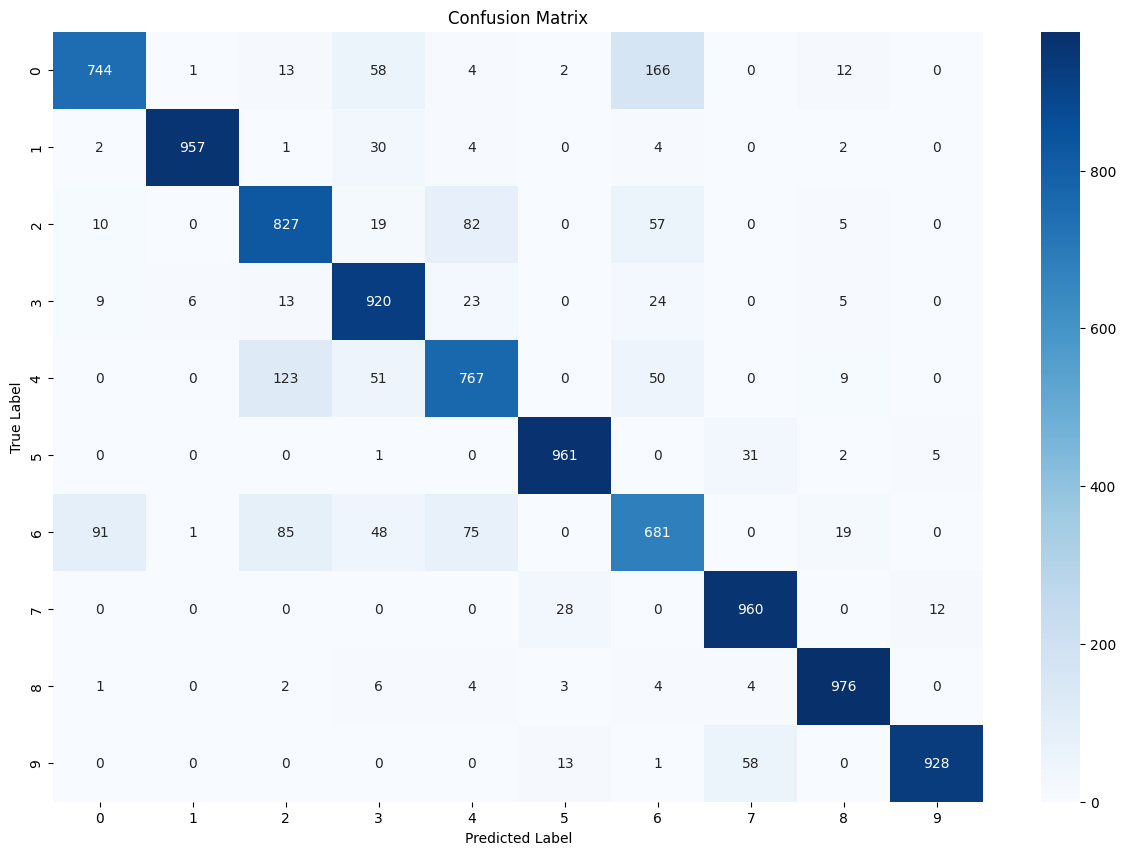

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▆▇▇██
Training Loss,█▆▅▄▃▃▂▂▁▁
Validation Accuracy,▁▄▅▆▆▇▇███
Validation Loss,█▅▄▃▃▂▂▂▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


In [8]:
# Generating Confusion Matrix with best Configuration on TestSet

#initializing wandb
wandb.init(project="DA6401 Assignment1")
runName = "Confusion Matrix"
wandb.run.name = runName
wandb.run.save()

model = feedForwardNeuralNetwork(inputSize=784, hiddenLayerCount=3, outputSize=10,hiddenSize=128, batchSize=32, learningRate=0.0001, initMode="xavier",
                                  optimiser="adam", activationFunc="relu", weightDecay=0.0005,epochs=10, isWandb=True)
model.fit()
model.confusionMatrix()

wandb.finish()

# Question 8


In [13]:
#comparing mse loss with squared error loss

# taking best config and comparing both mse and squared error loss.

sweep_config = {
    'method': 'grid',
    'name': 'Cross Entropy Loss Vs MSE Loss',
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'run' :{ 'values': [1, 2]}
    }
}

def main():
    # Initialize a new run for each agent trial
    wandb.init()
    config = wandb.config

    if config.run == 1:

      runName = "crossEntropy_hS128_hl3_bs32_ep10_lr0.0001_adam_relu_xavier_wd0.0005"
      wandb.run.name = runName
      wandb.run.save()

      model = feedForwardNeuralNetwork(inputSize=784, hiddenLayerCount=3, outputSize=10,hiddenSize=128, batchSize=32, learningRate=0.0001, initMode="xavier",
                                  optimiser="adam", activationFunc="relu", weightDecay=0.0005,epochs=10, isWandb=True)
    elif config.run == 2:
      runName = "MSE_hS128_hl3_bs32_ep10_lr0.0001_adam_relu_xavier_wd0.0005"
      wandb.run.name = runName
      wandb.run.save()

      model = feedForwardNeuralNetwork(inputSize=784, hiddenLayerCount=3, outputSize=10,hiddenSize=128, batchSize=32, learningRate=0.0001, initMode="xavier",
                                  optimiser="adam", activationFunc="relu", weightDecay=0.0005,epochs=10, isWandb=True,lossFunc="squaredLoss")
    model.fit()
    wandb.finish()

sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401 Assignment1')
wandb.agent(sweep_id, main, count=2)


Create sweep with ID: 2c8w41jx
Sweep URL: https://wandb.ai/cs24m018-iitmaana/DA6401%20Assignment1/sweeps/2c8w41jx


wandb: Agent Starting Run: tjfbrqfq with config:
wandb: 	run: 1


Validation Accuracy:  82.66666666666667
Validation Loss:  0.4798247263541332
Training Accuracy:  83.58518518518518
Training Loss:  0.4624434051499987
Validation Accuracy:  84.5
Validation Loss:  0.4287653772359427
Training Accuracy:  85.46296296296296
Training Loss:  0.40632969499479327
Validation Accuracy:  85.46666666666667
Validation Loss:  0.40328460343025474
Training Accuracy:  86.47407407407407
Training Loss:  0.3763955205394613
Validation Accuracy:  86.05
Validation Loss:  0.38651821125732705
Training Accuracy:  87.15555555555555
Training Loss:  0.35629978678183816
Validation Accuracy:  86.56666666666666
Validation Loss:  0.3740824672327963
Training Accuracy:  87.72777777777777
Training Loss:  0.33964200368812997
Validation Accuracy:  86.66666666666667
Validation Loss:  0.3685558371831222
Training Accuracy:  88.07222222222222
Training Loss:  0.3292981438727288
Validation Accuracy:  87.0
Validation Loss:  0.3636584605657719
Training Accuracy:  88.37592592592593
Training Loss:  0.

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▇▇▇██
Training Loss,█▆▄▃▃▂▂▂▁▁
Validation Accuracy,▁▄▅▆▆▇▇███
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: fol7jjdr with config:
wandb: 	run: 2


Validation Accuracy:  83.95
Validation Loss:  0.24466777078222385
Training Accuracy:  83.07037037037037
Training Loss:  0.251040110241177
Validation Accuracy:  85.21666666666667
Validation Loss:  0.2268232116739713
Training Accuracy:  84.12592592592593
Training Loss:  0.23273228765509948
Validation Accuracy:  85.53333333333333
Validation Loss:  0.21985399352231894
Training Accuracy:  84.46111111111111
Training Loss:  0.2251369525904735
Validation Accuracy:  85.58333333333333
Validation Loss:  0.2164898201350008
Training Accuracy:  84.81851851851852
Training Loss:  0.2208754654409036
Validation Accuracy:  85.46666666666667
Validation Loss:  0.21607858923262685
Training Accuracy:  84.87962962962963
Training Loss:  0.22075400466434136
Validation Accuracy:  85.35
Validation Loss:  0.21467960015135634
Training Accuracy:  84.90185185185184
Training Loss:  0.2183716290679414
Validation Accuracy:  84.73333333333333
Validation Loss:  0.2201025568692512
Training Accuracy:  84.49444444444444
Trai

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,████████▁▁
Training Loss,▁▁▁▁▁▁▁▁██
Validation Accuracy,████████▁▁
Validation Loss,▁▁▁▁▁▁▁▁██
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


# Question 10

Create sweep with ID: palxbozh
Sweep URL: https://wandb.ai/cs24m018-iitmaana/DA6401%20Assignment1/sweeps/palxbozh


wandb: Agent Starting Run: 73qvhcp9 with config:
wandb: 	run: 1


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Validation Accuracy:  93.01666666666667
Validation Loss:  0.25134223455720783
Training Accuracy:  93.12222222222222
Training Loss:  0.24410820655331014
Validation Accuracy:  94.26666666666667
Validation Loss:  0.19231502750654317
Training Accuracy:  95.00555555555556
Training Loss:  0.1755167966266714
Validation Accuracy:  94.86666666666666
Validation Loss:  0.1636348223598145
Training Accuracy:  95.98518518518519
Training Loss:  0.13957107883948877
Validation Accuracy:  95.41666666666667
Validation Loss:  0.1447533088545796
Training Accuracy:  96.64074074074074
Training Loss:  0.11530353720922339
Validation Accuracy:  95.86666666666666
Validation Loss:  0.1312892379934227
Training Accuracy:  97.16111111111111
Training Loss:  0.09756015927951249
Validation Accuracy:  96.31666666666666
Validation Loss:  0.12114884995054395
Training Accuracy:  97.59814814814816
Training Loss:  0.0831537142721657
Validation Accuracy:  96.48333333333333
Va

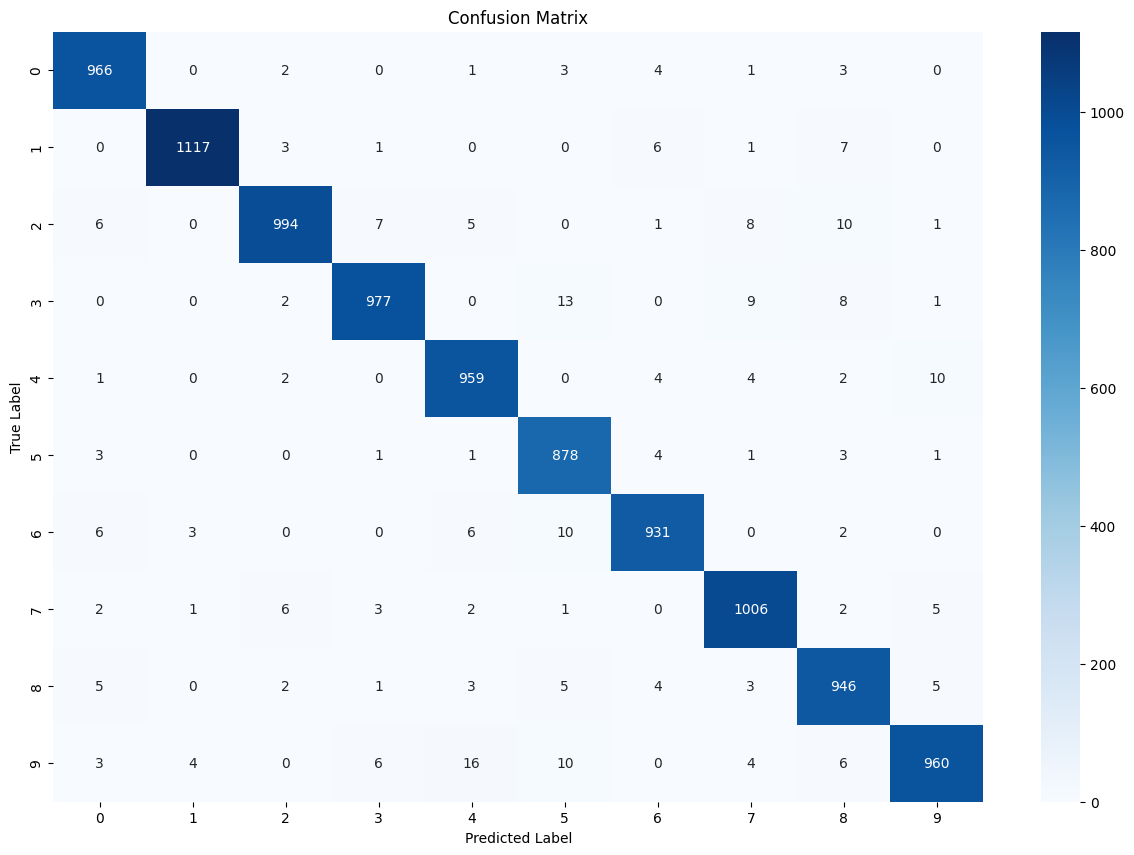

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▅▅▆▇▇▇██
Training Loss,█▆▄▃▃▂▂▂▁▁
Validation Accuracy,▁▃▅▆▆▇████
Validation Loss,█▅▄▃▂▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,adam


wandb: Agent Starting Run: 2o8qspdp with config:
wandb: 	run: 2


Validation Accuracy:  91.61666666666666
Validation Loss:  0.2886408683270953
Training Accuracy:  91.90555555555555
Training Loss:  0.28124497364100487
Validation Accuracy:  93.05
Validation Loss:  0.232435256499384
Training Accuracy:  93.68333333333334
Training Loss:  0.21936682474003155
Validation Accuracy:  94.38333333333334
Validation Loss:  0.19631889569540142
Training Accuracy:  94.90925925925926
Training Loss:  0.17948235923545441
Validation Accuracy:  95.05
Validation Loss:  0.17018005912682282
Training Accuracy:  95.7388888888889
Training Loss:  0.14978155848012564
Validation Accuracy:  95.55
Validation Loss:  0.15151033403849992
Training Accuracy:  96.3462962962963
Training Loss:  0.12721542937590274
Validation Accuracy:  95.93333333333334
Validation Loss:  0.13767220377207007
Training Accuracy:  96.87962962962963
Training Loss:  0.10965225530480179
Validation Accuracy:  96.16666666666667
Validation Loss:  0.12699957069769893
Training Accuracy:  97.26666666666667
Training Loss

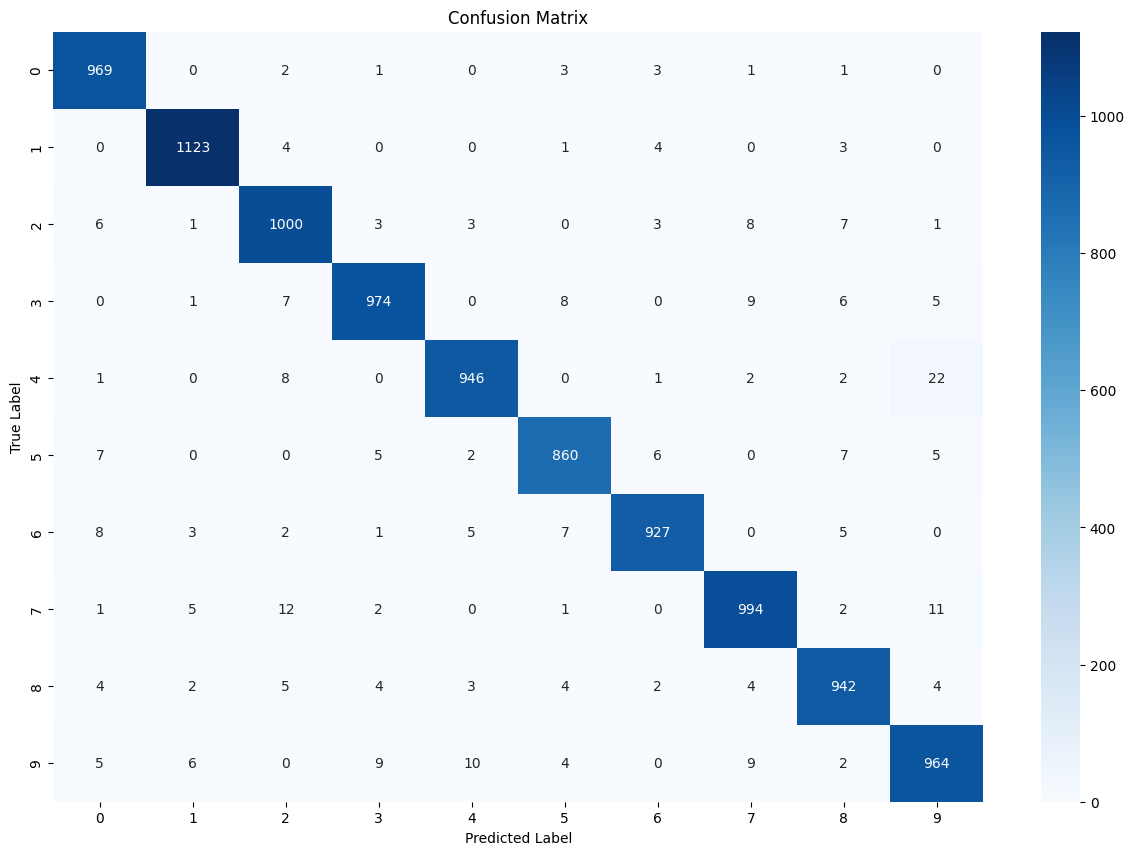

Batch Size,▁▁▁▁▁▁▁▁▁▁
Epoch,▁▂▃▃▄▅▆▆▇█
Learning Rate,▁▁▁▁▁▁▁▁▁▁
Training Accuracy,▁▃▄▅▆▇▇▇██
Training Loss,█▆▅▄▃▂▂▂▁▁
Validation Accuracy,▁▃▅▆▆▇▇███
Validation Loss,█▆▄▃▃▂▂▁▁▁
Batch Size,32
Epoch,10
Learning Rate,0.0001
Optimiser,nadam


wandb: Agent Starting Run: ide8jhxw with config:
wandb: 	run: 3


Validation Accuracy:  96.21666666666667
Validation Loss:  0.13316236048940264
Training Accuracy:  96.55
Training Loss:  0.11597764178966798
Validation Accuracy:  96.45
Validation Loss:  0.12197866237735303
Training Accuracy:  97.47777777777777
Training Loss:  0.08369120283794483
Validation Accuracy:  96.75
Validation Loss:  0.11802803598270577
Training Accuracy:  97.97222222222223
Training Loss:  0.06374161660241748
Validation Accuracy:  97.15
Validation Loss:  0.11233466054935932
Training Accuracy:  98.12592592592593
Training Loss:  0.05786018427606779
Validation Accuracy:  97.51666666666667
Validation Loss:  0.10195402128682157
Training Accuracy:  98.75555555555556
Training Loss:  0.039370197830891906


Test Accuracy:  97.57
Test Loss:  0.09283280936156744


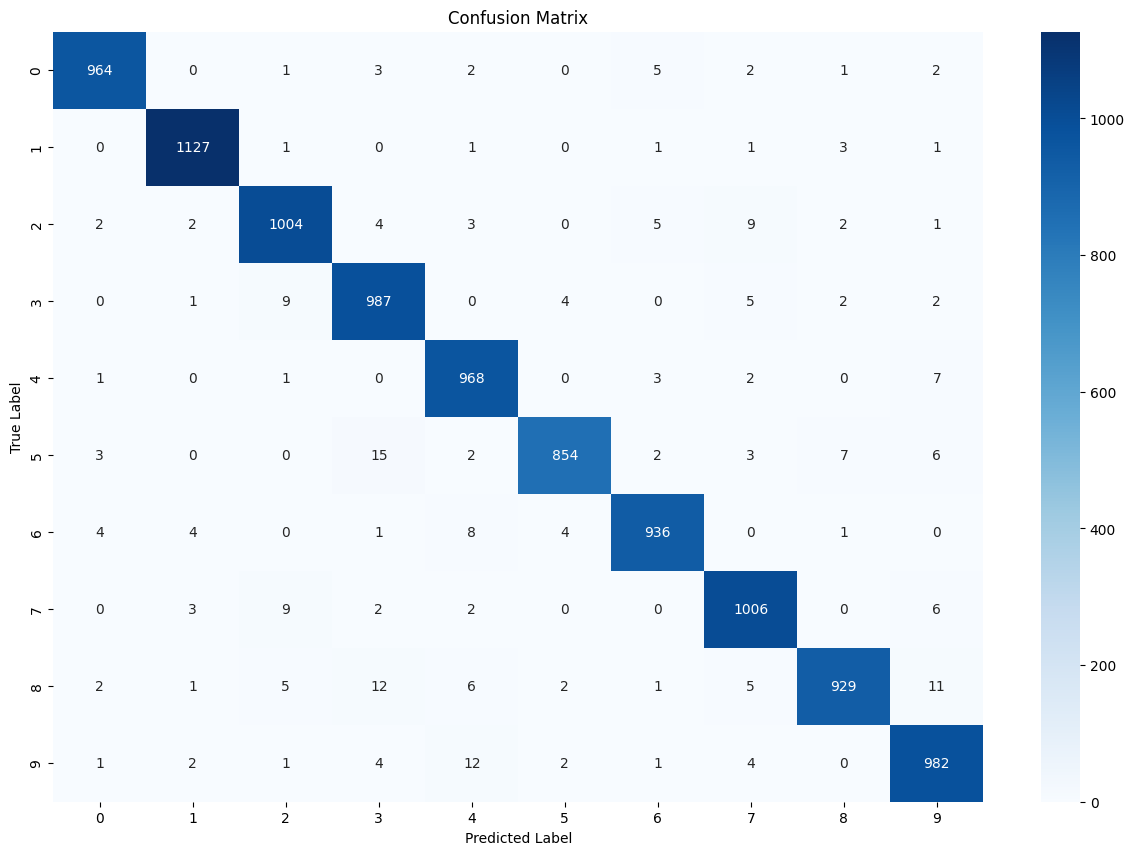

Batch Size,▁▁▁▁▁
Epoch,▁▃▅▆█
Learning Rate,▁▁▁▁▁
Training Accuracy,▁▄▆▆█
Training Loss,█▅▃▃▁
Validation Accuracy,▁▂▄▆█
Validation Loss,█▅▅▃▁
Batch Size,16
Epoch,5
Learning Rate,0.001
Optimiser,nadam


In [14]:
#comparing mse loss with squared error loss

# taking 3 best configs and comparing both mse and squared error loss.

sweep_config = {
    'method': 'grid',
    'name': 'MNIST Data',
    'metric': {
        'name': 'Validation Accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'run' :{ 'values': [1, 2, 3]}
    }
}

def main():
    # Initialize a new run for each agent trial
    wandb.init()
    config = wandb.config

    if config.run == 1:

      runName = "crossEntropy_hS128_hl3_bs32_ep10_lr0.0001_adam_relu_xavier_wd0.0005"
      wandb.run.name = runName
      wandb.run.save()

      model = feedForwardNeuralNetwork(inputSize=784, hiddenLayerCount=3, outputSize=10,hiddenSize=128, batchSize=32, learningRate=0.0001, initMode="xavier",
                                  optimiser="adam", activationFunc="relu", weightDecay=0.0005,epochs=10, isWandb=True, dataset="MNIST")
    elif config.run == 2:
      runName = "crossEntropy_hS128_hl3_bs32_ep10_lr0.0001_nadam_tanh_xavier_wd0.0005"
      wandb.run.name = runName
      wandb.run.save()

      model = feedForwardNeuralNetwork(inputSize=784, hiddenLayerCount=3, outputSize=10,hiddenSize=128, batchSize=32, learningRate=0.0001, initMode="xavier",
                                  optimiser="nadam", activationFunc="tanh", weightDecay=0.0005,epochs=10, isWandb=True, dataset="MNIST")
    elif config.run == 3:
      runName = "crossEntropy_hS128_hl3_bs16_ep5_lr0.001_nadam_relu_xavier_wd0.0005"
      wandb.run.name = runName
      wandb.run.save()

      model = feedForwardNeuralNetwork(inputSize=784, hiddenLayerCount=3, outputSize=10,hiddenSize=128, batchSize=16, learningRate=0.001, initMode="xavier",
                                  optimiser="nadam", activationFunc="relu", weightDecay=0.0005,epochs=5, isWandb=True, dataset="MNIST")

    model.fit()
    model.confusionMatrix()
    wandb.finish()

sweep_id = wandb.sweep(sweep=sweep_config, project='DA6401 Assignment1')
wandb.agent(sweep_id, main, count=3)


# Ran using Train.py

In [ ]:
!python train.py --wandb_entity cs24m018-iitmaana --wandb_project "DA6401 Assignment1"

2025-03-17 18:01:20.706417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742234480.749348   50930 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742234480.762258   50930 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
fashionMNIST
10
32
adam
crossEntropyLoss
0.0001
0.5
0.9
0.9
0.999
1e-08
0.0005
xavier
3
128
relu
wandb: Currently logged in as: cs24m018 (cs24m018-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.8
wandb: Run data is saved locally in /content/wandb/run-20250317_180126-z8k2hm20
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run wise-brook-569
wa